# Frontal Detection Analysis (front crossing rates)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from matplotlib import cm
import matplotlib as mpl
import cartopy.feature as cfeature
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import nc_time_axis
from scipy import stats

## Function to calculate seasonal rate climatologies

In [2]:
# function for calculating seasonal climatological rates over CONUS (spatial field, spatial mean, spatial stdev)
def srates_clim_CONUS(path, file, grid):

    # read in files
    rates_fronts = xr.open_dataset(path+file)
    
    # process seasonal rate climatology and standard deviation
    srates_clim = rates_fronts.seasonal_rate_climatology
    srates_clim_stdev = rates_fronts.seasonal_rate_climatology_stdev
    
    # check gridtype
    # approx. lat/lon here to get a CONUS rectangular region - may not exactly match Jim's analysis
    if grid=="CESM":
        srates_clim_CONUS = srates_clim.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons
        srates_clim_stdev_CONUS = srates_clim_stdev.sel(lat=slice(26,50), lon=slice(235,292))
    elif grid=="MERRA":
        srates_clim_CONUS = srates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)) # MERRA2 grid lons for rates calculated via polylines
        srates_clim_stdev_CONUS = srates_clim_stdev.sel(lat=slice(26,50), lon=slice(-125, -68))
    
    # average over CONUS
    weights = np.cos(np.deg2rad(srates_clim_CONUS.lat))
    weights.name = "weights"
    srates_clim_CONUS_weighted = srates_clim_CONUS.weighted(weights)
    srates_clim_CONUS_weighted_mean = srates_clim_CONUS_weighted.mean(("lon","lat"))
    srates_clim_stdev_CONUS_weighted = srates_clim_stdev_CONUS.weighted(weights)
    srates_clim_stdev_CONUS_weighted_mean = srates_clim_stdev_CONUS_weighted.mean(("lon","lat"))
    
    return(srates_clim_CONUS, srates_clim_stdev_CONUS, srates_clim_CONUS_weighted_mean, srates_clim_stdev_CONUS_weighted_mean)

## Function to calculate monthly rate climatologies

In [3]:
# function for calculating seasonal climatological rates over CONUS (spatial field, spatial mean, spatial stdev)
def mrates_clim_CONUS(path, file, grid):

    # read in files
    rates_fronts = xr.open_dataset(path+file)
    
    # process seasonal rate climatology and standard deviation
    mrates_clim = rates_fronts.monthly_rate_climatology
    mrates_clim_stdev = rates_fronts.monthly_rate_climatology_stdev
    
    # check gridtype
    # approx. lat/lon here to get a CONUS rectangular region - may not exactly match Jim's analysis
    if grid=="CESM":
        mrates_clim_CONUS = mrates_clim.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons
        mrates_clim_stdev_CONUS = mrates_clim_stdev.sel(lat=slice(26,50), lon=slice(235,292))
    elif grid=="MERRA":
        mrates_clim_CONUS = mrates_clim.sel(lat=slice(26,50), lon=slice(-125, -68)) # MERRA2 grid lons for rates calculated via polylines
        mrates_clim_stdev_CONUS = mrates_clim_stdev.sel(lat=slice(26,50), lon=slice(-125, -68))
    
    # average over CONUS
    weights = np.cos(np.deg2rad(mrates_clim_CONUS.lat))
    weights.name = "weights"
    mrates_clim_CONUS_weighted = mrates_clim_CONUS.weighted(weights)
    mrates_clim_CONUS_weighted_mean = mrates_clim_CONUS_weighted.mean(("lon","lat"))
    mrates_clim_stdev_CONUS_weighted = mrates_clim_stdev_CONUS.weighted(weights)
    mrates_clim_stdev_CONUS_weighted_mean = mrates_clim_stdev_CONUS_weighted.mean(("lon","lat"))
    
    return(mrates_clim_CONUS, mrates_clim_stdev_CONUS, mrates_clim_CONUS_weighted_mean, mrates_clim_stdev_CONUS_weighted_mean)

## Function to calculate mean annual rate

In [4]:
def arates_mean_CONUS(path, file, grid):
    
    # read in files
    rates_fronts = xr.open_dataset(path+file)
    
    # read in total rate and standard deviation
    arates_mean = rates_fronts.total_rate
    arates_mean_stdev = rates_fronts.total_rate_stdev
    
    # check gridtype
    # approx. lat/lon here to get a CONUS rectangular region - may not exactly match Jim's analysis
    if grid=="CESM":
        arates_mean_CONUS = arates_mean.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons
        arates_mean_stdev_CONUS = arates_mean_stdev.sel(lat=slice(26,50), lon=slice(235,292))
    elif grid=="MERRA":
        arates_mean_CONUS = arates_mean.sel(lat=slice(26,50), lon=slice(-125, -68)) # MERRA2 grid lons for rates calculated via polylines
        arates_mean_stdev_CONUS = arates_mean_stdev.sel(lat=slice(26,50), lon=slice(-125, -68))
            
    # average over CONUS
    weights = np.cos(np.deg2rad(arates_mean_CONUS.lat))
    weights.name = "weights"
    arates_mean_CONUS_weighted = arates_mean_CONUS.weighted(weights)
    arates_mean_CONUS_weighted_mean = arates_mean_CONUS_weighted.mean(("lon","lat"))
    arates_mean_stdev_CONUS_weighted = arates_mean_stdev_CONUS.weighted(weights)
    arates_mean_stdev_CONUS_weighted_mean = arates_mean_stdev_CONUS_weighted.mean(("lon","lat"))
    
    return(arates_mean_CONUS, arates_mean_stdev_CONUS, arates_mean_CONUS_weighted_mean, arates_mean_stdev_CONUS_weighted_mean)

## Reading in front files and calculating climatologies

### Coded Surface Bulletin

In [5]:
csb_filepath = "/glade/work/kdagon/ML-extremes/data/CODSUS/MERRA2/"
csb_masked_rates_file = "codsus_masked_frontRates_2003-2015.nc" # masked to compare with Jim's analysis
csb_masked_srates_clim_CONUS, csb_masked_srates_clim_stdev_CONUS, csb_masked_srates_clim_CONUS_mean, csb_masked_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(csb_filepath, csb_masked_rates_file, "MERRA")
csb_masked_mrates_clim_CONUS, csb_masked_mrates_clim_stdev_CONUS, csb_masked_mrates_clim_CONUS_mean, csb_masked_mrates_clim_stdev_CONUS_mean = mrates_clim_CONUS(csb_filepath, csb_masked_rates_file, "MERRA")

In [6]:
csb_masked_srates_clim_CONUS_mean[:,4]
csb_masked_mrates_clim_CONUS_mean[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.32471475, 0.31300864, 0.27625354, 0.29810585])
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] 2009-01-15 2009-04-15 ... 2009-10-15
    front_type    object 'all'
Dimensions without coordinates: seasons4

In [7]:
# sum across front types is not equal to "all" front type
csb_masked_srates_clim_CONUS_mean[:,:3].sum("front")
csb_masked_mrates_clim_CONUS_mean[:,:3].sum("front")

<xarray.DataArray (seasons4: 4)>
array([0.4494713 , 0.4426034 , 0.40918392, 0.41450852])
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] 2009-01-15 2009-04-15 ... 2009-10-15
Dimensions without coordinates: seasons4

In [8]:
csb_masked_srates_clim_stdev_CONUS_mean[:,4]
csb_masked_mrates_clim_stdev_CONUS_mean[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.06057323, 0.0554856 , 0.05437348, 0.04427692])
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] 2009-01-15 2009-04-15 ... 2009-10-15
    front_type    object 'all'
Dimensions without coordinates: seasons4

In [6]:
csb_rates_file = "codsus_frontRates_2003-2015.nc" # unmasked to compare with CESM output
csb_srates_clim_CONUS, csb_srates_clim_stdev_CONUS, csb_srates_clim_CONUS_mean, csb_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(csb_filepath, csb_rates_file, "MERRA")
csb_mrates_clim_CONUS, csb_mrates_clim_stdev_CONUS, csb_mrates_clim_CONUS_mean, csb_mrates_clim_stdev_CONUS_mean = mrates_clim_CONUS(csb_filepath, csb_rates_file, "MERRA")
csb_arates_mean_CONUS, csb_arates_mean_stdev_CONUS, csb_arates_mean_CONUS_mean, csb_arates_mean_stdev_CONUS_mean = arates_mean_CONUS(csb_filepath, csb_rates_file, "MERRA")

In [ ]:
csb_srates_clim_CONUS_mean[:,4]
csb_mrates_clim_CONUS_mean[:,4]

In [10]:
csb_srates_clim_stdev_CONUS_mean[:,4]
csb_mrates_clim_stdev_CONUS_mean[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.05933122, 0.05412225, 0.04911411, 0.04307559])
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] 2009-01-15 2009-04-15 ... 2009-10-15
    front_type    object 'all'
Dimensions without coordinates: seasons4

### CESM

In [7]:
cesm_filepath = "/glade/work/kdagon/FrontDetector/CESMOutputs/"
#cesm_hist_rates_file = "cesm_frontRates_2000-2005.nc" # CESM historial simulation, 2000-2005
cesm_rates_file = "cesm_fronts_2003-2015_frontRates_viaPolylines_customgrid.nc" # rates calculated via polyline analysis (to better compare to Jim's analysis)

cesm_srates_clim_CONUS, cesm_srates_clim_stdev_CONUS, cesm_srates_clim_CONUS_mean, cesm_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(cesm_filepath, cesm_rates_file, "MERRA")
#cesm_srates_clim_CONUS_mean[:,4]
cesm_mrates_clim_CONUS, cesm_mrates_clim_stdev_CONUS, cesm_mrates_clim_CONUS_mean, cesm_mrates_clim_stdev_CONUS_mean = mrates_clim_CONUS(cesm_filepath, cesm_rates_file, "MERRA")

In [12]:
cesm_srates_clim_stdev_CONUS_mean[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.04847854, 0.04715109, 0.04629582, 0.04579892])
Coordinates:
    clim_seasons  (seasons4) object 2009-01-15 00:00:00 ... 2009-10-15 00:00:00
    front_type    object 'all'
Dimensions without coordinates: seasons4

In [8]:
cesm_OH_rates_file = "cesm_frontRates_2003-2015.nc" # rates calculated via one-hot files
cesm_OH_srates_clim_CONUS, cesm_OH_srates_clim_stdev_CONUS, cesm_OH_srates_clim_CONUS_mean, cesm_OH_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(cesm_filepath, cesm_OH_rates_file, "CESM")
#cesm_OH_srates_clim_CONUS_mean[:,4]

In [15]:
cesm_OH_srates_clim_stdev_CONUS_mean[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.04664363, 0.04370036, 0.04110855, 0.04265401])
Coordinates:
    clim_seasons  (seasons4) object 2009-01-15 00:00:00 ... 2009-10-15 00:00:00
    front_type    object 'all'
Dimensions without coordinates: seasons4

In [9]:
# cesm rates calculated over full historical (2000-2015) period
cesm_full_rates_file = "cesm_fronts_2000-2015_frontRates_viaPolylines_customgrid.nc"
cesm_OH_full_rates_file = "cesm_frontRates_2000-2015.nc"

cesm_full_srates_clim_CONUS, cesm_full_srates_clim_stdev_CONUS, cesm_full_srates_clim_CONUS_mean, cesm_full_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(cesm_filepath, cesm_full_rates_file, "MERRA")
cesm_full_mrates_clim_CONUS, cesm_full_mrates_clim_stdev_CONUS, cesm_full_mrates_clim_CONUS_mean, cesm_full_mrates_clim_stdev_CONUS_mean = mrates_clim_CONUS(cesm_filepath, cesm_full_rates_file, "MERRA")
cesm_full_arates_mean_CONUS, cesm_full_arates_mean_stdev_CONUS, cesm_full_arates_mean_CONUS_mean, cesm_full_arates_mean_stdev_CONUS_mean = arates_mean_CONUS(cesm_filepath, cesm_full_rates_file, "MERRA")

cesm_OH_full_srates_clim_CONUS, cesm_OH_full_srates_clim_stdev_CONUS, cesm_OH_full_srates_clim_CONUS_mean, cesm_OH_full_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(cesm_filepath, cesm_OH_full_rates_file, "CESM")
cesm_OH_full_mrates_clim_CONUS, cesm_OH_full_mrates_clim_stdev_CONUS, cesm_OH_full_mrates_clim_CONUS_mean, cesm_OH_full_mrates_clim_stdev_CONUS_mean = mrates_clim_CONUS(cesm_filepath, cesm_OH_full_rates_file, "CESM")

In [10]:
# cesm rates with a modified 15-year climatology to match RCP #years (2000-2014)
cesm_fullmod_rates_file = "cesm_fronts_2000-2014_frontRates_viaPolylines_customgrid.nc"
cesm_fullmod_srates_clim_CONUS, cesm_fullmod_srates_clim_stdev_CONUS, cesm_fullmod_srates_clim_CONUS_mean, cesm_fullmod_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(cesm_filepath, cesm_fullmod_rates_file, "MERRA")
cesm_fullmod_mrates_clim_CONUS, cesm_fullmod_mrates_clim_stdev_CONUS, cesm_fullmod_mrates_clim_CONUS_mean, cesm_fullmod_mrates_clim_stdev_CONUS_mean = mrates_clim_CONUS(cesm_filepath, cesm_fullmod_rates_file, "MERRA")
cesm_OH_fullmod_rates_file = "cesm_frontRates_2000-2014.nc"
cesm_OH_fullmod_srates_clim_CONUS, cesm_OH_fullmod_srates_clim_stdev_CONUS, cesm_OH_fullmod_srates_clim_CONUS_mean, cesm_OH_fullmod_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(cesm_filepath, cesm_OH_fullmod_rates_file, "CESM")
cesm_OH_fullmod_mrates_clim_CONUS, cesm_OH_fullmod_mrates_clim_stdev_CONUS, cesm_OH_fullmod_mrates_clim_CONUS_mean, cesm_OH_fullmod_mrates_clim_stdev_CONUS_mean = mrates_clim_CONUS(cesm_filepath, cesm_OH_fullmod_rates_file, "CESM")

In [11]:
# cesm rcp8.5 results
cesm_OH_rcp85_rates_file = "cesm_frontRates_2086-2100.nc" # generated via one-hot files
cesm_OH_rcp85_srates_clim_CONUS, cesm_OH_rcp85_srates_clim_stdev_CONUS, cesm_OH_rcp85_srates_clim_CONUS_mean, cesm_OH_rcp85_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(cesm_filepath, cesm_OH_rcp85_rates_file, "CESM")
cesm_OH_rcp85_mrates_clim_CONUS, cesm_OH_rcp85_mrates_clim_stdev_CONUS, cesm_OH_rcp85_mrates_clim_CONUS_mean, cesm_OH_rcp85_mrates_clim_stdev_CONUS_mean = mrates_clim_CONUS(cesm_filepath, cesm_OH_rcp85_rates_file, "CESM")

In [12]:
# via polylines
cesm_rcp85_rates_file = "cesm_fronts_2086-2100_frontRates_viaPolylines_customgrid.nc" # generated via poylines
cesm_rcp85_srates_clim_CONUS, cesm_rcp85_srates_clim_stdev_CONUS, cesm_rcp85_srates_clim_CONUS_mean, cesm_rcp85_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(cesm_filepath, cesm_rcp85_rates_file, "MERRA")
cesm_rcp85_mrates_clim_CONUS, cesm_rcp85_mrates_clim_stdev_CONUS, cesm_rcp85_mrates_clim_CONUS_mean, cesm_rcp85_mrates_clim_stdev_CONUS_mean = mrates_clim_CONUS(cesm_filepath, cesm_rcp85_rates_file, "MERRA")

### MERRA

In [13]:
merra_filepath = "/glade/work/kdagon/FrontDetector/MERRAOutputs/"
merra_rates_file = "merra_fronts_2003-2015_frontRates_viaPolylines_customgrid.nc"

merra_srates_clim_CONUS, merra_srates_clim_stdev_CONUS, merra_srates_clim_CONUS_mean, merra_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(merra_filepath, merra_rates_file, "MERRA")
#merra_srates_clim_CONUS_mean[:,4]
merra_mrates_clim_CONUS, merra_mrates_clim_stdev_CONUS, merra_mrates_clim_CONUS_mean, merra_mrates_clim_stdev_CONUS_mean = mrates_clim_CONUS(merra_filepath, merra_rates_file, "MERRA")

In [17]:
merra_srates_clim_stdev_CONUS_mean[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.05121827, 0.04926218, 0.04555611, 0.04129746])
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] 2009-01-15 2009-04-15 ... 2009-10-15
    front_type    object 'all'
Dimensions without coordinates: seasons4

In [14]:
merra_OH_rates_file = "merra_frontRates_2003-2015.nc" # via one-hot file
merra_OH_srates_clim_CONUS, merra_OH_srates_clim_stdev_CONUS, merra_OH_srates_clim_CONUS_mean, merra_OH_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(merra_filepath, merra_OH_rates_file, "CESM")
#merra_OH_srates_clim_CONUS_mean[:,4]

In [20]:
merra_OH_srates_clim_stdev_CONUS_mean[:,4]

<xarray.DataArray (seasons4: 4)>
array([0.04978789, 0.04618768, 0.04048906, 0.03805828])
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] 2009-01-15 2009-04-15 ... 2009-10-15
    front_type    object 'all'
Dimensions without coordinates: seasons4

In [15]:
merra_cesm_rates_file = "merra_cesm_fronts_2000-2015_frontRates_viaPolylines_customgrid.nc" # rates calculated via polyline analysis (to better compare to Jim's analysis)
merra_cesm_srates_clim_CONUS, merra_cesm_srates_clim_stdev_CONUS, merra_cesm_srates_clim_CONUS_mean, merra_cesm_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(merra_filepath, merra_cesm_rates_file, "MERRA")
merra_cesm_mrates_clim_CONUS, merra_cesm_mrates_clim_stdev_CONUS, merra_cesm_mrates_clim_CONUS_mean, merra_cesm_mrates_clim_stdev_CONUS_mean = mrates_clim_CONUS(merra_filepath, merra_cesm_rates_file, "MERRA")
merra_cesm_arates_mean_CONUS, merra_cesm_arates_mean_stdev_CONUS, merra_cesm_arates_mean_CONUS_mean, merra_cesm_arates_mean_stdev_CONUS_mean = arates_mean_CONUS(merra_filepath, merra_cesm_rates_file, "MERRA")

In [16]:
merra_cesm_OH_rates_file = "merra_cesm_frontRates_2000-2015.nc" # via one-hot file
merra_cesm_OH_srates_clim_CONUS, merra_cesm_OH_srates_clim_stdev_CONUS, merra_cesm_OH_srates_clim_CONUS_mean, merra_cesm_OH_srates_clim_stdev_CONUS_mean = srates_clim_CONUS(merra_filepath, merra_cesm_OH_rates_file, "CESM")
merra_cesm_OH_mrates_clim_CONUS, merra_cesm_OH_mrates_clim_stdev_CONUS, merra_cesm_OH_mrates_clim_CONUS_mean, merra_cesm_OH_mrates_clim_stdev_CONUS_mean = mrates_clim_CONUS(merra_filepath, merra_cesm_OH_rates_file, "CESM")

## Compare CSB / CESM, 2003-2015

In [19]:
csb_srates_clim_CONUS_mean[:,4]

<xarray.DataArray 'seasonal_rate_climatology' (seasons4: 4)>
array([0.3131632 , 0.29544709, 0.2489845 , 0.27799668])
Coordinates:
    clim_seasons  (seasons4) datetime64[ns] 2009-01-15 2009-04-15 ... 2009-10-15
    front_type    object 'all'
Dimensions without coordinates: seasons4

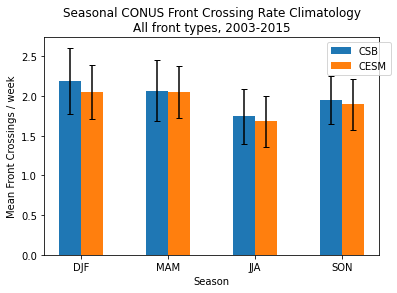

In [17]:
# seasonal rate climatologies
fig, ax = plt.subplots()

w = 0.25
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x - (w/2)
ax.bar(position, (csb_srates_clim_CONUS_mean*7)[:,4], yerr=(csb_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CSB", color='C0', capsize=3)
position = x + (w/2)
ax.bar(position, (cesm_srates_clim_CONUS_mean*7)[:,4], yerr=(cesm_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CESM", color='C1', capsize=3)

ax.set_title('Seasonal CONUS Front Crossing Rate Climatology\nAll front types, 2003-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend(bbox_to_anchor=(1.05, 1));
#plt.savefig('../figures/toSCP/csb_cesm_srates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

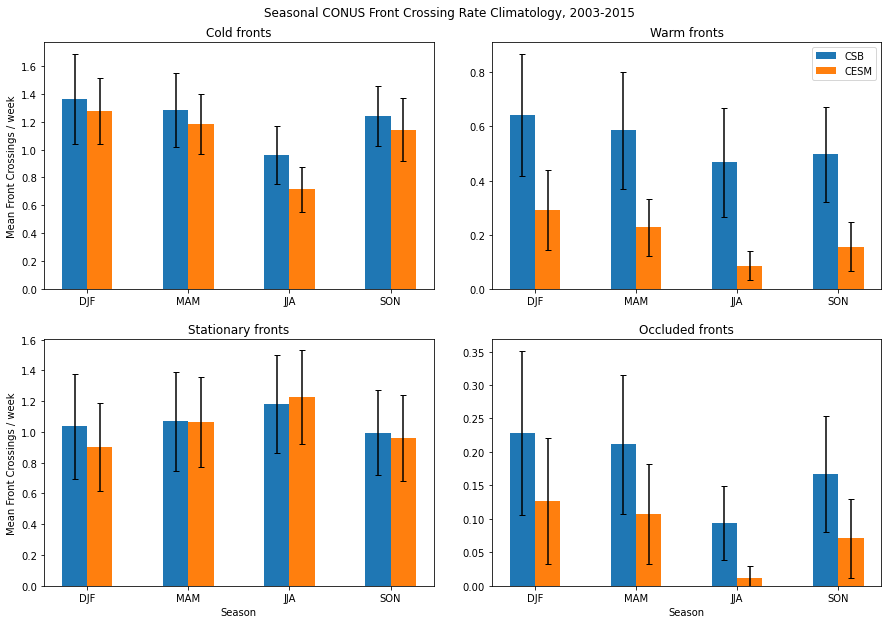

In [16]:
# by front type
frontstrings = ('Cold', 'Warm', 'Stationary', 'Occluded')
nfronts = len(frontstrings)
fig, ax = plt.subplots(2, 2, figsize=(15,10))
ax = ax.ravel()

for i in range(nfronts):
    w = 0.25
    labels = ['DJF', 'MAM', 'JJA', 'SON']
    nseason = len(labels)
    x = np.arange(nseason)  # the label locations

    position = x - (w/2)
    ax[i].bar(position, (csb_srates_clim_CONUS_mean*7)[:,i], yerr=(csb_srates_clim_stdev_CONUS_mean*7)[:,i], width=w, label="CSB", color='C0', capsize=3)
    position = x + (w/2)
    ax[i].bar(position, (cesm_srates_clim_CONUS_mean*7)[:,i], yerr=(cesm_srates_clim_stdev_CONUS_mean*7)[:,i], width=w, label="CESM", color='C1', capsize=3)

    ax[i].set_title(frontstrings[i]+' fronts')
    if i==0 or i==2:
        ax[i].set_ylabel('Mean Front Crossings / week')
    if i==2 or i==3:
        ax[i].set_xlabel('Season')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)
    ax[i].set_ylim(bottom=0)

    if i==1:
        ax[i].legend();
        
plt.subplots_adjust(wspace=0.15, hspace=0.20)

fig.suptitle('Seasonal CONUS Front Crossing Rate Climatology, 2003-2015', y=0.93);

#plt.savefig('../figures/toSCP/csb_cesm_srates_clim_CONUS_mean_wk_byfronttype_stdev.png', bbox_inches='tight')

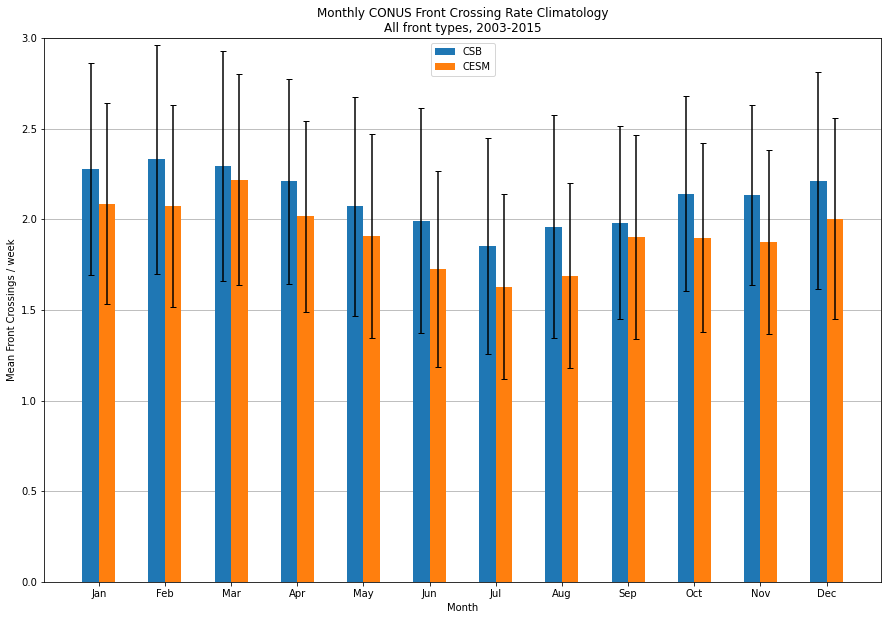

In [25]:
# monthly rate climatologies
fig, ax = plt.subplots(figsize=(15,10))

w = 0.25
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

# settings to better compare to Jim's paper
ax.set_ylim(0,3);
ax.grid(True, axis='y', zorder=0)

position = x - (w/2)
#ax.bar(position, (csb_mrates_clim_CONUS_mean*7)[:,4], yerr=(csb_mrates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CSB", color='C0', capsize=3, zorder=3)
ax.bar(position, (csb_masked_mrates_clim_CONUS_mean*7)[:,4], yerr=(csb_masked_mrates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CSB", color='C0', capsize=3, zorder=3)
position = x + (w/2)
ax.bar(position, (cesm_mrates_clim_CONUS_mean*7)[:,4], yerr=(cesm_mrates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CESM", color='C1', capsize=3, zorder=3)

ax.set_title('Monthly CONUS Front Crossing Rate Climatology\nAll front types, 2003-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Month')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend();

# use unmasked csb to compare with cesm; masked csb to compare with Jim's paper
#plt.savefig('../figures/toSCP/csb_cesm_mrates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/csb_masked_cesm_mrates_clim_CONUS_mean_wk.png', bbox_inches='tight')

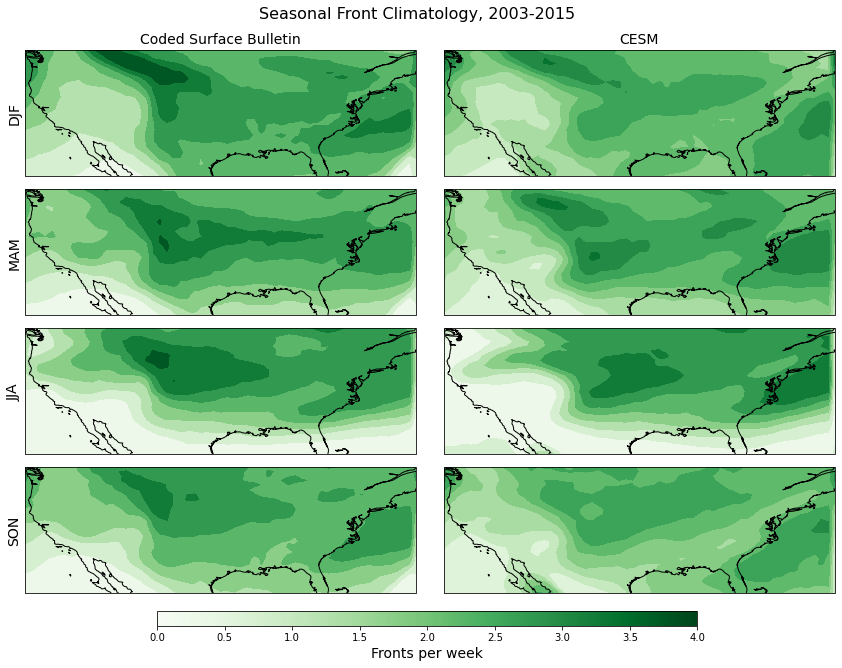

In [26]:
# spatial plots by season type (contour version)
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 2, figsize=(15,10), subplot_kw={'projection': ccrs.LambertCylindrical()})

for i in range(nsea):
    if i == 0:
        axs[i,0].set_title('Coded Surface Bulletin', fontsize=14) 
    field, lon = add_cyclic_point((csb_srates_clim_CONUS*7)[i,4,:,:], coord=csb_srates_clim_CONUS.lon)
    lat = csb_srates_clim_CONUS.lat
    cf = axs[i,0].contourf(lon, lat, field, cmap=cm.Greens, vmin=0, vmax=4, transform=ccrs.PlateCarree()) 
    #cf = axs[i,0].pcolormesh(lon, lat, field, cmap=cm.Greens, transform=ccrs.PlateCarree()) # trying to get rid of contourf interpolation
    axs[i,0].coastlines()
    # can't get ylabels to work?
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    fig.suptitle('Seasonal Front Climatology, 2003-2015', fontsize=16, y=0.94)

    
for i in range(nsea):
    if i == 0:
        axs[i,1].set_title('CESM', fontsize=14)
    field, lon = add_cyclic_point((cesm_srates_clim_CONUS*7)[i,4,:,:], coord=cesm_srates_clim_CONUS.lon)
    lat = cesm_srates_clim_CONUS.lat
    cf = axs[i,1].contourf(lon, lat, field, cmap=cm.Greens, vmin=0, vmax=4, transform=ccrs.PlateCarree())
    #cf = axs[i,1].pcolormesh(lon, lat, field, cmap=cm.Greens, transform=ccrs.PlateCarree()) # trying to get rid of contourf interpolation
    axs[i,1].coastlines()
    
cb_ax = fig.add_axes([0.26, 0.08, 0.5, 0.02])
cmap = mpl.cm.Greens
norm = mpl.colors.Normalize(vmin=0, vmax=4)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal')
cb1.ax.set_xlabel('Fronts per week', fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0.1)

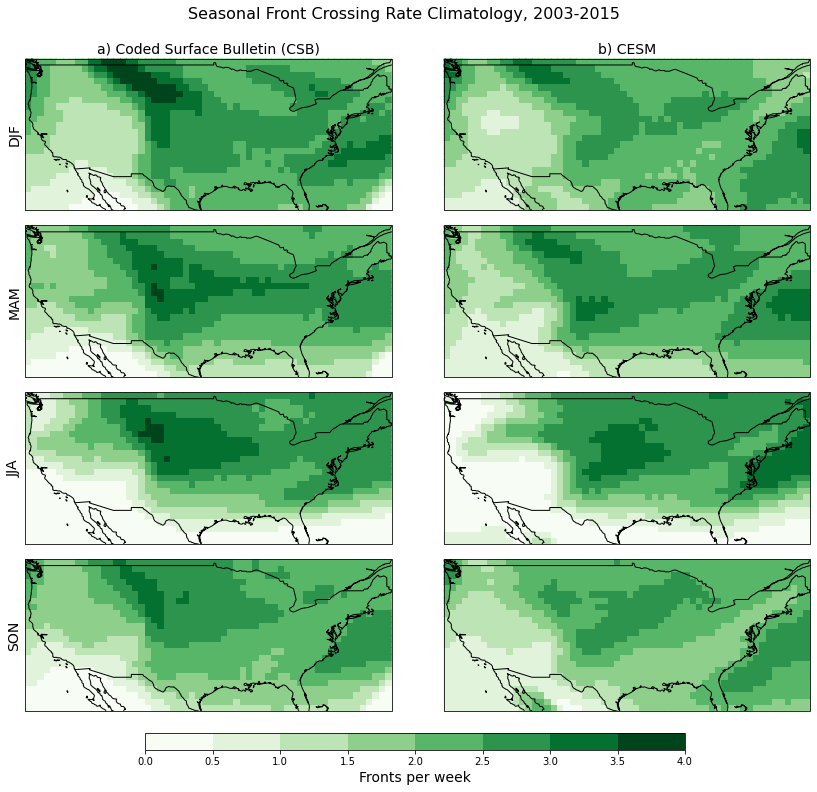

In [19]:
# by season type and change projection/contouring
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 2, figsize=(15,12), subplot_kw={'projection': ccrs.PlateCarree()})
#fig, axs = plt.subplots(nsea, 2, figsize=(15,10), subplot_kw={'projection': ccrs.LambertCylindrical()})
#fig, axs = plt.subplots(nsea, 2, figsize=(15,10), subplot_kw={'projection': ccrs.LambertConformal()}) # some of these may not be ideal for a region (the way I've subset anyway)
#fig, axs = plt.subplots(nsea, 2, figsize=(15,10), subplot_kw={'projection': ccrs.Robinson()})

# discrete colormap
cmap=plt.cm.get_cmap('Greens', 8)

# trying to get colorbar to line up with ticks
#cmap=plt.cm.get_cmap('Greens')
norm = mpl.colors.Normalize(vmin=0, vmax=4)
#bounds = np.array([0,0.5,1,1.5,2,2.5,3,3.5,4])
#norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=8)

for i in range(nsea):
    if i == 0:
        axs[i,0].set_title('a) Coded Surface Bulletin (CSB)', fontsize=14) 
    field, lon = add_cyclic_point((csb_srates_clim_CONUS*7)[i,4,:,:], coord=csb_srates_clim_CONUS.lon)
    lat = csb_srates_clim_CONUS.lat
    #cf = axs[i,0].contourf(lon, lat, field, cmap=cm.Greens, transform=ccrs.PlateCarree()) 
    #cf = axs[i,0].pcolormesh(lon, lat, field, cmap=cm.Greens, transform=ccrs.PlateCarree()) # trying to get rid of contourf interpolation, but pcolormesh adds a white border
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, norm=norm, transform=ccrs.PlateCarree()) # trying to get rid of the white border, does slow down a bit
    # see also: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html#differences-pcolor-pcolormesh
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    #axs[i,0].add_feature(cfeature.STATES)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    fig.suptitle('Seasonal Front Crossing Rate Climatology, 2003-2015', fontsize=16, y=0.94)

for i in range(nsea):
    if i == 0:
        axs[i,1].set_title('b) CESM', fontsize=14)
    # POLYLINES
    field, lon = add_cyclic_point((cesm_srates_clim_CONUS*7)[i,4,:,:], coord=cesm_srates_clim_CONUS.lon)
    lat = cesm_srates_clim_CONUS.lat
    # ONE-HOT
    #field, lon = add_cyclic_point((cesm_OH_srates_clim_CONUS*7)[i,4,:,:], coord=cesm_OH_srates_clim_CONUS.lon)
    #lat = cesm_OH_srates_clim_CONUS.lat
    #cf = axs[i,1].contourf(lon, lat, field, cmap=cm.Greens, transform=ccrs.PlateCarree())
    #cf = axs[i,1].pcolormesh(lon, lat, field, cmap=cm.Greens, transform=ccrs.PlateCarree())
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
# TO DO: fix the colorbar labels - slightly off the colorbar borders?
cb_ax = fig.add_axes([0.26, 0.08, 0.5, 0.02])

#norm = mpl.colors.Normalize(vmin=0, vmax=4)
#cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal', ticks=np.arange(0,4.5,0.5))
#cb1.ax.set_xlabel('Fronts per week', fontsize=14)

cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal', ticks=np.arange(0,4.5,0.5))
cbar.ax.set_xlabel('Fronts per week', fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0.1)
#plt.savefig('../figures/toSCP/csb_cesm_srates_clim_CONUS_viaOH.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/csb_cesm_srates_clim_CONUS_viaPoly.png', bbox_inches='tight')

3.8511229
3.5443792
3.7501838
3.4144173
3.308547
3.347826
3.4707358
2.8757396
2.9971156
2.8913043
3.0376253
2.6094675


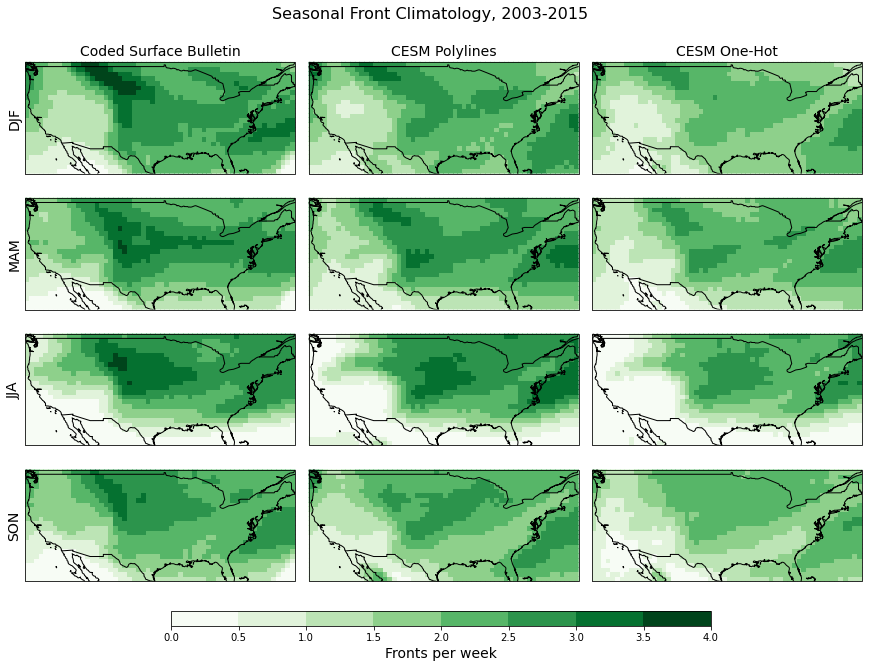

In [20]:
# side-by-side polyline and one-hot spatial plots
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 3, figsize=(15,10), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormap
cmap=plt.cm.get_cmap('Greens', 8)

for i in range(nsea):
    if i == 0:
        axs[i,0].set_title('Coded Surface Bulletin', fontsize=14) 
    field, lon = add_cyclic_point((csb_srates_clim_CONUS*7)[i,4,:,:], coord=csb_srates_clim_CONUS.lon)
    print(field.max()) # check max values for colorbar
    lat = csb_srates_clim_CONUS.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=4, transform=ccrs.PlateCarree()) 
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    fig.suptitle('Seasonal Front Climatology, 2003-2015', fontsize=16, y=0.94)

for i in range(nsea):
    if i == 0:
        axs[i,1].set_title('CESM Polylines', fontsize=14)
    field, lon = add_cyclic_point((cesm_srates_clim_CONUS*7)[i,4,:,:], coord=cesm_srates_clim_CONUS.lon)
    print(field.max())
    lat = cesm_srates_clim_CONUS.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=4, transform=ccrs.PlateCarree())
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
for i in range(nsea):
    if i == 0:
        axs[i,2].set_title('CESM One-Hot', fontsize=14)
    field, lon = add_cyclic_point((cesm_OH_srates_clim_CONUS*7)[i,4,:,:], coord=cesm_OH_srates_clim_CONUS.lon)
    print(field.max())
    lat = cesm_OH_srates_clim_CONUS.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=4, transform=ccrs.PlateCarree())
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)
    
cb_ax = fig.add_axes([0.26, 0.08, 0.5, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=4)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal')
cb1.ax.set_xlabel('Fronts per week', fontsize=14)

plt.subplots_adjust(wspace=0.05, hspace=0)
#plt.savefig('../figures/toSCP/csb_cesm_srates_clim_CONUS_viaPoly_OH.png', bbox_inches='tight')

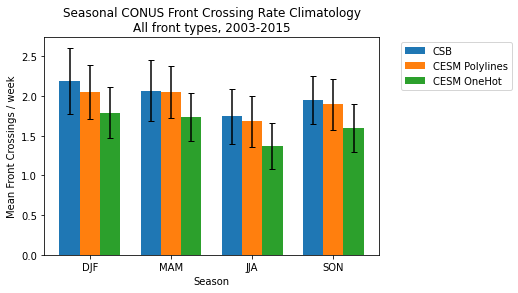

In [100]:
# side-by-side polyline and one-hot bar plots
fig, ax = plt.subplots()

# number of bars per xlabel
nbars=3
# width
w = 0.75/nbars

labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x + (w*(1-nbars)/2) + 0*w
ax.bar(position, (csb_srates_clim_CONUS_mean*7)[:,4], yerr=(csb_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CSB", color='C0', capsize=3)
position = x + (w*(1-nbars)/2) + 1*w
ax.bar(position, (cesm_srates_clim_CONUS_mean*7)[:,4], yerr=(cesm_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CESM Polylines", color='C1', capsize=3)
position = x + (w*(1-nbars)/2) + 2*w
ax.bar(position, (cesm_OH_srates_clim_CONUS_mean*7)[:,4], yerr=(cesm_OH_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CESM OneHot", color='C2', capsize=3)

ax.set_title('Seasonal CONUS Front Crossing Rate Climatology\nAll front types, 2003-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend(bbox_to_anchor=(1.05, 1));
#plt.savefig('../figures/toSCP/csb_cesm_PolyOH_srates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

## Compare MERRA / CSB, 2003-2015

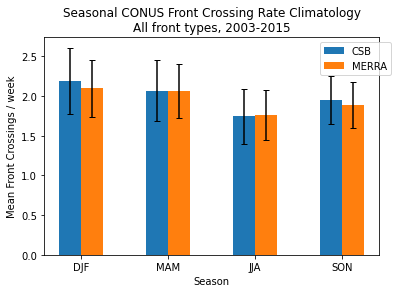

In [55]:
# seasonal rate climatologies
fig, ax = plt.subplots()

w = 0.25
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x - (w/2)
ax.bar(position, (csb_srates_clim_CONUS_mean*7)[:,4], yerr=(csb_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CSB", color='C0', capsize=3)
position = x + (w/2)
ax.bar(position, (merra_srates_clim_CONUS_mean*7)[:,4], yerr=(merra_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="MERRA", color='C1', capsize=3)

ax.set_title('Seasonal CONUS Front Crossing Rate Climatology\nAll front types, 2003-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend(bbox_to_anchor=(1.05, 1));
#plt.savefig('../figures/toSCP/csb_merra_srates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

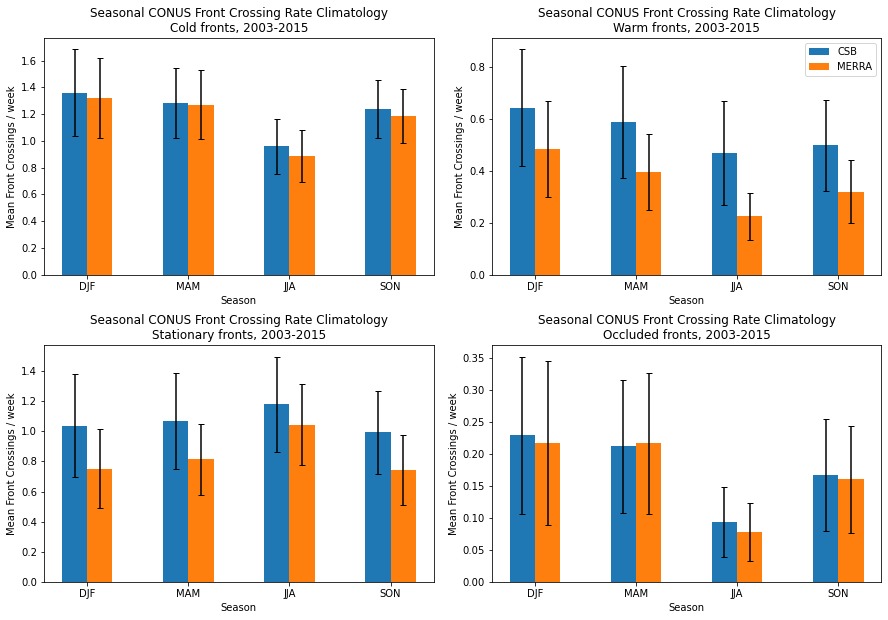

In [40]:
# by front type
frontstrings = ('Cold', 'Warm', 'Stationary', 'Occluded')
nfronts = len(frontstrings)
fig, ax = plt.subplots(2, 2, figsize=(15,10))
ax = ax.ravel()

for i in range(nfronts):
    w = 0.25
    labels = ['DJF', 'MAM', 'JJA', 'SON']
    nseason = len(labels)
    x = np.arange(nseason)  # the label locations

    position = x - (w/2)
    ax[i].bar(position, (csb_srates_clim_CONUS_mean*7)[:,i], yerr=(csb_srates_clim_stdev_CONUS_mean*7)[:,i], width=w, label="CSB", color='C0', capsize=3)
    position = x + (w/2)
    ax[i].bar(position, (merra_srates_clim_CONUS_mean*7)[:,i], yerr=(merra_srates_clim_stdev_CONUS_mean*7)[:,i], width=w, label="MERRA", color='C1', capsize=3)

    ax[i].set_title('Seasonal CONUS Front Crossing Rate Climatology\n'+frontstrings[i]+' fronts, 2003-2015')
    ax[i].set_ylabel('Mean Front Crossings / week')
    ax[i].set_xlabel('Season')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)

    if i==1:
        ax[i].legend();
        
plt.subplots_adjust(wspace=0.15, hspace=0.3)
#plt.savefig('../figures/toSCP/csb_merra_srates_clim_CONUS_mean_wk_byfronttype_stdev.png', bbox_inches='tight')

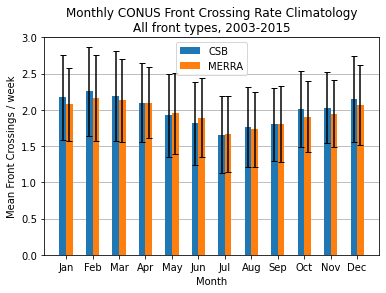

In [41]:
# monthly rate climatologies
fig, ax = plt.subplots()

w = 0.25
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

# settings to better compare to Jim's paper
ax.set_ylim(0,3);
ax.grid(True, axis='y', zorder=0)

position = x - (w/2)
ax.bar(position, (csb_mrates_clim_CONUS_mean*7)[:,4], yerr=(csb_mrates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CSB", color='C0', capsize=3, zorder=3)
position = x + (w/2)
ax.bar(position, (merra_mrates_clim_CONUS_mean*7)[:,4], yerr=(merra_mrates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="MERRA", color='C1', capsize=3, zorder=3)

ax.set_title('Monthly CONUS Front Crossing Rate Climatology\nAll front types, 2003-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Month')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend();

# use unmasked csb to compare with merra; masked csb to compare with Jim's paper
#plt.savefig('../figures/toSCP/csb_merra_mrates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

3.8511229
3.5443792
3.7501838
3.4144173
3.878943
3.5468225
3.6697323
3.0650887


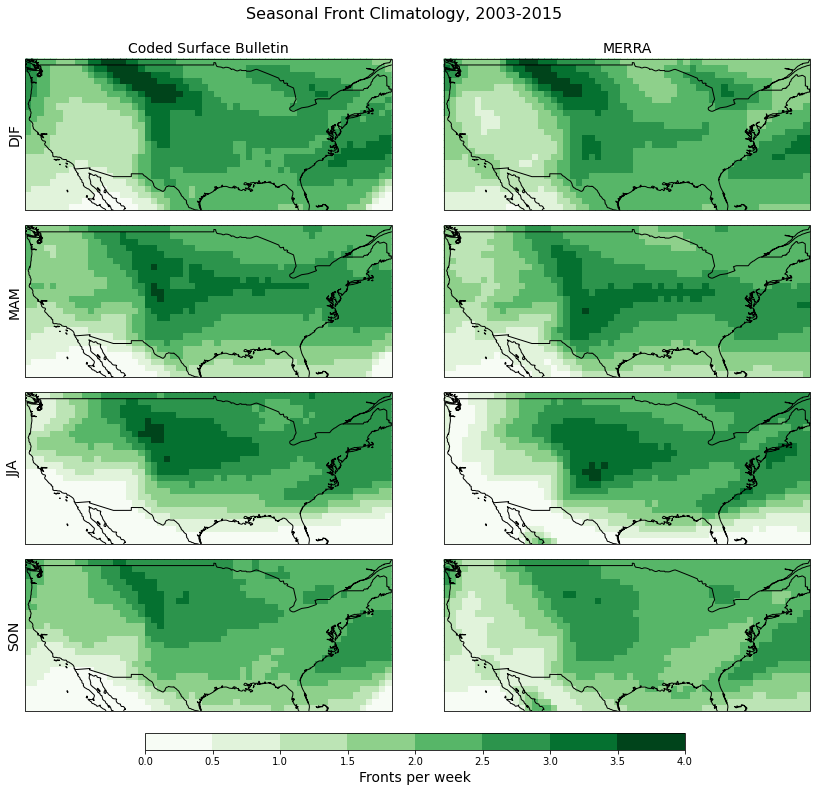

In [21]:
# spatial plots by season type
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 2, figsize=(15,12), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormap
cmap=plt.cm.get_cmap('Greens', 8)

for i in range(nsea):
    if i == 0:
        axs[i,0].set_title('Coded Surface Bulletin', fontsize=14) 
    field, lon = add_cyclic_point((csb_srates_clim_CONUS*7)[i,4,:,:], coord=csb_srates_clim_CONUS.lon)
    print(field.max())
    lat = csb_srates_clim_CONUS.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=4, transform=ccrs.PlateCarree())
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    #axs[i,0].add_feature(cfeature.STATES)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    fig.suptitle('Seasonal Front Crossing Rate Climatology, 2003-2015', fontsize=16, y=0.94)

for i in range(nsea):
    if i == 0:
        axs[i,1].set_title('MERRA', fontsize=14)
    field, lon = add_cyclic_point((merra_srates_clim_CONUS*7)[i,4,:,:], coord=merra_srates_clim_CONUS.lon)
    print(field.max())
    lat = merra_srates_clim_CONUS.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=4, transform=ccrs.PlateCarree())
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
cb_ax = fig.add_axes([0.26, 0.08, 0.5, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=4)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal')
cb1.ax.set_xlabel('Fronts per week', fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0.1)
#plt.savefig('../figures/toSCP/csb_merra_srates_clim_CONUS_viaPoly.png', bbox_inches='tight')

## Compare MERRA / CESM, 2000-2015

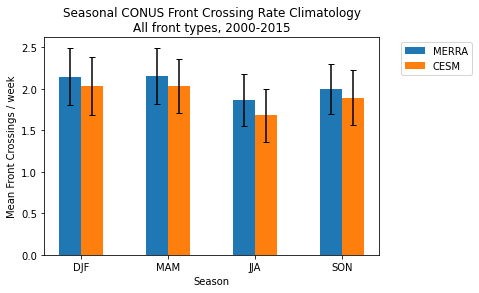

In [56]:
# seasonal rate climatologies
fig, ax = plt.subplots()

w = 0.25
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x - (w/2)
ax.bar(position, (merra_cesm_srates_clim_CONUS_mean*7)[:,4], yerr=(merra_cesm_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="MERRA", color='C0', capsize=3)
position = x + (w/2)
ax.bar(position, (cesm_full_srates_clim_CONUS_mean*7)[:,4], yerr=(cesm_full_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CESM", color='C1', capsize=3)

ax.set_title('Seasonal CONUS Front Crossing Rate Climatology\nAll front types, 2000-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend(bbox_to_anchor=(1.05, 1));
#plt.savefig('../figures/toSCP/merra_cesm_srates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

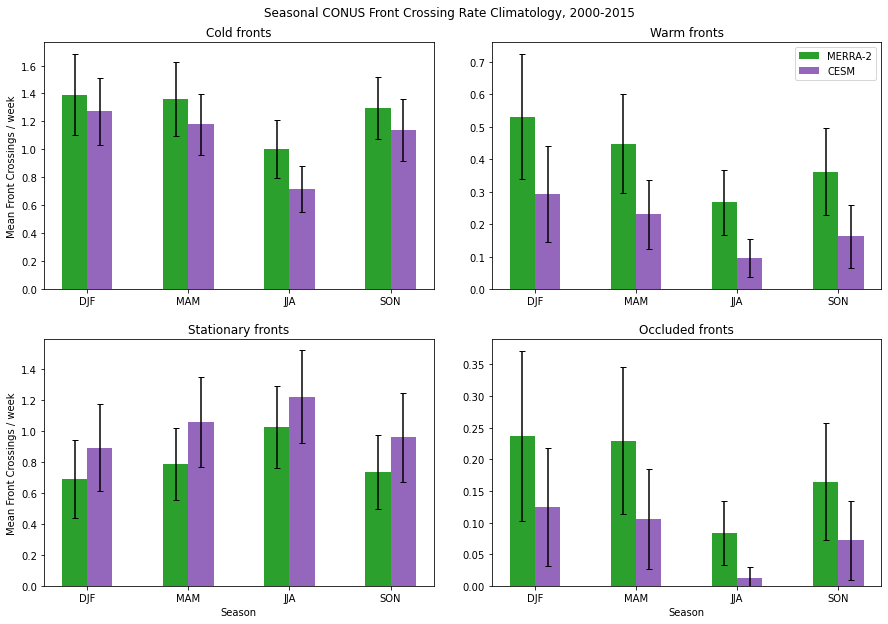

In [17]:
# by front type
frontstrings = ('Cold', 'Warm', 'Stationary', 'Occluded')
nfronts = len(frontstrings)
fig, ax = plt.subplots(2, 2, figsize=(15,10))
ax = ax.ravel()

for i in range(nfronts):
    w = 0.25
    labels = ['DJF', 'MAM', 'JJA', 'SON']
    nseason = len(labels)
    x = np.arange(nseason)  # the label locations

    position = x - (w/2)
    ax[i].bar(position, (merra_cesm_srates_clim_CONUS_mean*7)[:,i], yerr=(merra_cesm_srates_clim_stdev_CONUS_mean*7)[:,i], width=w, label="MERRA-2", color='C2', capsize=3)
    position = x + (w/2)
    ax[i].bar(position, (cesm_full_srates_clim_CONUS_mean*7)[:,i], yerr=(cesm_full_srates_clim_stdev_CONUS_mean*7)[:,i], width=w, label="CESM", color='C4', capsize=3)

    ax[i].set_title(frontstrings[i]+' fronts')  
    if i==0 or i==2:
        ax[i].set_ylabel('Mean Front Crossings / week')
    if i==2 or i==3:
        ax[i].set_xlabel('Season')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)
    ax[i].set_ylim(bottom=0)
    if i==1:
        ax[i].legend();
        
plt.subplots_adjust(wspace=0.15, hspace=0.20)

fig.suptitle('Seasonal CONUS Front Crossing Rate Climatology, 2000-2015', y=0.93);

#plt.savefig('../figures/toSCP/merra_cesm_srates_clim_CONUS_mean_wk_byfronttype_stdev.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/merra_cesm_srates_clim_CONUS_mean_wk_byfronttype_stdev_altcolors.png', bbox_inches='tight')

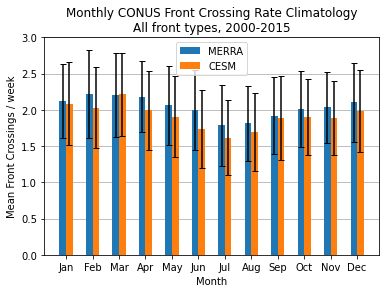

In [50]:
# monthly rate climatologies
fig, ax = plt.subplots()

w = 0.25
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

# settings to better compare to Jim's paper
ax.set_ylim(0,3);
ax.grid(True, axis='y', zorder=0)

position = x - (w/2)
ax.bar(position, (merra_cesm_mrates_clim_CONUS_mean*7)[:,4], yerr=(merra_cesm_mrates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="MERRA", color='C0', capsize=3, zorder=3)
position = x + (w/2)
ax.bar(position, (cesm_full_mrates_clim_CONUS_mean*7)[:,4], yerr=(cesm_full_mrates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CESM", color='C1', capsize=3, zorder=3)

ax.set_title('Monthly CONUS Front Crossing Rate Climatology\nAll front types, 2000-2015')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Month')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend();

#plt.savefig('../figures/toSCP/merra_cesm_mrates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

3.58241
3.752038
3.7805705
3.2932692
3.3058424
3.3050272
3.433424
2.8653846


/glade/scratch/kdagon/ipykernel_8794/3966235589.py:46: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal')


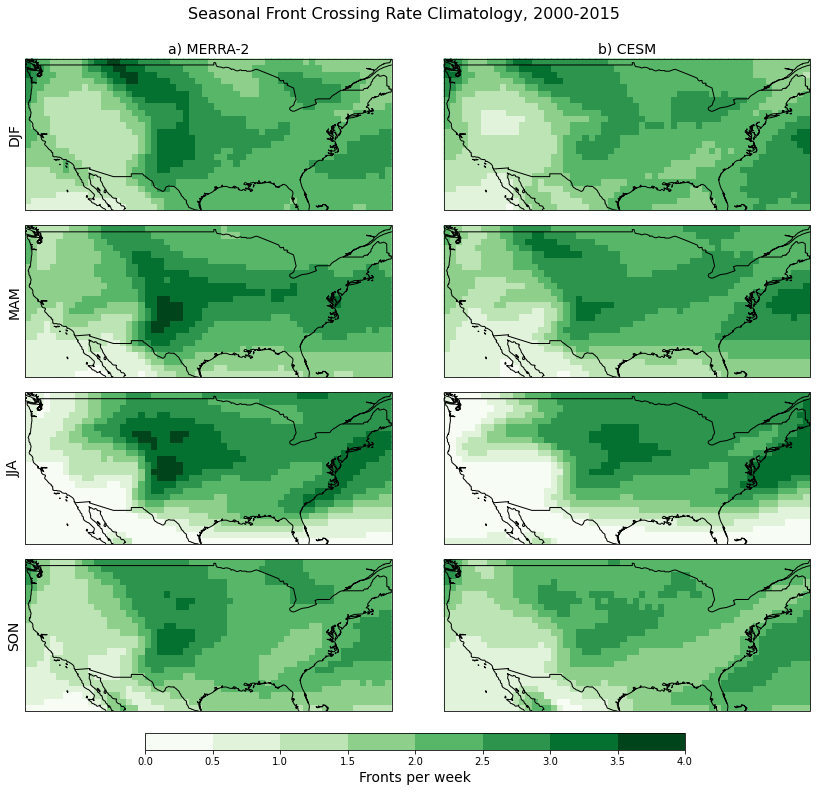

In [21]:
# spatial plots by season type
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 2, figsize=(15,12), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormap
cmap=plt.cm.get_cmap('Greens', 8)
vmax=4
#cmap=plt.cm.get_cmap('Greens', 6)
#vmax=3

for i in range(nsea):
    if i == 0:
        axs[i,0].set_title('a) MERRA-2', fontsize=14)
    # POLYLINES
    field, lon = add_cyclic_point((merra_cesm_srates_clim_CONUS*7)[i,4,:,:], coord=merra_cesm_srates_clim_CONUS.lon)
    print(field.max())
    lat = merra_cesm_srates_clim_CONUS.lat
    # ONE-HOT
    #field, lon = add_cyclic_point((merra_cesm_OH_srates_clim_CONUS*7)[i,4,:,:], coord=merra_cesm_OH_srates_clim_CONUS.lon)
    #lat = merra_cesm_OH_srates_clim_CONUS.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    fig.suptitle('Seasonal Front Crossing Rate Climatology, 2000-2015', fontsize=16, y=0.94)

    
for i in range(nsea):
    if i == 0:
        axs[i,1].set_title('b) CESM', fontsize=14)
    # POYLINES
    field, lon = add_cyclic_point((cesm_full_srates_clim_CONUS*7)[i,4,:,:], coord=cesm_full_srates_clim_CONUS.lon)
    print(field.max())
    lat = cesm_full_srates_clim_CONUS.lat
    # ONE-HOT
    #field, lon = add_cyclic_point((cesm_OH_full_srates_clim_CONUS*7)[i,4,:,:], coord=cesm_OH_full_srates_clim_CONUS.lon)
    #lat = cesm_OH_full_srates_clim_CONUS.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
cb_ax = fig.add_axes([0.26, 0.08, 0.5, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal')
cb1.ax.set_xlabel('Fronts per week', fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0.1)
#plt.savefig('../figures/toSCP/merra_cesm_srates_clim_CONUS_viaPoly.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/merra_cesm_srates_clim_CONUS_viaOH.png', bbox_inches='tight')

## Combine CSB/MERRA/CESM spatial plots 

3.8511229
3.5443792
3.7501838
3.4144173
3.58241
3.752038
3.7805705
3.2932692
3.3058424
3.3050272
3.433424
2.8653846


/glade/scratch/kdagon/ipykernel_679/1970068856.py:47: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal')


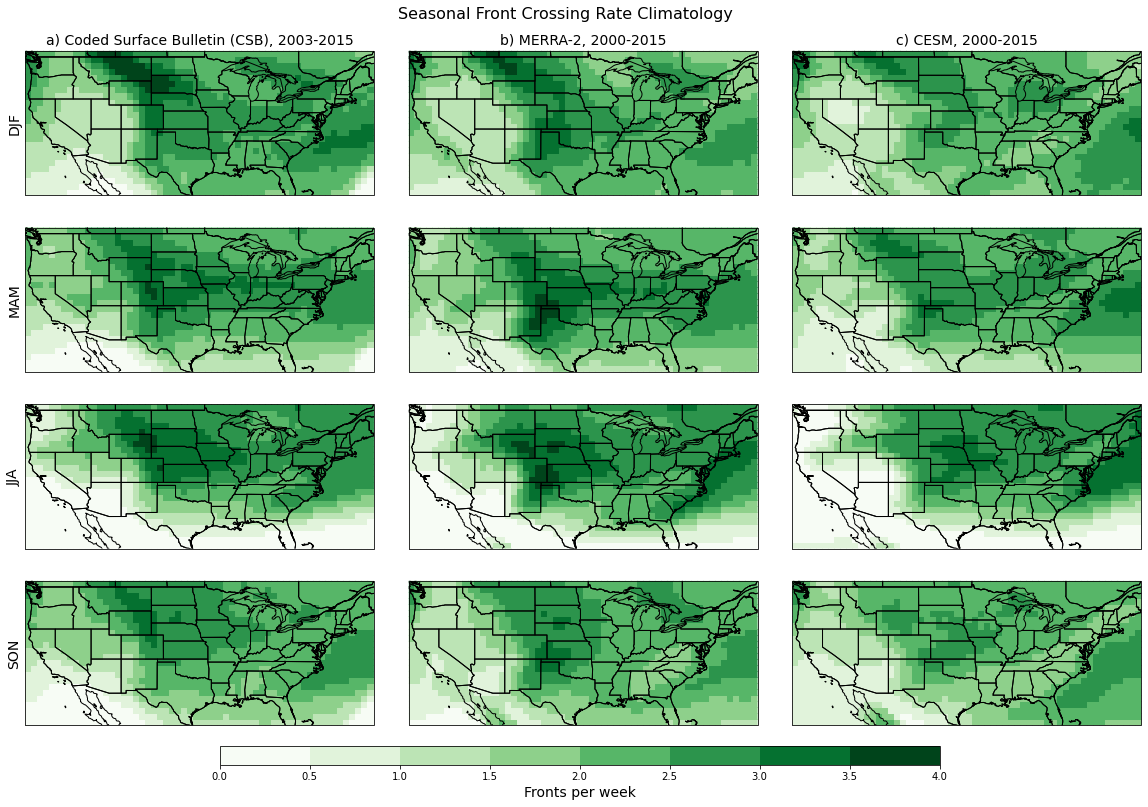

In [24]:
# spatial plots by season type
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormap
cmap=plt.cm.get_cmap('Greens', 8)
vmax=4 # for absolute plots

for i in range(nsea):
    if i == 0:
        axs[i,0].set_title('a) Coded Surface Bulletin (CSB), 2003-2015', fontsize=14) 
    field, lon = add_cyclic_point((csb_srates_clim_CONUS*7)[i,4,:,:], coord=csb_srates_clim_CONUS.lon)
    print(field.max())
    lat = csb_srates_clim_CONUS.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree()) # trying to get rid of the white border, does slow down a bit
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].add_feature(cfeature.STATES)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])

for i in range(nsea):
    if i == 0:
        axs[i,1].set_title('b) MERRA-2, 2000-2015', fontsize=14)
    field, lon = add_cyclic_point((merra_cesm_srates_clim_CONUS*7)[i,4,:,:], coord=merra_cesm_srates_clim_CONUS.lon)
    print(field.max())
    lat = merra_cesm_srates_clim_CONUS.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    axs[i,1].add_feature(cfeature.STATES)

for i in range(nsea):
    if i == 0:
        axs[i,2].set_title('c) CESM, 2000-2015', fontsize=14)
    field, lon = add_cyclic_point((cesm_full_srates_clim_CONUS*7)[i,4,:,:], coord=cesm_full_srates_clim_CONUS.lon)
    print(field.max())
    lat = cesm_full_srates_clim_CONUS.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)
    axs[i,2].add_feature(cfeature.STATES)
    
cb_ax = fig.add_axes([0.26, 0.1, 0.5, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal')
cb1.ax.set_xlabel('Fronts per week', fontsize=14)

fig.suptitle('Seasonal Front Crossing Rate Climatology', fontsize=16, y=0.91)

plt.subplots_adjust(wspace=0.1, hspace=0)
#plt.savefig('../figures/toSCP/csb_cesm_merra_srates_clim_CONUS_viaPoly.png', bbox_inches='tight', dpi=300)

In [38]:
csb_arates_mean_CONUS

<xarray.DataArray 'total_rate' (total: 1, front: 5, lat: 25, lon: 58)>
array([[[[0.046249, ..., 0.018881],
         ...,
         [0.123684, ..., 0.153173]],

        ...,

        [[0.047522, ..., 0.025034],
         ...,
         [0.306558, ..., 0.295314]]]], dtype=float32)
Coordinates:
  * lat         (lat) float64 26.0 27.0 28.0 29.0 30.0 ... 47.0 48.0 49.0 50.0
  * lon         (lon) float64 -125.0 -124.0 -123.0 -122.0 ... -70.0 -69.0 -68.0
    front_type  (front) object 'cold' 'warm' 'stationary' 'occluded' 'all'
Dimensions without coordinates: total, front
Attributes:
    long_name:     Total Frontal Boundary Crossing Rate
    cell_methods:  time: mean (over all years)
    valid_min:     0
    valid_max:     366
    grid_mapping:  crs
    units:         counts day-1

### Repeat the above comparison by front type (mean annual rates)

/glade/scratch/kdagon/ipykernel_211821/1910625426.py:100: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb2 = mpl.colorbar.ColorbarBase(cb_ax2, cmap2, norm=norm2, orientation='vertical')


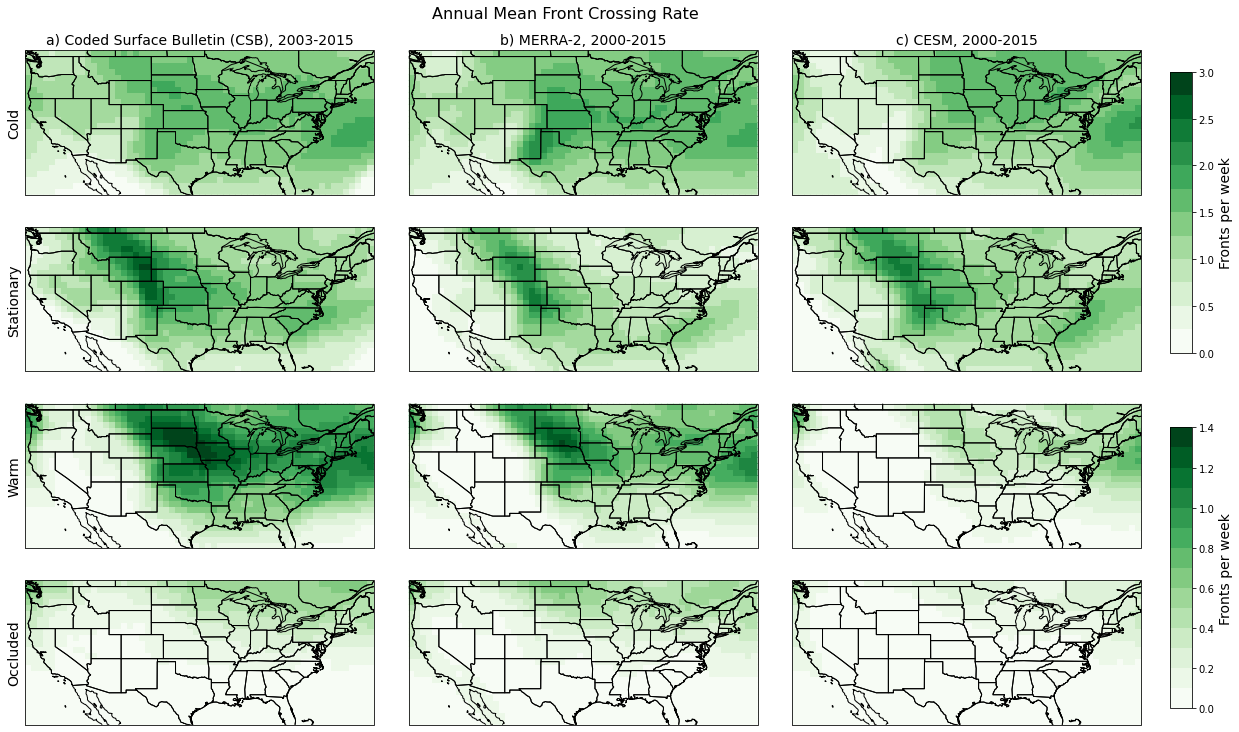

In [81]:
# spatial plots by front type
frontstrings = ('Cold', 'Stationary', 'Warm', 'Occluded')
nf = len(frontstrings)
fig, axs = plt.subplots(nf, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormaps
cmap1=plt.cm.get_cmap('Greens', 12)
cmap2=plt.cm.get_cmap('Greens', 14)

vmax1=3
vmax2=1.4

for i in range(nf):
    if i == 0:
        axs[i,0].set_title('a) Coded Surface Bulletin (CSB), 2003-2015', fontsize=14)
        index=0
        vmax=vmax1
        cmap=cmap1
    if i == 1:
        index=2 # shifting the plotting order
        vmax=vmax1
        cmap=cmap1
    if i == 2:
        index=1
        vmax=vmax2
        cmap=cmap2
    if i ==3:
        index=3
        vmax=vmax2
        cmap=cmap2
    field, lon = add_cyclic_point((csb_arates_mean_CONUS*7)[0,index,:,:], coord=csb_arates_mean_CONUS.lon)
    #print(field.max())
    lat = csb_arates_mean_CONUS.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree()) # trying to get rid of the white border, does slow down a bit
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].add_feature(cfeature.STATES)
    axs[i,0].set_ylabel(frontstrings[i], fontsize=14)
    axs[i,0].set_yticks([])

for i in range(nf):
    if i == 0:
        axs[i,1].set_title('b) MERRA-2, 2000-2015', fontsize=14)
        index=0
        vmax=vmax1
        cmap=cmap1
    if i == 1:
        index=2 # shifting the plotting order
        vmax=vmax1
        cmap=cmap1
    if i == 2:
        index=1
        vmax=vmax2
        cmap=cmap2
    if i ==3:
        index=3
        vmax=vmax2
        cmap=cmap2
    field, lon = add_cyclic_point((merra_cesm_arates_mean_CONUS*7)[0,index,:,:], coord=merra_cesm_arates_mean_CONUS.lon)
    #print(field.max())
    lat = merra_cesm_arates_mean_CONUS.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    axs[i,1].add_feature(cfeature.STATES)

for i in range(nf):
    if i == 0:
        axs[i,2].set_title('c) CESM, 2000-2015', fontsize=14)
        index=0
        vmax=vmax1
        cmap=cmap1
    if i == 1:
        index=2 # shifting the plotting order
        vmax=vmax1
        cmap=cmap1
    if i == 2:
        index=1
        vmax=vmax2
        cmap=cmap2
    if i ==3:
        index=3
        vmax=vmax2
        cmap=cmap2
    field, lon = add_cyclic_point((cesm_full_arates_mean_CONUS*7)[0,index,:,:], coord=cesm_full_arates_mean_CONUS.lon)
    #print(field.max())
    lat = cesm_full_arates_mean_CONUS.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)
    axs[i,2].add_feature(cfeature.STATES)
    
cb_ax1 = fig.add_axes([0.92, 0.54, 0.015, 0.3])
norm1 = mpl.colors.Normalize(vmin=0, vmax=vmax1)
cb1 = mpl.colorbar.ColorbarBase(ax=cb_ax1, cmap=cmap1, norm=norm1, orientation='vertical')
cb1.ax.set_ylabel('Fronts per week', fontsize=14)

cb_ax2 = fig.add_axes([0.92, 0.16, 0.015, 0.3])
norm2 = mpl.colors.Normalize(vmin=0, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb_ax2, cmap2, norm=norm2, orientation='vertical')
cb2.ax.set_ylabel('Fronts per week', fontsize=14)


fig.suptitle('Annual Mean Front Crossing Rate', fontsize=16, y=0.91)
#fig.tight_layout()

plt.subplots_adjust(wspace=0.1, hspace=0)
#plt.savefig('../figures/toSCP/csb_cesm_merra_arates_mean_CONUS_viaPoly_2colorbars.png', bbox_inches='tight', dpi=300)

## Compare CESM, present/future

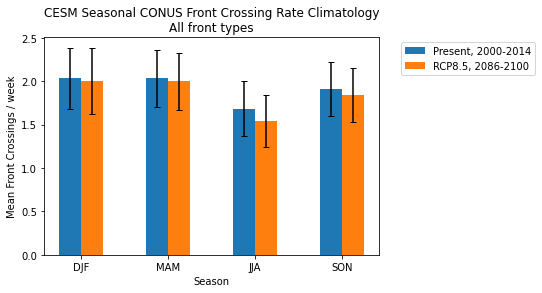

In [22]:
# seasonal rate climatologies
fig, ax = plt.subplots()

w = 0.25
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

position = x - (w/2)
#ax.bar(position, (cesm_OH_full_srates_clim_CONUS_mean*7)[:,4], yerr=(cesm_OH_full_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="Present, 2000-2015", color='C0', capsize=3)
ax.bar(position, (cesm_fullmod_srates_clim_CONUS_mean*7)[:,4], yerr=(cesm_fullmod_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="Present, 2000-2014", color='C0', capsize=3)
position = x + (w/2)
#ax.bar(position, (cesm_OH_rcp85_srates_clim_CONUS_mean*7)[:,4], yerr=(cesm_OH_rcp85_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="RCP8.5, 2086-2100", color='C1', capsize=3)
ax.bar(position, (cesm_rcp85_srates_clim_CONUS_mean*7)[:,4], yerr=(cesm_rcp85_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="RCP8.5, 2086-2100", color='C1', capsize=3)

ax.set_title('CESM Seasonal CONUS Front Crossing Rate Climatology\nAll front types')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Season')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend(bbox_to_anchor=(1.05, 1));
#plt.savefig('../figures/toSCP/cesm_hist_rcp85_OH_srates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/cesm_hist_rcp85_srates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

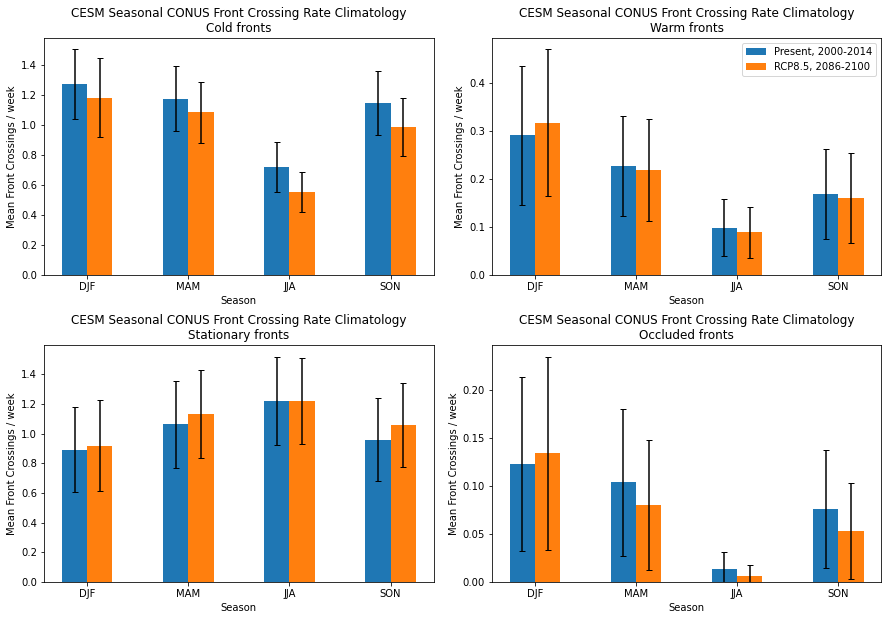

In [25]:
# by front type
frontstrings = ('Cold', 'Warm', 'Stationary', 'Occluded')
nfronts = len(frontstrings)
fig, ax = plt.subplots(2, 2, figsize=(15,10))
ax = ax.ravel()

for i in range(nfronts):
    w = 0.25
    labels = ['DJF', 'MAM', 'JJA', 'SON']
    nseason = len(labels)
    x = np.arange(nseason)  # the label locations

    position = x - (w/2)
    #ax[i].bar(position, (cesm_OH_full_srates_clim_CONUS_mean*7)[:,i], yerr=(cesm_OH_full_srates_clim_stdev_CONUS_mean*7)[:,i], width=w, label="Present, 2000-2015", color='C0', capsize=3)
    ax[i].bar(position, (cesm_fullmod_srates_clim_CONUS_mean*7)[:,i], yerr=(cesm_fullmod_srates_clim_stdev_CONUS_mean*7)[:,i], width=w, label="Present, 2000-2014", color='C0', capsize=3)

    position = x + (w/2)
    #ax[i].bar(position, (cesm_OH_rcp85_srates_clim_CONUS_mean*7)[:,i], yerr=(cesm_OH_rcp85_srates_clim_stdev_CONUS_mean*7)[:,i], width=w, label="RCP8.5, 2086-2100", color='C1', capsize=3)
    ax[i].bar(position, (cesm_rcp85_srates_clim_CONUS_mean*7)[:,i], yerr=(cesm_rcp85_srates_clim_stdev_CONUS_mean*7)[:,i], width=w, label="RCP8.5, 2086-2100", color='C1', capsize=3)
  
    ax[i].set_title('CESM Seasonal CONUS Front Crossing Rate Climatology\n'+frontstrings[i]+' fronts')
    ax[i].set_ylabel('Mean Front Crossings / week')
    ax[i].set_xlabel('Season')
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(labels)
    ax[i].set_ylim(bottom=0)

    if i==1:
        ax[i].legend();
        
plt.subplots_adjust(wspace=0.15, hspace=0.3)
#plt.savefig('../figures/toSCP/cesm_hist_rcp85_OH_srates_clim_CONUS_mean_wk_byfronttype_stdev.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/cesm_hist_rcp85_srates_clim_CONUS_mean_wk_byfronttype_stdev.png', bbox_inches='tight')

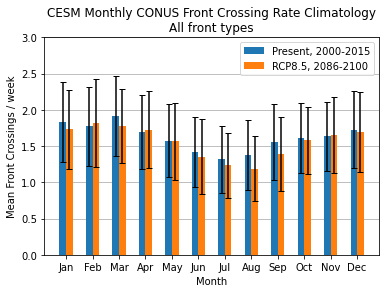

In [64]:
# monthly rate climatologies
fig, ax = plt.subplots()

w = 0.25
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

# settings to better compare to Jim's paper
ax.set_ylim(0,3);
ax.grid(True, axis='y', zorder=0)

position = x - (w/2)
ax.bar(position, (cesm_OH_full_mrates_clim_CONUS_mean*7)[:,4], yerr=(cesm_OH_full_mrates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="Present, 2000-2015", color='C0', capsize=3, zorder=3)
#ax.bar(position, (cesm_fullmod_mrates_clim_CONUS_mean*7)[:,4], yerr=(cesm_fullmod_mrates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="Present, 2000-2014", color='C0', capsize=3, zorder=3)
position = x + (w/2)
ax.bar(position, (cesm_OH_rcp85_mrates_clim_CONUS_mean*7)[:,4], yerr=(cesm_OH_rcp85_mrates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="RCP8.5, 2086-2100", color='C1', capsize=3, zorder=3)
#ax.bar(position, (cesm_rcp85_mrates_clim_CONUS_mean*7)[:,4], yerr=(cesm_rcp85_mrates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="RCP8.5, 2086-2100", color='C1', capsize=3, zorder=3)

ax.set_title('CESM Monthly CONUS Front Crossing Rate Climatology\nAll front types')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xlabel('Month')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend();

#plt.savefig('../figures/toSCP/cesm_hist_rcp85_OH_mrates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/cesm_hist_rcp85_mrates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

3.2877119
3.3326087
3.4086955
2.8666668
3.6037035
3.2869565
3.936232
2.9282053


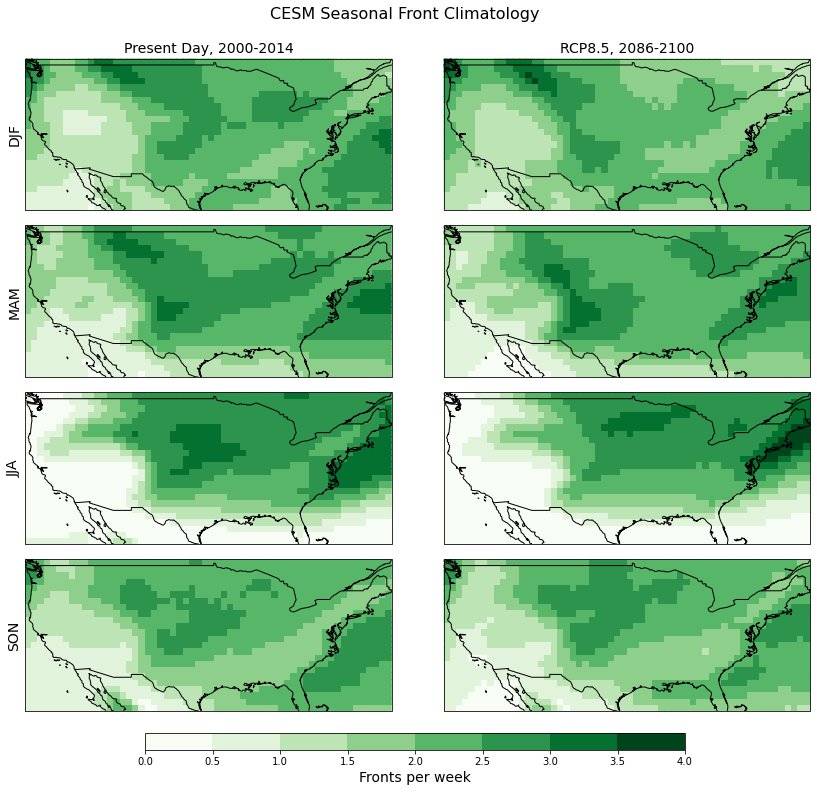

In [23]:
# spatial plots by season type
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 2, figsize=(15,12), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormap
cmap=plt.cm.get_cmap('Greens', 8)
vmax=4 # polylines
#vmax=3 # OH

for i in range(nsea):
    if i == 0:
        #axs[i,0].set_title('Present Day, 2000-2015', fontsize=14) 
        axs[i,0].set_title('Present Day, 2000-2014', fontsize=14) 
    # OH, 2000-2015
    #field, lon = add_cyclic_point((cesm_OH_full_srates_clim_CONUS*7)[i,4,:,:], coord=cesm_OH_full_srates_clim_CONUS.lon)
    #lat = cesm_OH_full_srates_clim_CONUS.lat
    # PL, 2000-2014
    field, lon = add_cyclic_point((cesm_fullmod_srates_clim_CONUS*7)[i,4,:,:], coord=cesm_fullmod_srates_clim_CONUS.lon)
    print(field.max())
    lat = cesm_fullmod_srates_clim_CONUS.lat
    # OH, 2000-2014
    #field, lon = add_cyclic_point((cesm_OH_fullmod_srates_clim_CONUS*7)[i,4,:,:], coord=cesm_OH_fullmod_srates_clim_CONUS.lon)
    #lat = cesm_OH_fullmod_srates_clim_CONUS.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    fig.suptitle('CESM Seasonal Front Climatology', fontsize=16, y=0.94)

    
for i in range(nsea):
    if i == 0:
        axs[i,1].set_title('RCP8.5, 2086-2100', fontsize=14)
    #field, lon = add_cyclic_point((cesm_OH_rcp85_srates_clim_CONUS*7)[i,4,:,:], coord=cesm_OH_rcp85_srates_clim_CONUS.lon)
    #lat = cesm_OH_rcp85_srates_clim_CONUS.lat
    field, lon = add_cyclic_point((cesm_rcp85_srates_clim_CONUS*7)[i,4,:,:], coord=cesm_rcp85_srates_clim_CONUS.lon)
    print(field.max())
    lat = cesm_rcp85_srates_clim_CONUS.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    
cb_ax = fig.add_axes([0.26, 0.08, 0.5, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal')
cb1.ax.set_xlabel('Fronts per week', fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0.1)
#plt.savefig('../figures/toSCP/cesm_hist_rcp85_srates_clim_CONUS_viaPoly.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/cesm_hist_rcp85_srates_clim_CONUS_viaOH_15yr.png', bbox_inches='tight')

0.69465435
-0.7468665
0.62391305
-0.73550725
0.90289843
-1.1413043
0.39999998
-0.7076923


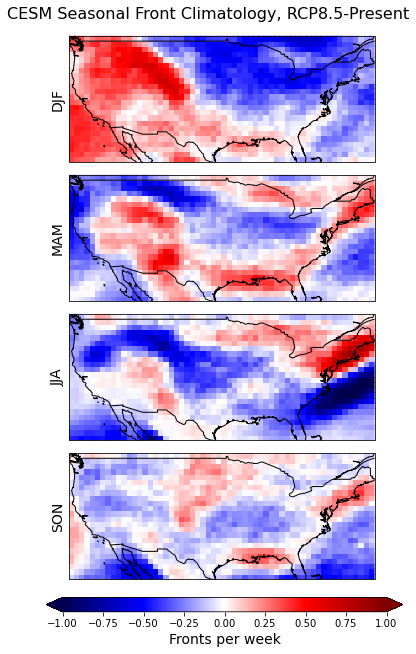

In [11]:
# different plots (spatial/seasonal)
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 1, figsize=(15,10), subplot_kw={'projection': ccrs.PlateCarree()})

# colormap
cmap = plt.cm.get_cmap('seismic')

# PL, 2086-2100 - 2000-2014
cesm_srates_clim_CONUS_diff = cesm_rcp85_srates_clim_CONUS - cesm_fullmod_srates_clim_CONUS
#print(cesm_srates_clim_CONUS_diff.max())
#print(cesm_srates_clim_CONUS_diff.min())

for i in range(nsea):
    field, lon = add_cyclic_point((cesm_srates_clim_CONUS_diff*7)[i,4,:,:], coord=cesm_srates_clim_CONUS_diff.lon)
    print(field.max())
    print(field.min())
    lat = cesm_srates_clim_CONUS_diff.lat
    cf = axs[i].pcolor(lon, lat, field, cmap=cmap, vmin=-1, vmax=1, transform=ccrs.PlateCarree())
    axs[i].coastlines()
    axs[i].add_feature(cfeature.BORDERS)
    axs[i].set_ylabel(seastrings[i], fontsize=14)
    axs[i].set_yticks([])
    fig.suptitle('CESM Seasonal Front Climatology, RCP8.5-Present', fontsize=16, y=0.92)

cb_ax = fig.add_axes([0.35, 0.08, 0.33, 0.02])

# one way of doing a colorbar from scratch
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal', extend='both')
cb1.ax.set_xlabel('Fronts per week', fontsize=14)

# simpler way? referencing cf -- but the last iteration of cf only? Doesn't appear to change results from the above method
#cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal', extend='both')
#cbar.ax.set_xlabel('Fronts per week', fontsize=14)

plt.subplots_adjust(wspace=0, hspace=0.1)
#plt.savefig('../figures/toSCP/cesm_hist_rcp85_srates_clim_CONUS_viaPoly_diff.png', bbox_inches='tight')

### 12-panel plot with difference as third column

In [26]:
cesm_srates_clim_CONUS_diff = cesm_rcp85_srates_clim_CONUS - cesm_fullmod_srates_clim_CONUS

/glade/scratch/kdagon/ipykernel_679/154501422.py:35: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal')
/glade/scratch/kdagon/ipykernel_679/154501422.py:55: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap2, norm=norm2, orientation='horizontal', extend='both')


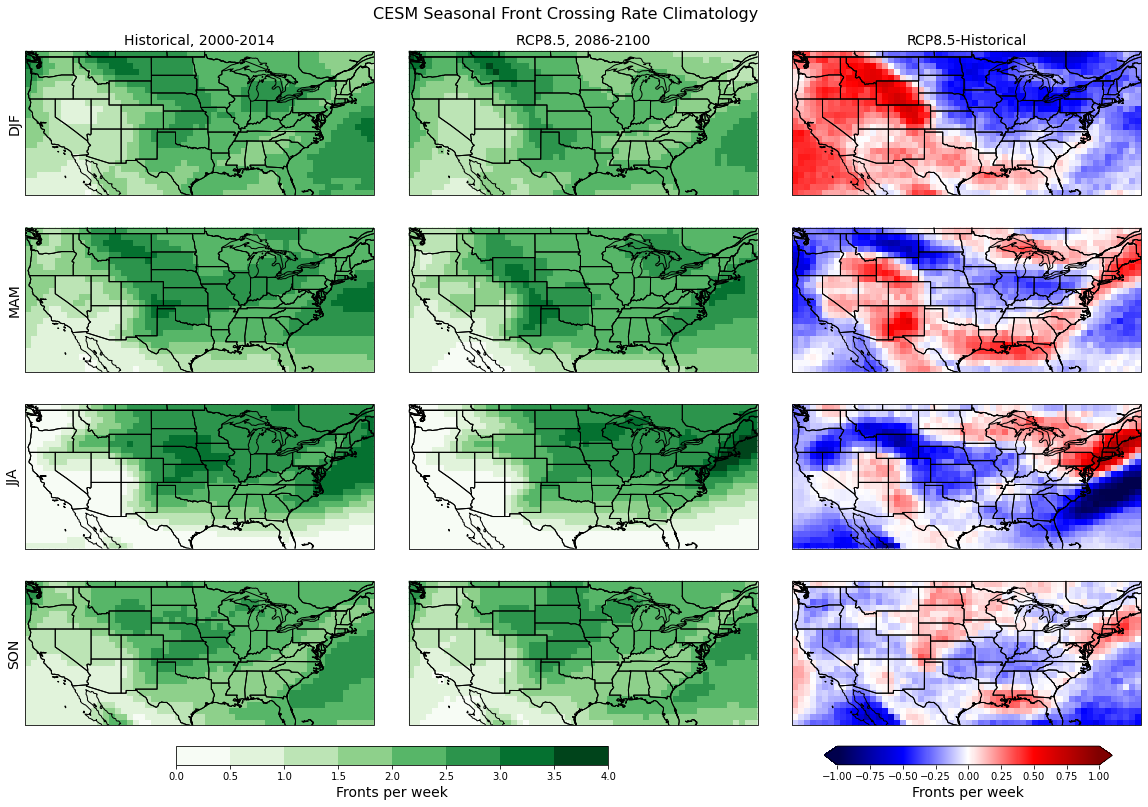

In [28]:
# spatial plots by season type
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormap
cmap=plt.cm.get_cmap('Greens', 8)
vmax=4 # for absolute plots

for i in range(nsea):
    if i == 0:
        axs[i,0].set_title('Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point((cesm_fullmod_srates_clim_CONUS*7)[i,4,:,:], coord=cesm_fullmod_srates_clim_CONUS.lon)
    lat = cesm_fullmod_srates_clim_CONUS.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].add_feature(cfeature.STATES)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    
for i in range(nsea):
    if i == 0:
        axs[i,1].set_title('RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point((cesm_rcp85_srates_clim_CONUS*7)[i,4,:,:], coord=cesm_rcp85_srates_clim_CONUS.lon)
    lat = cesm_rcp85_srates_clim_CONUS.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    axs[i,1].add_feature(cfeature.STATES)
    
# colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.1, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal')
cb1.ax.set_xlabel('Fronts per week', fontsize=14)

# different plot
cmap2 = plt.cm.get_cmap('seismic')
for i in range(nsea):
    if i==0:
        axs[i,2].set_title('RCP8.5-Historical', fontsize=14)
    field, lon = add_cyclic_point((cesm_srates_clim_CONUS_diff*7)[i,4,:,:], coord=cesm_srates_clim_CONUS_diff.lon)
    lat = cesm_srates_clim_CONUS_diff.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=-1, vmax=1, transform=ccrs.PlateCarree())
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)
    axs[i,2].add_feature(cfeature.STATES)
    #axs[i,2].set_ylabel(seastrings[i], fontsize=14)
    #axs[i,2].set_yticks([])

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.1, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=-1, vmax=1)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('Fronts per week', fontsize=14)

plt.subplots_adjust(wspace=0.1, hspace=0)
fig.suptitle('CESM Seasonal Front Crossing Rate Climatology', fontsize=16, y=0.91);

#plt.savefig('../figures/toSCP/cesm_hist_rcp85_diff_srates_clim_CONUS_viaPoly.png', bbox_inches='tight', dpi=300)

### Get the standard deviations for the diff plot

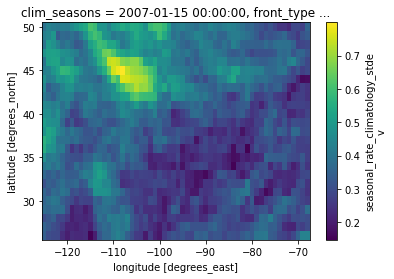

In [18]:
# using historical simulation for the stdevs
# NOTE: if I do this here, I should do it for the individual front types (SI figs)
#cesm_fullmod_srates_clim_stdev_CONUS # historical stdevs
#cesm_rcp85_srates_clim_stdev_CONUS # RCP8.5 stdevs
(cesm_fullmod_srates_clim_stdev_CONUS*7)[0,4,:,:].plot() # DJF stdev in per wk, would want to try and hatch over where diff plot is greater than this field

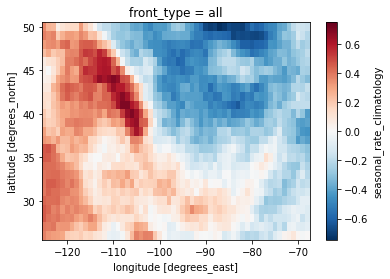

In [19]:
# DJF diff plot
(cesm_srates_clim_CONUS_diff*7)[0,4,:,:].plot()

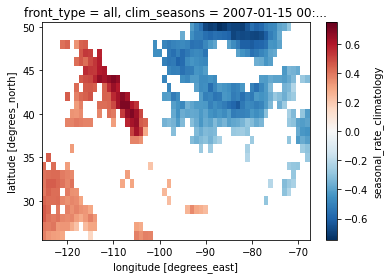

In [20]:
# select where magnitude (abs) of diff is greater than standard deviation from historical simulation
# or, should I do some sort of t-test on the diff at each grid point, ignoring the stdevs?
test = (cesm_srates_clim_CONUS_diff*7)[0,4,:,:].where(abs((cesm_srates_clim_CONUS_diff*7)[0,4,:,:]) > (cesm_fullmod_srates_clim_stdev_CONUS*7)[0,4,:,:])
test.plot()

In [22]:
# look at the spatial mean values - they are pretty similar across hist/rcp8.5
print((cesm_fullmod_srates_clim_stdev_CONUS_mean*7)[:,4])

<xarray.DataArray 'seasonal_rate_climatology_stdev' (seasons4: 4)>
array([0.34845334, 0.33048713, 0.31790767, 0.3143676 ])
Coordinates:
    clim_seasons  (seasons4) object 2007-01-15 00:00:00 ... 2007-10-15 00:00:00
    front_type    object 'all'
Dimensions without coordinates: seasons4


In [23]:
print((cesm_rcp85_srates_clim_stdev_CONUS_mean*7)[:,4])

<xarray.DataArray 'seasonal_rate_climatology_stdev' (seasons4: 4)>
array([0.37967515, 0.32784941, 0.30219927, 0.31015433])
Coordinates:
    clim_seasons  (seasons4) object 2093-01-15 00:00:00 ... 2093-10-15 00:00:00
    front_type    object 'all'
Dimensions without coordinates: seasons4


In [24]:
cesm_srates_clim_CONUS_diff

<xarray.DataArray 'seasonal_rate_climatology' (seasons4: 4, front: 5, lat: 25, lon: 58)>
array([[[[ 4.81384844e-02,  4.29533571e-02,  3.92500609e-02, ...,
          -1.70589834e-02, -1.40958279e-02, -5.20624220e-03],
         [ 4.51744199e-02,  4.66560349e-02,  4.96194065e-02, ...,
          -3.03942412e-02, -2.29862779e-02, -2.07641870e-02],
         [ 5.18402457e-02,  4.66553420e-02,  5.03593907e-02, ...,
          -1.85425878e-02, -2.44692713e-02, -1.85427368e-02],
         ...,
         [-1.18645281e-02, -1.70482844e-02, -1.48237348e-02, ...,
          -3.18646729e-02, -4.14939001e-02, -3.11219469e-02],
         [-8.15823674e-03, -7.41542876e-03, -8.89575481e-03, ...,
          -3.63085717e-02, -3.18635106e-02, -3.70478779e-02],
         [-4.45246696e-03, -4.45102900e-03, -2.96824425e-03, ...,
          -3.33442464e-02, -3.48256528e-02, -3.63065898e-02]],

        [[ 3.70329153e-03,  2.96262023e-03,  4.44423873e-03, ...,
           1.48141980e-02,  1.55548006e-02,  1.25915641e-02],
         [ 5.92544582e-03,  4.44396399e-03,  5.18477336e-03, ...,
           2.14805901e-02,  1.92583669e-02,  1.99988335e-02],
         [ 1.18511654e-02,  1.48141980e-02,  1.25919748e-02, ...,
           2.14799028e-02,  2.07390245e-02,  2.44427957e-02],
...
          -1.24542117e-02, -1.61172170e-02, -1.68498177e-02],
         [-2.19780207e-03, -1.17216110e-02, -1.31868124e-02, ...,
          -8.05860758e-03, -1.53846145e-02, -1.09890103e-02],
         [-5.86081296e-03, -9.52380896e-03, -1.31868124e-02, ...,
          -5.86080551e-03, -8.05860758e-03, -9.52380896e-03]],

        [[-1.24542117e-02, -2.05128193e-02, -3.29670310e-02, ...,
          -6.08058721e-02, -6.37362748e-02, -7.03296810e-02],
         [ 2.19780207e-03, -9.52380896e-03, -1.53846145e-02, ...,
          -5.05494624e-02, -5.71428686e-02, -6.81318790e-02],
         [ 9.52380896e-03,  3.66300344e-03, -6.59340620e-03, ...,
          -5.27472496e-02, -5.64102530e-02, -5.71428537e-02],
         ...,
         [ 8.79120827e-03,  4.39560413e-03, -1.17216110e-02, ...,
          -1.46520138e-02, -1.53846145e-02, -6.59340620e-03],
         [ 8.79120827e-03,  2.19780207e-03, -5.12820482e-03, ...,
          -2.93040276e-03, -1.24542117e-02, -1.31868124e-02],
         [ 1.39194131e-02,  2.34432220e-02,  4.39560413e-03, ...,
          -1.46520138e-03,  5.12820482e-03,  1.46520138e-03]]]],
      dtype=float32)
Coordinates:
  * lat         (lat) float64 26.0 27.0 28.0 29.0 30.0 ... 47.0 48.0 49.0 50.0
  * lon         (lon) float64 -125.0 -124.0 -123.0 -122.0 ... -70.0 -69.0 -68.0
    front_type  (front) object 'cold' 'warm' 'stationary' 'occluded' 'all'
Dimensions without coordinates: seasons4, front

In [25]:
# this creates a copy of the diffs with non-significant points withheld, but I really want something with a toggle whether to hatch there
cesm_srates_clim_CONUS_diff_sig = cesm_srates_clim_CONUS_diff.where(abs(cesm_srates_clim_CONUS_diff) > cesm_fullmod_srates_clim_stdev_CONUS)
cesm_srates_clim_CONUS_diff_sig

<xarray.DataArray 'seasonal_rate_climatology' (seasons4: 4, front: 5, lat: 25, lon: 58)>
array([[[[ 0.04813848,  0.04295336,  0.03925006, ...,         nan,
                  nan,         nan],
         [ 0.04517442,  0.04665603,  0.04961941, ..., -0.03039424,
                  nan,         nan],
         [ 0.05184025,  0.04665534,  0.05035939, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
          -0.0414939 ,         nan],
         [        nan,         nan,         nan, ..., -0.03630857,
          -0.03186351, -0.03704788],
         [        nan,         nan,         nan, ..., -0.03334425,
          -0.03482565, -0.03630659]],

        [[        nan,         nan,  0.00444424, ...,  0.0148142 ,
           0.0155548 ,         nan],
         [        nan,         nan,         nan, ...,  0.02148059,
           0.01925837,  0.01999883],
         [        nan,  0.0148142 ,  0.01259197, ...,  0.0214799 ,
                  nan,  0.0244428 ],
...
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan, -0.07032968],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]], dtype=float32)
Coordinates:
  * lat           (lat) float64 26.0 27.0 28.0 29.0 30.0 ... 47.0 48.0 49.0 50.0
  * lon           (lon) float64 -125.0 -124.0 -123.0 ... -70.0 -69.0 -68.0
    front_type    (front) object 'cold' 'warm' 'stationary' 'occluded' 'all'
    clim_seasons  (seasons4) object ...
Dimensions without coordinates: seasons4, front

In [37]:
# testing out the .where logic for significance hatching
# fill in 1's where significant for plotting, nan's elsewhere
# then extract the data
xr.where((abs((cesm_srates_clim_CONUS_diff*7)[0,4,:,:]) > (cesm_fullmod_srates_clim_stdev_CONUS*7)[0,4,:,:]), 1.0, np.nan).data

array([[ 1.,  1.,  1., ..., nan, nan, nan],
       [ 1.,  1.,  1., ..., nan, nan, nan],
       [ 1.,  1.,  1., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

### Plot with significance hatching for differences

/glade/scratch/kdagon/ipykernel_679/1589822436.py:35: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal')
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3

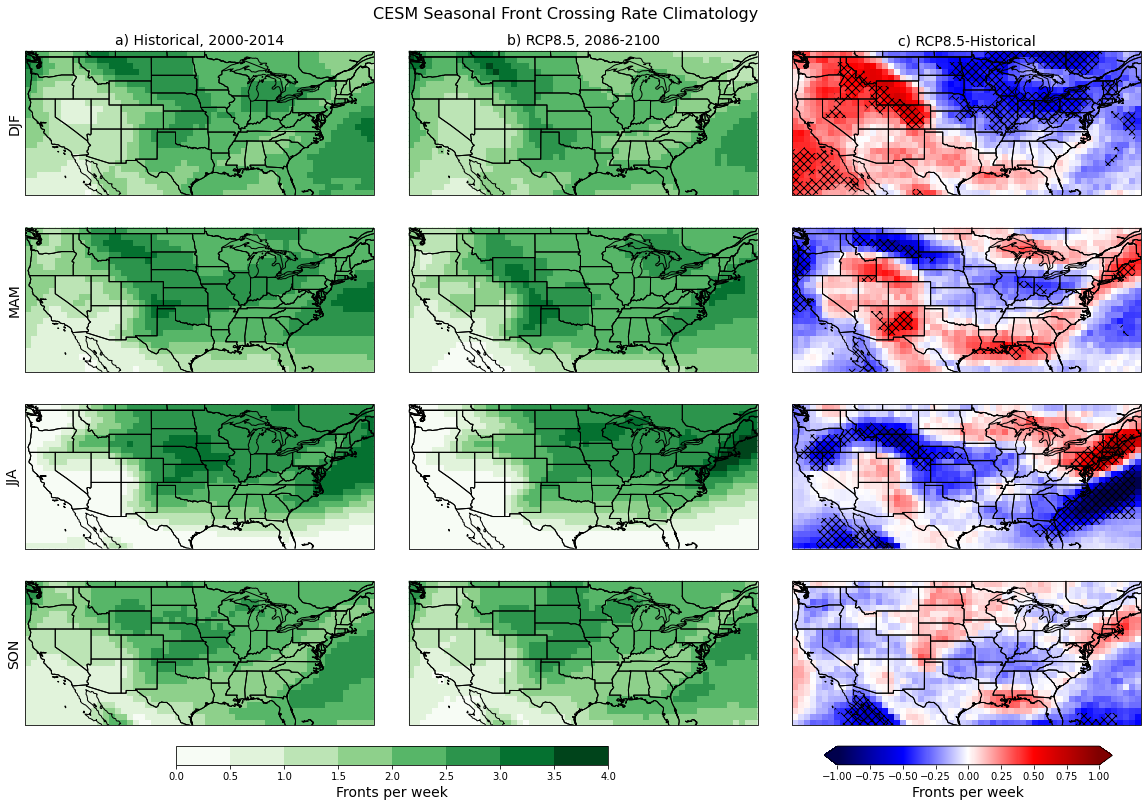

In [31]:
# spatial plots by season type
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormap
cmap=plt.cm.get_cmap('Greens', 8)
vmax=4 # for absolute plots

for i in range(nsea):
    if i == 0:
        axs[i,0].set_title('a) Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point((cesm_fullmod_srates_clim_CONUS*7)[i,4,:,:], coord=cesm_fullmod_srates_clim_CONUS.lon)
    lat = cesm_fullmod_srates_clim_CONUS.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines()
    axs[i,0].add_feature(cfeature.BORDERS)
    axs[i,0].add_feature(cfeature.STATES)
    axs[i,0].set_ylabel(seastrings[i], fontsize=14)
    axs[i,0].set_yticks([])
    
for i in range(nsea):
    if i == 0:
        axs[i,1].set_title('b) RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point((cesm_rcp85_srates_clim_CONUS*7)[i,4,:,:], coord=cesm_rcp85_srates_clim_CONUS.lon)
    lat = cesm_rcp85_srates_clim_CONUS.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines()
    axs[i,1].add_feature(cfeature.BORDERS)
    axs[i,1].add_feature(cfeature.STATES)
    
# colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.1, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal')
cb1.ax.set_xlabel('Fronts per week', fontsize=14)

# difference plot
cmap2 = plt.cm.get_cmap('seismic')
for i in range(nsea):
    if i==0:
        axs[i,2].set_title('c) RCP8.5-Historical', fontsize=14)
    # significance hatching - need to do this first or plots get cut off
    lon = cesm_srates_clim_CONUS_diff.lon # need to use original lon (add_cyclic_point adds to the lon dimension)
    lat = cesm_srates_clim_CONUS_diff.lat
    axs[i,2].contourf(lon, lat, xr.where((abs((cesm_srates_clim_CONUS_diff*7)[i,4,:,:]) > (cesm_fullmod_srates_clim_stdev_CONUS*7)[i,4,:,:]), 1.0, np.nan).data, transform=ccrs.PlateCarree(), 
             colors='none', levels=[1.0, 1.5],       
             #hatches=['////'], #another hatch option
             hatches=['XXX'], 
             zorder=10,)
    field, lon = add_cyclic_point((cesm_srates_clim_CONUS_diff*7)[i,4,:,:], coord=cesm_srates_clim_CONUS_diff.lon)
    lat = cesm_srates_clim_CONUS_diff.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=-1, vmax=1, transform=ccrs.PlateCarree())
    axs[i,2].coastlines()
    axs[i,2].add_feature(cfeature.BORDERS)
    axs[i,2].add_feature(cfeature.STATES)

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.1, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=-1, vmax=1)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('Fronts per week', fontsize=14)

plt.subplots_adjust(wspace=0.1, hspace=0)
fig.suptitle('CESM Seasonal Front Crossing Rate Climatology', fontsize=16, y=0.91);

#plt.savefig('../figures/toSCP/cesm_hist_rcp85_diff_srates_clim_CONUS_viaPoly_sig.png', bbox_inches='tight', dpi=300)

### Find the max across front types

In [18]:
cesm_fullmod_srates_clim_CONUS.max(dim=('seasons4','lat','lon'))*7

<xarray.DataArray 'seasonal_rate_climatology' (front: 5)>
array([2.6395037 , 1.3793869 , 2.8507247 , 0.89230776, 3.4086955 ],
      dtype=float32)
Coordinates:
    front_type  (front) object 'cold' 'warm' 'stationary' 'occluded' 'all'
Dimensions without coordinates: front

In [30]:
cesm_rcp85_srates_clim_CONUS.max(dim=('seasons4','lat','lon'))*7

<xarray.DataArray 'seasonal_rate_climatology' (front: 5)>
array([2.2140741, 1.2      , 3.214815 , 0.8814815, 3.936232 ],
      dtype=float32)
Coordinates:
    front_type  (front) object ...
Dimensions without coordinates: front

In [31]:
cesm_srates_clim_CONUS_diff.max(dim=('seasons4','lat','lon'))*7

<xarray.DataArray 'seasonal_rate_climatology' (front: 5)>
array([0.36806458, 0.3162622 , 1.1413043 , 0.21255803, 0.90289843],
      dtype=float32)
Coordinates:
    front_type  (front) object 'cold' 'warm' 'stationary' 'occluded' 'all'
Dimensions without coordinates: front

### Breakdown by front type

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/scratch/kdagon/ipykernel_679/2848417508.py:46: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal')
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3

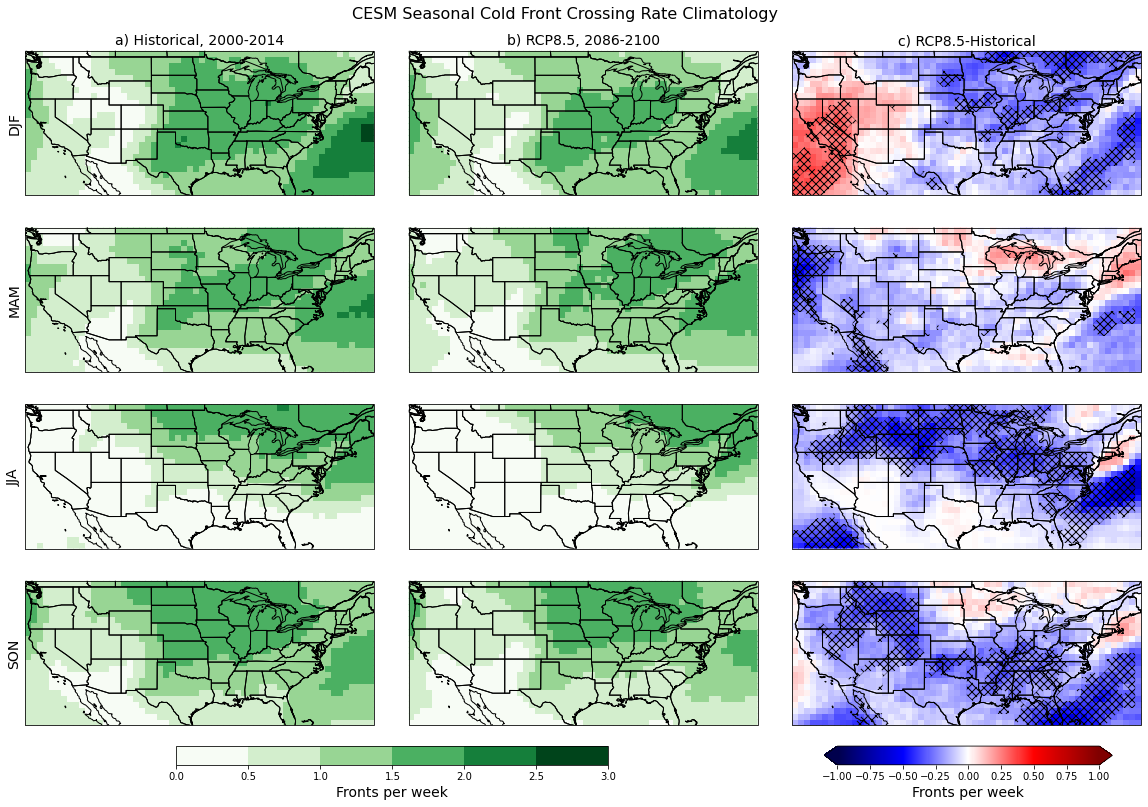

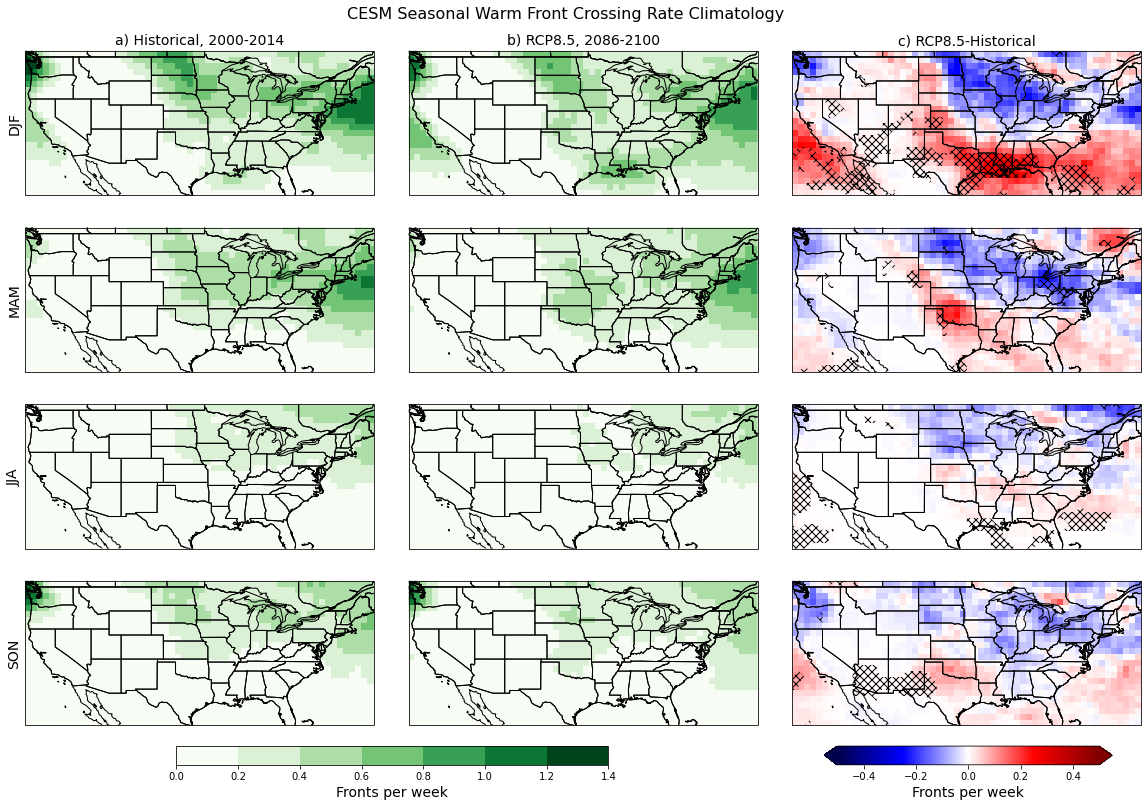

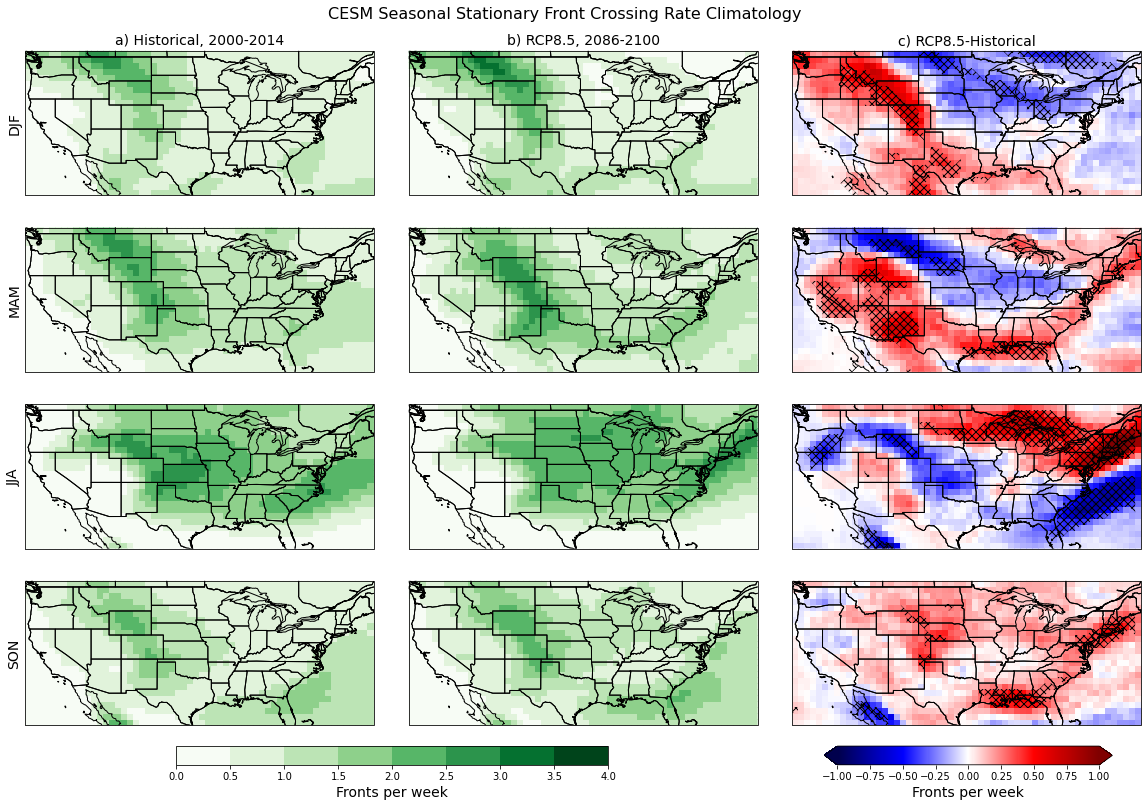

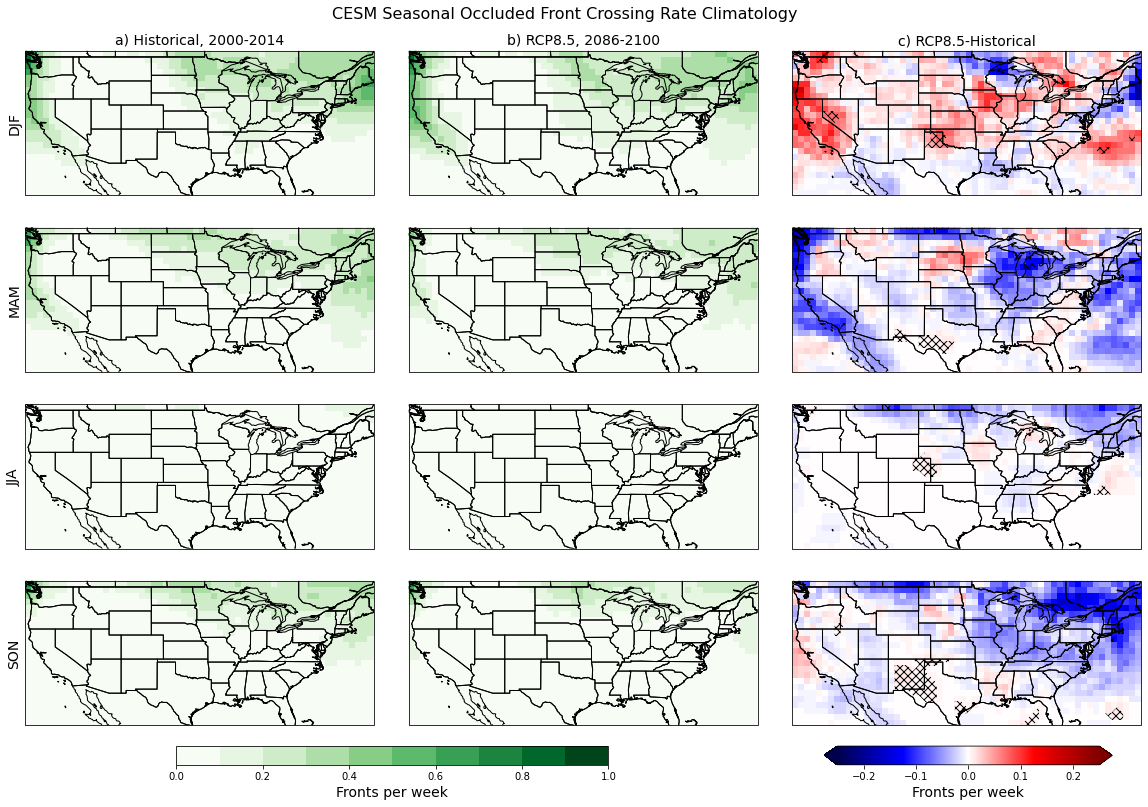

In [32]:
# loop over front type
frstrings = ('Cold', 'Warm', 'Stationary', 'Occluded')
nfr = len(frstrings)

vmaxes = [3,1.4,4,1]
ncols = [6,7,8,10]
vdiffs = [1,0.5,1,0.25]

# then season
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)

for f in range(nfr):

    fig, axs = plt.subplots(nsea, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

    # discrete colormap
    vmax = vmaxes[f]
    cmap=plt.cm.get_cmap('Greens', ncols[f])

    for i in range(nsea):
        if i == 0:
            axs[i,0].set_title('a) Historical, 2000-2014', fontsize=14) 
        field, lon = add_cyclic_point((cesm_fullmod_srates_clim_CONUS*7)[i,f,:,:], coord=cesm_fullmod_srates_clim_CONUS.lon)
        lat = cesm_fullmod_srates_clim_CONUS.lat
        cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
        axs[i,0].coastlines()
        axs[i,0].add_feature(cfeature.BORDERS)
        axs[i,0].add_feature(cfeature.STATES)
        axs[i,0].set_ylabel(seastrings[i], fontsize=14)
        axs[i,0].set_yticks([])
    
    for i in range(nsea):
        if i == 0:
            axs[i,1].set_title('b) RCP8.5, 2086-2100', fontsize=14)
        field, lon = add_cyclic_point((cesm_rcp85_srates_clim_CONUS*7)[i,f,:,:], coord=cesm_rcp85_srates_clim_CONUS.lon)
        lat = cesm_rcp85_srates_clim_CONUS.lat
        cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
        axs[i,1].coastlines()
        axs[i,1].add_feature(cfeature.BORDERS)
        axs[i,1].add_feature(cfeature.STATES)
        
    # colorbar for absolute plots
    cb1_ax = fig.add_axes([0.23, 0.1, 0.3, 0.02])
    norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
    cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm, orientation='horizontal')
    cb1.ax.set_xlabel('Fronts per week', fontsize=14)

    # difference plot
    cmap2 = plt.cm.get_cmap('seismic')
    vmin2 = -vdiffs[f]
    vmax2 = vdiffs[f]
    for i in range(nsea):
        if i==0:
            axs[i,2].set_title('c) RCP8.5-Historical', fontsize=14)
        # significance hatching - need to do this first or plots get cut off
        lon = cesm_srates_clim_CONUS_diff.lon # need to use original lon (add_cyclic_point adds to the lon dimension)
        lat = cesm_srates_clim_CONUS_diff.lat
        axs[i,2].contourf(lon, lat, xr.where((abs((cesm_srates_clim_CONUS_diff*7)[i,f,:,:]) > (cesm_fullmod_srates_clim_stdev_CONUS*7)[i,f,:,:]), 1.0, np.nan).data, transform=ccrs.PlateCarree(), 
             colors='none', levels=[1.0, 1.5],       
             #hatches=['////'], #another hatch option
             hatches=['XXX'], 
             zorder=10,)
        field, lon = add_cyclic_point((cesm_srates_clim_CONUS_diff*7)[i,f,:,:], coord=cesm_srates_clim_CONUS_diff.lon)
        lat = cesm_srates_clim_CONUS_diff.lat
        cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
        # add seasonal correlation with "all fronts" map (optional)
        #spear = stats.mstats.spearmanr(x=cesm_srates_clim_CONUS_diff[i,f,:,:], y=cesm_srates_clim_CONUS_diff[i,4,:,:])
        #spearstr = r'$\rho$ = '+str(round(spear.correlation,2))
        axs[i,2].coastlines()
        axs[i,2].add_feature(cfeature.BORDERS)
        axs[i,2].add_feature(cfeature.STATES)
        #axs[i,2].text(0.85, 0.05, spearstr, transform=axs[i,2].transAxes, bbox=dict(boxstyle='square', facecolor='white', alpha=0.5))
        
    # colorbar for diff plots
    cb2_ax = fig.add_axes([0.68, 0.1, 0.2, 0.02])
    norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
    cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap2, norm=norm2, orientation='horizontal', extend='both')
    cb2.ax.set_xlabel('Fronts per week', fontsize=14)

    plt.subplots_adjust(wspace=0.1, hspace=0)
    fig.suptitle('CESM Seasonal '+frstrings[f]+' Front Crossing Rate Climatology', fontsize=16, y=0.91);

    #plt.savefig('../figures/toSCP/cesm_hist_rcp85_diff_srates_'+frstrings[f]+'_clim_CONUS_viaPoly.png', bbox_inches='tight')
    #plt.savefig('../figures/toSCP/cesm_hist_rcp85_diff_srates_'+frstrings[f]+'_clim_CONUS_viaPoly_spearmanr.png', bbox_inches='tight')
    plt.savefig('../figures/toSCP/cesm_hist_rcp85_diff_srates_'+frstrings[f]+'_clim_CONUS_viaPoly_sig.png', bbox_inches='tight', dpi=300)

0.69465435
-0.7468665
0.62391305
-0.73550725
0.90289843
-1.1413043
0.39999998
-0.7076923


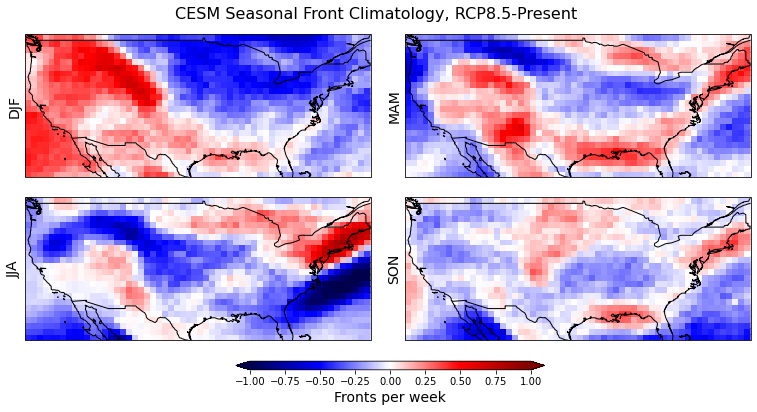

In [21]:
# modification for 2x2 panel plot
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(2, 2, figsize=(13,6), subplot_kw={'projection': ccrs.PlateCarree()})

axs = axs.ravel()

# colormap
cmap = plt.cm.get_cmap('seismic')

# PL, 2086-2100 - 2000-2014
cesm_srates_clim_CONUS_diff = cesm_rcp85_srates_clim_CONUS - cesm_fullmod_srates_clim_CONUS
#print(cesm_srates_clim_CONUS_diff.max())
#print(cesm_srates_clim_CONUS_diff.min())

for i in range(nsea):
    field, lon = add_cyclic_point((cesm_srates_clim_CONUS_diff*7)[i,4,:,:], coord=cesm_srates_clim_CONUS_diff.lon)
    print(field.max())
    print(field.min())
    lat = cesm_srates_clim_CONUS_diff.lat
    cf = axs[i].pcolor(lon, lat, field, cmap=cmap, vmin=-1, vmax=1, transform=ccrs.PlateCarree())
    axs[i].coastlines()
    axs[i].add_feature(cfeature.BORDERS)
    axs[i].set_ylabel(seastrings[i], fontsize=14)
    axs[i].set_yticks([])
    fig.suptitle('CESM Seasonal Front Climatology, RCP8.5-Present', fontsize=16, y=0.92)

cb_ax = fig.add_axes([0.35, 0.08, 0.33, 0.02])

# one way of doing a colorbar from scratch
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal', extend='both')
cb1.ax.set_xlabel('Fronts per week', fontsize=14)

plt.subplots_adjust(wspace=0.1, hspace=0)
#plt.savefig('../figures/toSCP/cesm_hist_rcp85_srates_clim_CONUS_viaPoly_diff_2x2.png', bbox_inches='tight')

## Panel plot summarizing CSB/MERRA/CESM hist&rcp rate comparisons

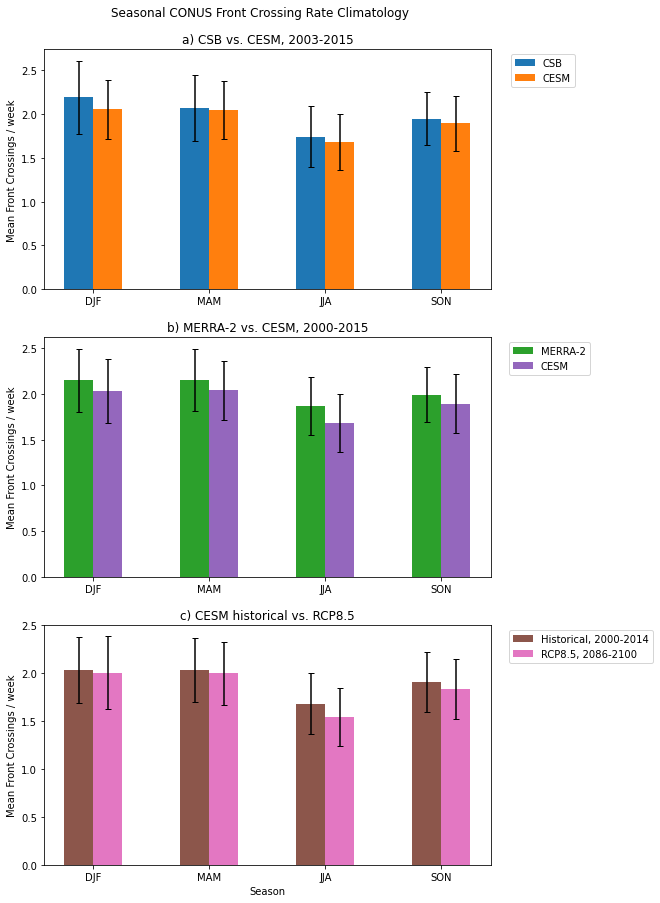

In [18]:
fig, ax = plt.subplots(3,1, figsize=(8,15))

w = 0.25
labels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(labels)
x = np.arange(nseason)  # the label locations

# CSB vs. CESM, 2003-2015
position = x - (w/2)
ax[0].bar(position, (csb_srates_clim_CONUS_mean*7)[:,4], yerr=(csb_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CSB", color='C0', capsize=3)
position = x + (w/2)
ax[0].bar(position, (cesm_srates_clim_CONUS_mean*7)[:,4], yerr=(cesm_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CESM", color='C1', capsize=3)

ax[0].set_title('a) CSB vs. CESM, 2003-2015')
ax[0].set_ylabel('Mean Front Crossings / week')
#ax[0].set_xlabel('Season')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend(bbox_to_anchor=(1.2, 1));

# CESM vs. MERRA, 2000-2015
position = x - (w/2)
ax[1].bar(position, (merra_cesm_srates_clim_CONUS_mean*7)[:,4], yerr=(merra_cesm_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="MERRA-2", color='C2', capsize=3)
position = x + (w/2)
ax[1].bar(position, (cesm_full_srates_clim_CONUS_mean*7)[:,4], yerr=(cesm_full_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="CESM", color='C4', capsize=3)

ax[1].set_title('b) MERRA-2 vs. CESM, 2000-2015')
ax[1].set_ylabel('Mean Front Crossings / week')
#ax[1].set_xlabel('Season')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend(bbox_to_anchor=(1.03, 1));

# CESM hist 2000-2014 vs. rcp8.5 2086-2100
position = x - (w/2)
ax[2].bar(position, (cesm_fullmod_srates_clim_CONUS_mean*7)[:,4], yerr=(cesm_fullmod_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="Historical, 2000-2014", color='C5', capsize=3)
position = x + (w/2)
ax[2].bar(position, (cesm_rcp85_srates_clim_CONUS_mean*7)[:,4], yerr=(cesm_rcp85_srates_clim_stdev_CONUS_mean*7)[:,4], width=w, label="RCP8.5, 2086-2100", color='C6', capsize=3)

ax[2].set_title('c) CESM historical vs. RCP8.5')
ax[2].set_ylabel('Mean Front Crossings / week')
ax[2].set_xlabel('Season')
ax[2].set_xticks(x)
ax[2].set_xticklabels(labels)
ax[2].legend(bbox_to_anchor=(1.03, 1));

plt.subplots_adjust(hspace=0.2)
fig.suptitle('Seasonal CONUS Front Crossing Rate Climatology', y=0.92);

#plt.savefig('../figures/toSCP/csb_cesm_merra_rcp85_srates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

## Revised plot condensing the above bar charts

In [18]:
# concat for easier plotting
srates_concat = xr.concat([csb_srates_clim_CONUS_mean, merra_cesm_srates_clim_CONUS_mean, cesm_full_srates_clim_CONUS_mean, cesm_rcp85_srates_clim_CONUS_mean], dim='sim')
srates_concat

<xarray.DataArray 'seasonal_rate_climatology' (sim: 4, seasons4: 4, front: 5)>
array([[[0.19448642, 0.09168416, 0.14807113, 0.03264998, 0.3131632 ],
        [0.18359814, 0.08369462, 0.15267873, 0.03018149, 0.29544709],
        [0.13722779, 0.06671378, 0.16866051, 0.01336066, 0.2489845 ],
        [0.1770923 , 0.07103751, 0.14196601, 0.02381273, 0.27799668]],

       [[0.19884584, 0.07586034, 0.09874207, 0.03386752, 0.30662151],
        [0.19465887, 0.06401212, 0.11223873, 0.03276492, 0.3070674 ],
        [0.14345465, 0.0381561 , 0.14700688, 0.0119193 , 0.26625982],
        [0.1853634 , 0.05159044, 0.10480065, 0.02354114, 0.28434975]],

       [[0.18185708, 0.04172717, 0.12742065, 0.01775653, 0.29077589],
        [0.16849794, 0.03291806, 0.15120398, 0.01509289, 0.29092317],
        [0.10226611, 0.01374096, 0.17454645, 0.00182486, 0.24001065],
        [0.16263509, 0.02330898, 0.13701647, 0.01030156, 0.27053376]],

       [[0.16912394, 0.04542913, 0.13139254, 0.01917261, 0.2864856 ],
        [0.15494245, 0.03121354, 0.1616694 , 0.01149674, 0.28583174],
        [0.07920022, 0.01262315, 0.17456611, 0.00086293, 0.22030683],
        [0.14116438, 0.02281695, 0.15086328, 0.00764219, 0.26251059]]])
Coordinates:
    clim_seasons  (sim, seasons4) object 1231977600000000000 ... 2093-10-15 0...
    front_type    (front) object 'cold' 'warm' 'stationary' 'occluded' 'all'
Dimensions without coordinates: sim, seasons4, front

In [19]:
srates_stdev_concat = xr.concat([csb_srates_clim_stdev_CONUS_mean, merra_cesm_srates_clim_stdev_CONUS_mean, cesm_full_srates_clim_stdev_CONUS_mean, cesm_rcp85_srates_clim_stdev_CONUS_mean], dim='sim')
srates_stdev_concat

<xarray.DataArray 'seasonal_rate_climatology_stdev' (sim: 4, seasons4: 4, front: 5)>
array([[[0.04605541, 0.03201359, 0.04890313, 0.01753969, 0.05933122],
        [0.03765244, 0.0307607 , 0.04576507, 0.0148149 , 0.05412225],
        [0.02938252, 0.0285818 , 0.04514513, 0.00788691, 0.04911411],
        [0.03067083, 0.02504113, 0.03948596, 0.01240939, 0.04307559]],

       [[0.04151462, 0.02752193, 0.03627163, 0.01926344, 0.04959387],
        [0.03785745, 0.02157712, 0.03319966, 0.01657277, 0.04790437],
        [0.02940817, 0.01433712, 0.03789926, 0.00720138, 0.04519802],
        [0.03185754, 0.01916257, 0.03417312, 0.01323018, 0.04299781]],

       [[0.03432668, 0.02113598, 0.04020288, 0.0132654 , 0.0498128 ],
        [0.03135716, 0.01520007, 0.04157187, 0.01120629, 0.04673763],
        [0.02359996, 0.00855142, 0.04280287, 0.00253337, 0.04523162],
        [0.03176825, 0.01378907, 0.04068778, 0.00889844, 0.04654438]],

       [[0.03755986, 0.02184937, 0.04413879, 0.01436825, 0.05423931],
        [0.02943745, 0.01526668, 0.04219643, 0.00971469, 0.04683563],
        [0.01918489, 0.0075613 , 0.04148086, 0.00167663, 0.04317132],
        [0.02767059, 0.01337133, 0.04059938, 0.00715366, 0.04430776]]])
Coordinates:
    clim_seasons  (sim, seasons4) object 1231977600000000000 ... 2093-10-15 0...
    front_type    (front) object 'cold' 'warm' 'stationary' 'occluded' 'all'
Dimensions without coordinates: sim, seasons4, front

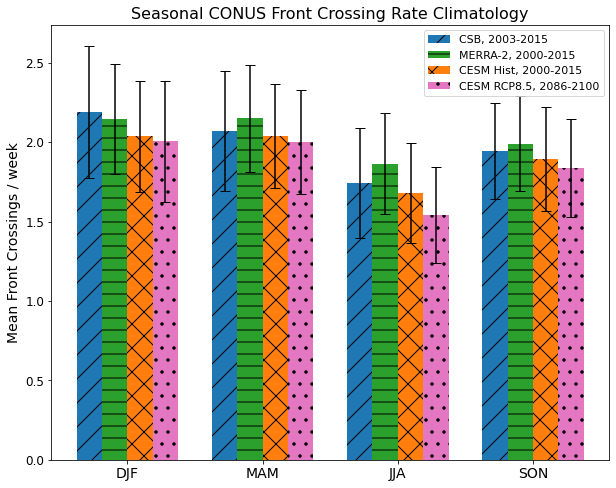

In [76]:
fig, ax = plt.subplots(figsize=(10,8))

xlabels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(xlabels)
x = np.arange(nseason)  # the label locations

# number of bars per xlabel
nbars=len(srates_concat)
# width
w = 0.75/nbars

labels=['CSB, 2003-2015', 'MERRA-2, 2000-2015', 'CESM Hist, 2000-2015', 'CESM RCP8.5, 2086-2100']
colors=['C0','C2','C1','C6']
hatches=['/','-','x','.']

# loop over simulations
for i,r in enumerate(srates_concat):

    position = x + (w*(1-nbars)/2) + i*w
    ax.bar(position, (srates_concat[i]*7)[:,4], yerr=(srates_stdev_concat[i]*7)[:,4], width=w, label=labels[i], color=colors[i], hatch=hatches[i], capsize=5)


ax.set_title('Seasonal CONUS Front Crossing Rate Climatology', fontsize=16)
ax.set_ylabel('Mean Front Crossings / week', fontsize=14)
ax.tick_params(axis='y', labelsize=12)
ax.set_xticks(x)
ax.set_xticklabels(xlabels, fontsize=14)
ax.legend(bbox_to_anchor=(1, 1), fontsize=11);

#plt.savefig('../figures/toSCP/csb_cesm_merra_rcp85_srates_clim_CONUS_mean_wk_stdev_1panel.png', bbox_inches='tight', dpi=300)

## Trying the above as a boxplot?
Not sure exactly what to plot here

No handles with labels found to put in legend.


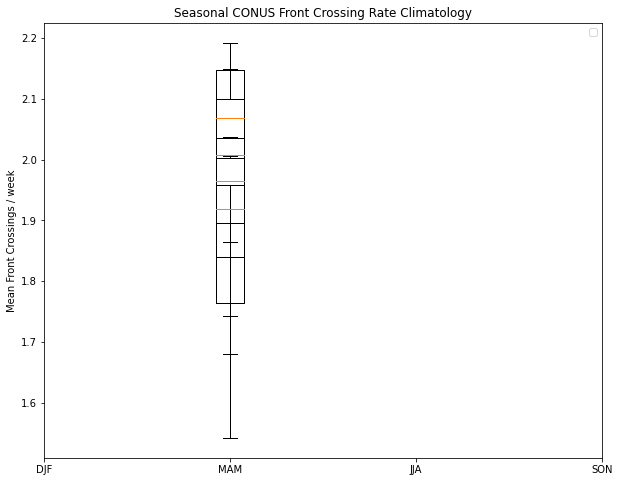

In [46]:
fig, ax = plt.subplots(figsize=(10,8))

xlabels = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(xlabels)
x = np.arange(nseason)  # the label locations

# number of bars per xlabel
nbars=len(srates_concat)
# width
w = 0.75/nbars

labels=['CSB, 2003-2015', 'MERRA-2, 2000-2015', 'CESM Hist, 2000-2015', 'CESM RCP8.5, 2086-2100']
colors=['C0','C2','C1','C6']
hatches=['/','-','x','.']

# loop over simulations
for i,r in enumerate(srates_concat):

    position = x + (w*(1-nbars)/2) + i*w
    ax.boxplot(x=(srates_concat[i]*7)[:,4])


ax.set_title('Seasonal CONUS Front Crossing Rate Climatology')
ax.set_ylabel('Mean Front Crossings / week')
ax.set_xticks(x)
ax.set_xticklabels(xlabels)
ax.legend(bbox_to_anchor=(1, 1));

#plt.savefig('../figures/toSCP/csb_cesm_merra_rcp85_srates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

## Summarizing different front types across datasets

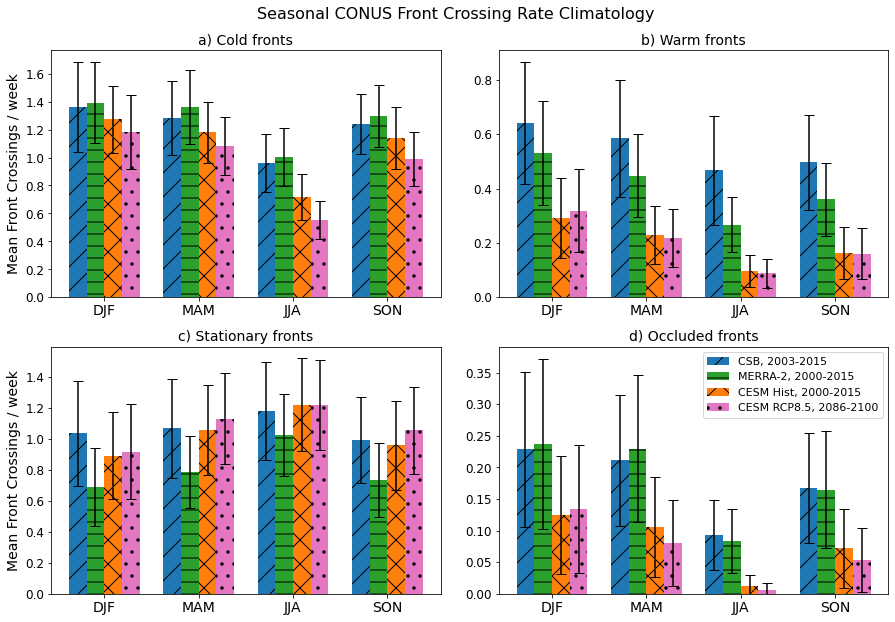

In [21]:
frontstrings = ('a) Cold', 'b) Warm', 'c) Stationary', 'd) Occluded')
nfronts = len(frontstrings)
fig, ax = plt.subplots(2, 2, figsize=(15,10))
ax = ax.ravel()

labels=['CSB, 2003-2015', 'MERRA-2, 2000-2015', 'CESM Hist, 2000-2015', 'CESM RCP8.5, 2086-2100']
colors=['C0','C2','C1','C6']
hatches=['/','-','x','.']

# loop over front types
for i in range(nfronts):
    slabels = ['DJF', 'MAM', 'JJA', 'SON']
    nseason = len(slabels)
    x = np.arange(nseason)  # the label locations
    
    # number of bars per xlabel
    nbars=len(srates_concat)
    # width
    w = 0.75/nbars

    # loop over datasets
    for j,r in enumerate(srates_concat):
        position = x + (w*(1-nbars)/2) + j*w
        ax[i].bar(position, (srates_concat[j]*7)[:,i], yerr=(srates_stdev_concat[j]*7)[:,i], width=w, label=labels[j], color=colors[j], hatch=hatches[j], capsize=5)
        
    ax[i].set_title(frontstrings[i]+' fronts', fontsize=14)
    if i==0 or i==2:
        ax[i].set_ylabel('Mean Front Crossings / week', fontsize=14)
    ax[i].tick_params(axis='y', labelsize=12)
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(slabels, fontsize=14)
    ax[i].set_ylim(bottom=0)

    if i==3:
        ax[i].legend(fontsize=11);
        
plt.subplots_adjust(wspace=0.15, hspace=0.20)

fig.suptitle('Seasonal CONUS Front Crossing Rate Climatology', y=0.94, fontsize=16);

#plt.savefig('../figures/toSCP/csb_cesm_merra_rcp85_srates_clim_CONUS_mean_wk_byfronttype_stdev.png', bbox_inches='tight', dpi=300)

## Plots summarizing all seasonal front rate climatologies

Time Range will need to be 2003-2015 because CSB starts 2003\
Variants: CSB masked/unmasked, CESM polylines, CESM OH, MERRA 2D polylines, MERRA 2D OH, MERRA 2D/3D polylines, MERRA 2D/3D OH (8)

### Function for plotting bar chart comparing two datasets over a specified time period

In [73]:
def srates_clim_CONUS_barplot(filepath1, ratesfile1, gridtype1, label1, filepath2, ratesfile2, gridtype2, label2, timerange):
    
    # call processing function
    spatial1, spatialstd1, mean1, std1 = srates_clim_CONUS(path=filepath1, file=ratesfile1, grid=gridtype1)
    spatial2, spatialstd2, mean2, std2 = srates_clim_CONUS(path=filepath2, file=ratesfile2, grid=gridtype2)
    
    # set up plot
    fig, ax = plt.subplots()

    w = 0.25
    labels = ['DJF', 'MAM', 'JJA', 'SON']
    nseason = len(labels)
    x = np.arange(nseason)  # the label locations

    position = x - (w/2)
    ax.bar(position, (mean1*7)[:,4], yerr=(std1*7)[:,4], width=w, label=label1, color='C0', capsize=3)
    position = x + (w/2)
    ax.bar(position, (mean2*7)[:,4], yerr=(std2*7)[:,4], width=w, label=label2, color='C1', capsize=3)

    ax.set_title('Seasonal CONUS Front Crossing Rate Climatology\nAll front types, '+timerange)
    ax.set_ylabel('Mean Front Crossings / week')
    ax.set_xlabel('Season')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    ax.legend(bbox_to_anchor=(1.05, 1));
    #plt.savefig('../figures/toSCP/'+label1+'_'+label2+'_srates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

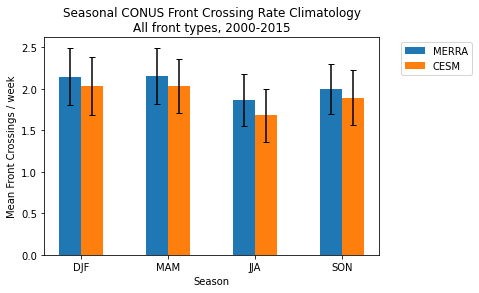

In [75]:
# example bar chart using function above comparing two datasets

filepath1 = '/glade/work/kdagon/FrontDetector/MERRAOutputs/'
ratesfile1 = 'merra_cesm_fronts_2000-2015_frontRates_viaPolylines_customgrid.nc'
gridtype1 = 'MERRA'
label1 = gridtype1

filepath2 = '/glade/work/kdagon/FrontDetector/CESMOutputs/'
ratesfile2 = 'cesm_fronts_2000-2015_frontRates_viaPolylines_customgrid.nc'
gridtype2 = 'MERRA'
label2 = 'CESM'

timerange='2000-2015'

srates_clim_CONUS_barplot(filepath1, ratesfile1, gridtype1, label1, filepath2, ratesfile2, gridtype2, label2, timerange)

### Standardize the plotting to be able to take dictionaries of filepaths and ratesfiles

In [76]:
def srates_clim_CONUS_dict_barplot(filepaths, ratesfiles, timerange):
    
    # set up storage arrays
    spatial = []
    mean = []
    std = []
    labels=[]
    
    # loop over ratesfiles
    for i,r in enumerate(ratesfiles):
        
        # assign a label for plotting
        labels.append(r)
        
        # assign filepath, gridtype based on string matching
        if "CSB" in r:
            f = filepaths["CSB"]
            g = "MERRA"          
        elif "MERRA" in r:
            f = filepaths["MERRA"]
            if "poly" in r:
                g = "MERRA"
            elif "OH" in r:
                g = "CESM"
        elif "CESM" in r:
            f = filepaths["CESM"]
            if "poly" in r:
                g = "MERRA"
            elif "OH" in r:
                g = "CESM"
            
        # call processing function    
        sp, spstd, m, sd = srates_clim_CONUS(path=f, file=ratesfiles[r], grid=g)
        spatial.append(sp)
        mean.append(m)
        std.append(sd)
    
    # set up plot
    fig, ax = plt.subplots(figsize=(15,10))
    
    # number of bars per xlabel
    nbars=len(ratesfiles)
    # width
    w = 0.75/nbars
    
    # set up xlabels
    xlabels = ['DJF', 'MAM', 'JJA', 'SON']
    nseason = len(xlabels)
    x = np.arange(nseason)  # the label locations

    # position based on current iteration
    for i in range(nbars):
        position = x + (w*(1-nbars)/2) + i*w
        ax.bar(position, (mean[i]*7)[:,4], yerr=(std[i]*7)[:,4], width=w, label=labels[i], capsize=3)
    
    ax.set_title('Seasonal CONUS Front Crossing Rate Climatology\nAll front types, '+timerange, fontsize=20)
    ax.set_ylabel('Mean Front Crossings / week', fontsize=15)
    ax.set_xlabel('Season', fontsize=15)
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, fontsize=12)
    plt.yticks(fontsize=12)

    ax.legend(bbox_to_anchor=(1.05, 1), fontsize=12);
    #plt.savefig('../figures/toSCP/compare_srates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

In [79]:
def srates_clim_CONUS_dict_pcolorplot(filepaths, ratesfiles, timerange):
    
    # set up storage arrays
    spatial = []
    mean = []
    std = []
    labels=[]
    
    # loop over ratesfiles
    for i,r in enumerate(ratesfiles):
        
        # assign a label for plotting
        labels.append(r)
        
        # assign filepath, gridtype based on string matching
        if "CSB" in r:
            f = filepaths["CSB"]
            g = "MERRA"          
        elif "MERRA" in r:
            f = filepaths["MERRA"]
            if "poly" in r:
                g = "MERRA"
            elif "OH" in r:
                g = "CESM"
        elif "CESM" in r:
            f = filepaths["CESM"]
            if "poly" in r:
                g = "MERRA"
            elif "OH" in r:
                g = "CESM"
            
        # call processing function    
        sp, spstd, m, sd = srates_clim_CONUS(path=f, file=ratesfiles[r], grid=g)
        spatial.append(sp)
        mean.append(m)
        std.append(sd)
    
    # set up plots by season type
    ncols=len(ratesfiles)
    seastrings = ('DJF', 'MAM', 'JJA', 'SON')
    nsea = len(seastrings)
    fig, axs = plt.subplots(nsea, ncols, figsize=(40,10), subplot_kw={'projection': ccrs.PlateCarree()})

    # discrete colormap
    cmap=plt.cm.get_cmap('Greens', 8)
    
    # loop over ratesfiles
    for j in range(ncols):

        # loop over seasons
        for i in range(nsea):
            if i == 0:
                axs[i,j].set_title(labels[j], fontsize=20) 
            field, lon = add_cyclic_point((spatial[j]*7)[i,4,:,:], coord=spatial[j].lon)
            lat = spatial[j].lat
            cf = axs[i,j].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=4, transform=ccrs.PlateCarree()) # trying to get rid of the white border, does slow down a bit
            axs[i,j].coastlines()
            axs[i,j].add_feature(cfeature.BORDERS)
            if j == 0:
                axs[i,j].set_ylabel(seastrings[i], fontsize=20)
                axs[i,j].set_yticks([])
                fig.suptitle('Seasonal Front Climatology, '+timerange, fontsize=25, y=0.94)
    
    cb_ax = fig.add_axes([0.26, 0.08, 0.5, 0.02])
    norm = mpl.colors.Normalize(vmin=0, vmax=4)
    cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal')
    cb1.ax.set_xlabel('Fronts per week', fontsize=20)
    cb1.ax.tick_params(labelsize=15)

    plt.subplots_adjust(wspace=0.05, hspace=0)
    #plt.savefig('../figures/toSCP/compare_srates_clim_CONUS.png', bbox_inches='tight')

In [78]:
# create some dictionaries for comparing multiple datasets
filepaths = {
    "CSB": "/glade/work/kdagon/ML-extremes/data/CODSUS/MERRA2/", 
    "MERRA": "/glade/work/kdagon/FrontDetector/MERRAOutputs/",
    "CESM": "/glade/work/kdagon/FrontDetector/CESMOutputs/"
}

# some of these have longer time period variants, sticking to 2003-2015 for consistency
ratesfiles = {
    "CSB_masked": "codsus_masked_frontRates_2003-2015.nc",
    "CSB_unmasked": "codsus_frontRates_2003-2015.nc",
    "MERRA_2D_poly": "merra_fronts_2003-2015_frontRates_viaPolylines_customgrid.nc",
    "MERRA_2D_OH": "merra_frontRates_2003-2015.nc",
    "MERRA_3D_poly": "merra_cesm_fronts_2003-2015_frontRates_viaPolylines_customgrid.nc",
    "MERRA_3D_OH": "merra_cesm_frontRates_2003-2015.nc",
    "CESM_poly": "cesm_fronts_2003-2015_frontRates_viaPolylines_customgrid.nc",
    "CESM_OH": "cesm_frontRates_2003-2015.nc"
}

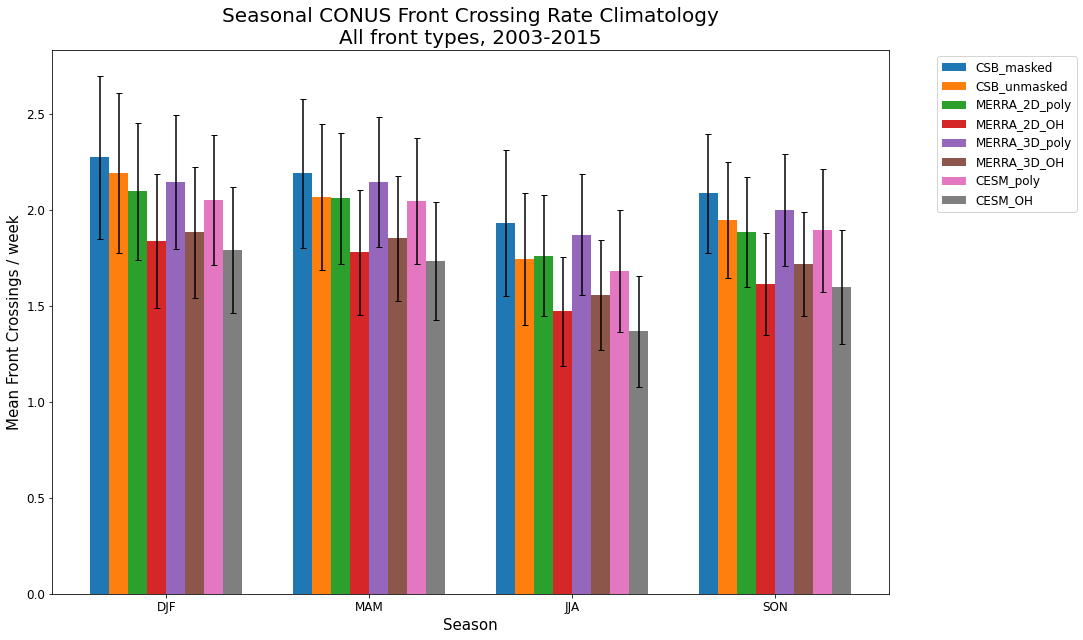

In [80]:
timerange = '2003-2015'

srates_clim_CONUS_dict_barplot(filepaths, ratesfiles, timerange)

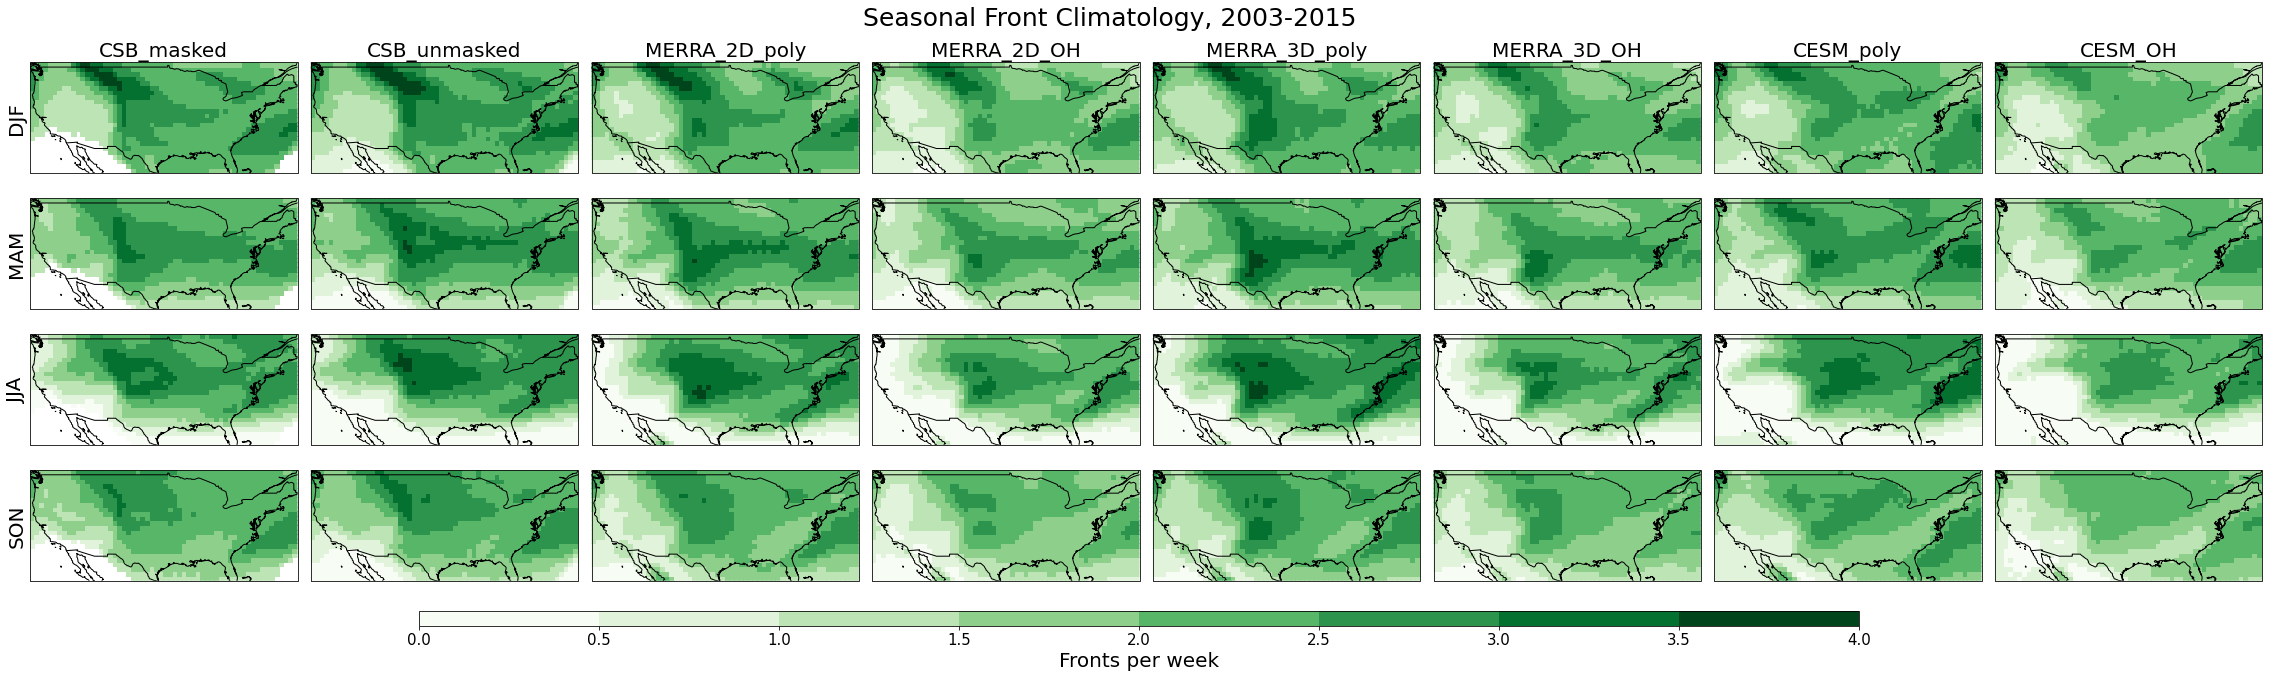

In [81]:
srates_clim_CONUS_dict_pcolorplot(filepaths, ratesfiles, timerange)

### TO DO: spatial difference plots for the above comparisons?
Could help diagnose subtle processing differences

## Timeseries anomaly plots (see B&K Fig 10)

In [18]:
merra_cesm_rates_fronts = xr.open_dataset(merra_filepath+merra_cesm_rates_file)

In [19]:
merra_cesm_rates_fronts.monthly_rate_anomaly.groupby('months.year')

DataArrayGroupBy, grouped over 'year' 
16 groups with labels 2000, 2001, 2002, ..., 2014, 2015.

In [20]:
merra_cesm_rates_fronts.monthly_rate_anomaly.months

<xarray.DataArray 'months' (months: 192)>
array(['2000-01-15T00:00:00.000000000', '2000-02-15T00:00:00.000000000',
       '2000-03-15T00:00:00.000000000', '2000-04-15T00:00:00.000000000',
       '2000-05-15T00:00:00.000000000', '2000-06-15T00:00:00.000000000',
       '2000-07-15T00:00:00.000000000', '2000-08-15T00:00:00.000000000',
       '2000-09-15T00:00:00.000000000', '2000-10-15T00:00:00.000000000',
       '2000-11-15T00:00:00.000000000', '2000-12-15T00:00:00.000000000',
       '2001-01-15T00:00:00.000000000', '2001-02-15T00:00:00.000000000',
       '2001-03-15T00:00:00.000000000', '2001-04-15T00:00:00.000000000',
       '2001-05-15T00:00:00.000000000', '2001-06-15T00:00:00.000000000',
       '2001-07-15T00:00:00.000000000', '2001-08-15T00:00:00.000000000',
       '2001-09-15T00:00:00.000000000', '2001-10-15T00:00:00.000000000',
       '2001-11-15T00:00:00.000000000', '2001-12-15T00:00:00.000000000',
       '2002-01-15T00:00:00.000000000', '2002-02-15T00:00:00.000000000',
       '2002-03-15T00:00:00.000000000', '2002-04-15T00:00:00.000000000',
       '2002-05-15T00:00:00.000000000', '2002-06-15T00:00:00.000000000',
       '2002-07-15T00:00:00.000000000', '2002-08-15T00:00:00.000000000',
       '2002-09-15T00:00:00.000000000', '2002-10-15T00:00:00.000000000',
       '2002-11-15T00:00:00.000000000', '2002-12-15T00:00:00.000000000',
       '2003-01-15T00:00:00.000000000', '2003-02-15T00:00:00.000000000',
       '2003-03-15T00:00:00.000000000', '2003-04-15T00:00:00.000000000',
       '2003-05-15T00:00:00.000000000', '2003-06-15T00:00:00.000000000',
       '2003-07-15T00:00:00.000000000', '2003-08-15T00:00:00.000000000',
       '2003-09-15T00:00:00.000000000', '2003-10-15T00:00:00.000000000',
       '2003-11-15T00:00:00.000000000', '2003-12-15T00:00:00.000000000',
       '2004-01-15T00:00:00.000000000', '2004-02-15T00:00:00.000000000',
       '2004-03-15T00:00:00.000000000', '2004-04-15T00:00:00.000000000',
       '2004-05-15T00:00:00.000000000', '2004-06-15T00:00:00.000000000',
       '2004-07-15T00:00:00.000000000', '2004-08-15T00:00:00.000000000',
       '2004-09-15T00:00:00.000000000', '2004-10-15T00:00:00.000000000',
       '2004-11-15T00:00:00.000000000', '2004-12-15T00:00:00.000000000',
       '2005-01-15T00:00:00.000000000', '2005-02-15T00:00:00.000000000',
       '2005-03-15T00:00:00.000000000', '2005-04-15T00:00:00.000000000',
       '2005-05-15T00:00:00.000000000', '2005-06-15T00:00:00.000000000',
       '2005-07-15T00:00:00.000000000', '2005-08-15T00:00:00.000000000',
       '2005-09-15T00:00:00.000000000', '2005-10-15T00:00:00.000000000',
       '2005-11-15T00:00:00.000000000', '2005-12-15T00:00:00.000000000',
       '2006-01-15T00:00:00.000000000', '2006-02-15T00:00:00.000000000',
       '2006-03-15T00:00:00.000000000', '2006-04-15T00:00:00.000000000',
       '2006-05-15T00:00:00.000000000', '2006-06-15T00:00:00.000000000',
       '2006-07-15T00:00:00.000000000', '2006-08-15T00:00:00.000000000',
       '2006-09-15T00:00:00.000000000', '2006-10-15T00:00:00.000000000',
       '2006-11-15T00:00:00.000000000', '2006-12-15T00:00:00.000000000',
       '2007-01-15T00:00:00.000000000', '2007-02-15T00:00:00.000000000',
       '2007-03-15T00:00:00.000000000', '2007-04-15T00:00:00.000000000',
       '2007-05-15T00:00:00.000000000', '2007-06-15T00:00:00.000000000',
       '2007-07-15T00:00:00.000000000', '2007-08-15T00:00:00.000000000',
       '2007-09-15T00:00:00.000000000', '2007-10-15T00:00:00.000000000',
       '2007-11-15T00:00:00.000000000', '2007-12-15T00:00:00.000000000',
       '2008-01-15T00:00:00.000000000', '2008-02-15T00:00:00.000000000',
       '2008-03-15T00:00:00.000000000', '2008-04-15T00:00:00.000000000',
       '2008-05-15T00:00:00.000000000', '2008-06-15T00:00:00.000000000',
       '2008-07-15T00:00:00.000000000', '2008-08-15T00:00:00.000000000',
       '2008-09-15T00:00:00.000000000', '2008-10-15T00:00:00.000000000',
       '2008-11-15T00:00:00.000000000', '2008-12-15T00:00:00.000000000',
       '2009-01-

### Function to calculate monthly rate anomalies

In [47]:
# function for calculating monthly rate anomalies over CONUS (spatial field, spatial mean)
def mrates_anom_CONUS(path, file, grid):

    # read in files
    rates_fronts = xr.open_dataset(path+file)
    
    # process monthly rate anomaly
    mrates_anom = rates_fronts.monthly_rate_anomaly
    
    # check gridtype
    if grid=='CESM':
        mrates_anom_CONUS = mrates_anom.sel(lat=slice(26,50), lon=slice(235,292)) # CESM grid lons
    elif grid=='MERRA':
        mrates_anom_CONUS = mrates_anom.sel(lat=slice(26,50), lon=slice(-125, -68)) # MERRA2 grid lons for rates calculated via polylines
    
       
    # average over CONUS
    weights = np.cos(np.deg2rad(mrates_anom_CONUS.lat))
    weights.name = "weights"
    mrates_anom_CONUS_weighted = mrates_anom_CONUS.weighted(weights)
    mrates_anom_CONUS_weighted_mean = mrates_anom_CONUS_weighted.mean(("lon","lat"))
        
    return(mrates_anom_CONUS, mrates_anom_CONUS_weighted_mean)

In [7]:
# example using function above comparing two datasets

filepath1 = '/glade/work/kdagon/FrontDetector/MERRAOutputs/'
ratesfile1 = 'merra_cesm_fronts_2000-2015_frontRates_viaPolylines_customgrid.nc'
gridtype1 = 'MERRA'
label1 = gridtype1

filepath2 = '/glade/work/kdagon/FrontDetector/CESMOutputs/'
ratesfile2 = 'cesm_fronts_2000-2015_frontRates_viaPolylines_customgrid.nc'
gridtype2 = 'MERRA'
label2='CESM'

In [8]:
spatial1, mean1 = mrates_anom_CONUS(path=filepath1, file=ratesfile1, grid=gridtype1)
spatial2, mean2 = mrates_anom_CONUS(path=filepath2, file=ratesfile2, grid=gridtype2)

In [ ]:
# MERRA uses datetime64
mean1.months

In [ ]:
# CESM uses cftime.DatetimeNoLeap
mean2.months

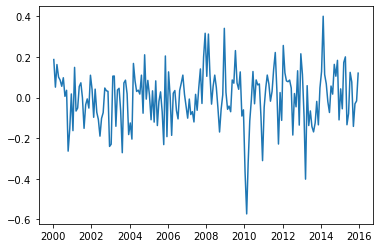

In [28]:
plt.plot(mean1.months, (mean1*7)[:,4], label=label1, color='C0');

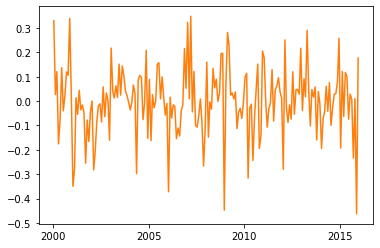

In [29]:
plt.plot(mean2.months, (mean2*7)[:,4], label=label2, color='C1');

### Need to standardize time conventions to get these to show up on the same plot
Different time conventions for MERRA (datetime) and CESM (cftime)

In [11]:
# try converting cftime (CESM) to datetime
datetimeindex = mean2.indexes['months'].to_datetimeindex()
mean2['months'] = datetimeindex

/glade/scratch/kdagon/ipykernel_187734/621687414.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = mean2.indexes['months'].to_datetimeindex()


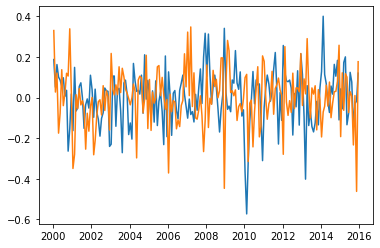

In [12]:
plt.plot(mean1.months, (mean1*7)[:,4], label=label1, color='C0')
plt.plot(mean2.months, (mean2*7)[:,4], label=label2, color='C1');

the above worked but as the warning indicated, the calendars are slightly off (CESM is no-leap) so that may impact visualization\
but they are already monthly anomalies so leap days have likely already been factored in...

### Function to plot two timeseries with regression lines

In [104]:
# function for plotting timeseries comparing two datasets over a specified time period
def mrates_anom_CONUS_ts(filepath1, ratesfile1, gridtype1, label1, filepath2, ratesfile2, gridtype2, label2, timerange):
    
    # call processing function
    spatial1, mean1 = mrates_anom_CONUS(path=filepath1, file=ratesfile1, grid=gridtype1)
    spatial2, mean2 = mrates_anom_CONUS(path=filepath2, file=ratesfile2, grid=gridtype2)
    
    # standarize time indices - fix logic to check either label 1 or 2
    if label2=="CESM":
        datetimeindex = mean2.indexes['months'].to_datetimeindex()
        mean2['months'] = datetimeindex
    
    # linear regression fits
    reg1 = mean1.polyfit(dim='months', deg=1)
    reg2 = mean2.polyfit(dim='months', deg=1)
    fit1 = xr.polyval(mean1['months'], reg1.polyfit_coefficients)
    fit2 = xr.polyval(mean2['months'], reg2.polyfit_coefficients)
    
    # set up plot
    fig, ax = plt.subplots(figsize=(10,8))

    # TO DO: label years at first month of each year, given data input?
    #labels = np.arange(2000,2015)  # the labels

    ax.plot(mean1.months, (mean1*7)[:,4], label=label1, color='C0')
    ax.plot(mean2.months, (mean2*7)[:,4], label=label2, color='C1')
    ax.plot(mean1.months, (fit1*7)[:,4], color='C0', linestyle='dashed')
    ax.plot(mean2.months, (fit2*7)[:,4], color='C1', linestyle='dashed')

    ax.set_title('Monthly CONUS Front Crossing Rate Anomaly\nAll front types, '+timerange)
    ax.set_ylabel('Mean Front Crossing Rate Anomaly / week')
    #ax.set_xlabel('Year')
    #ax.set_xticks(x)
    #ax.set_xticklabels(labels)
    
    date_form = DateFormatter("%Y")
    ax.xaxis.set_major_formatter(date_form)

    ax.legend()
    #plt.savefig('../figures/toSCP/'+label1+'_'+label2+'_srates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

/glade/scratch/kdagon/ipykernel_187734/1516642266.py:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = mean2.indexes['months'].to_datetimeindex()


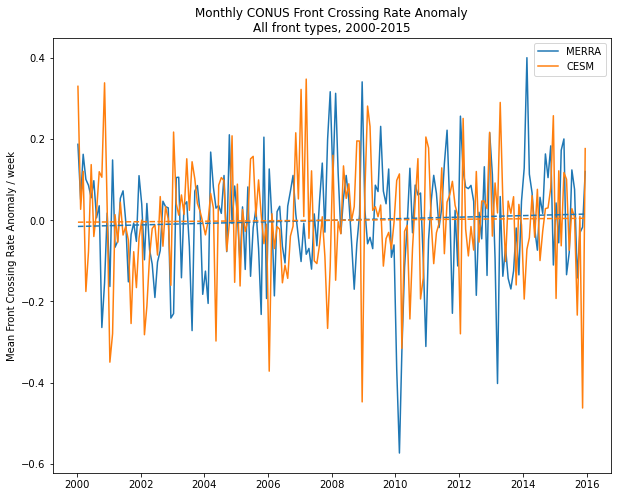

In [105]:
# example timeseries using functions above comparing two datasets

filepath1 = '/glade/work/kdagon/FrontDetector/MERRAOutputs/'
ratesfile1 = 'merra_cesm_fronts_2000-2015_frontRates_viaPolylines_customgrid.nc'
gridtype1 = 'MERRA'
label1 = gridtype1

filepath2 = '/glade/work/kdagon/FrontDetector/CESMOutputs/'
ratesfile2 = 'cesm_fronts_2000-2015_frontRates_viaPolylines_customgrid.nc'
gridtype2 = 'MERRA'
label2 = 'CESM'

timerange='2000-2015'

mrates_anom_CONUS_ts(filepath1, ratesfile1, gridtype1, label1, filepath2, ratesfile2, gridtype2, label2, timerange)

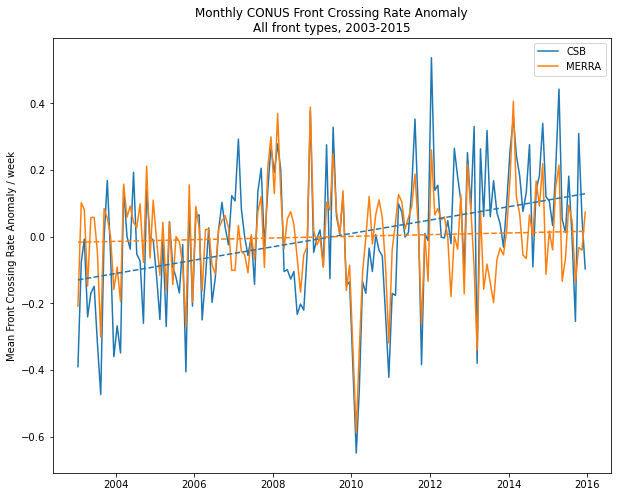

In [106]:
# compare CSB and MERRA to reproduce B&K Fig 10
# CSB regression line looks too shallow?

filepath1 = "/glade/work/kdagon/ML-extremes/data/CODSUS/MERRA2/"
ratesfile1 = "codsus_masked_frontRates_2003-2015.nc" # masked to compare with Jim's analysis
gridtype1 = 'MERRA'
label1 = 'CSB'

filepath2 = '/glade/work/kdagon/FrontDetector/MERRAOutputs/'
ratesfile2 = 'merra_fronts_2003-2015_frontRates_viaPolylines_customgrid.nc'
gridtype2 = 'MERRA'
label2 = 'MERRA'

timerange='2003-2015'

mrates_anom_CONUS_ts(filepath1, ratesfile1, gridtype1, label1, filepath2, ratesfile2, gridtype2, label2, timerange)

/glade/scratch/kdagon/ipykernel_187734/1516642266.py:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = mean2.indexes['months'].to_datetimeindex()


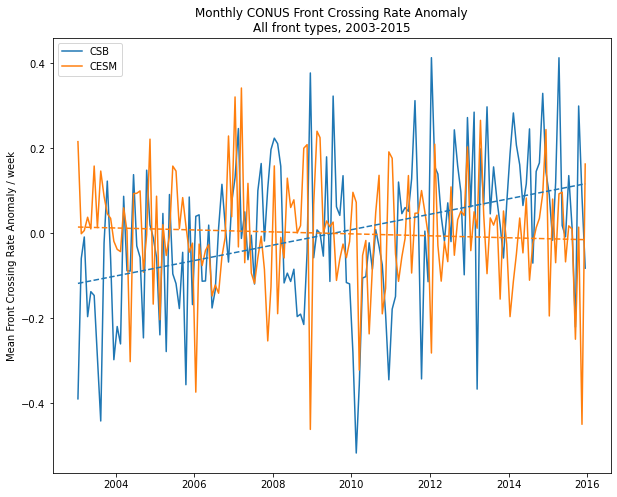

In [108]:
# compare CSB and CESM

filepath1 = "/glade/work/kdagon/ML-extremes/data/CODSUS/MERRA2/"
ratesfile1 = "codsus_frontRates_2003-2015.nc"
gridtype1 = 'MERRA'
label1 = 'CSB'

filepath2 = "/glade/work/kdagon/FrontDetector/CESMOutputs/"
ratesfile2 = "cesm_fronts_2003-2015_frontRates_viaPolylines_customgrid.nc"
gridtype2 = 'MERRA'
label2 = 'CESM'

timerange='2003-2015'

mrates_anom_CONUS_ts(filepath1, ratesfile1, gridtype1, label1, filepath2, ratesfile2, gridtype2, label2, timerange)

<xarray.DataArray 'polyfit_coefficients' (degree: 2)>
array([-1.47607565e-20,  5.75253440e-02])
Coordinates:
  * degree   (degree) int64 1 0
    front    int64 4


/glade/scratch/kdagon/ipykernel_187734/2917149356.py:12: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = mean1.indexes['months'].to_datetimeindex()


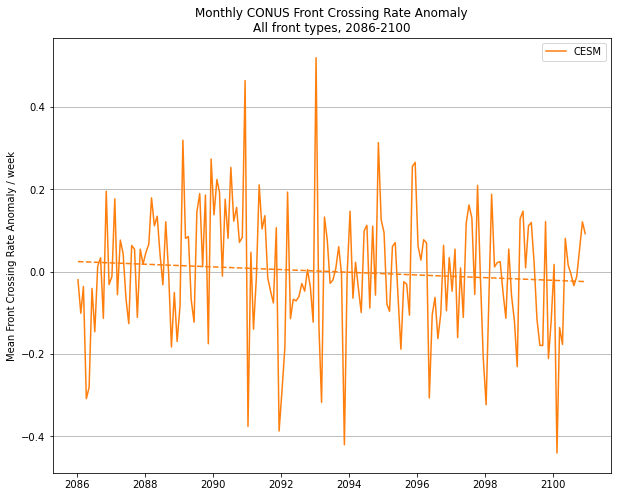

In [122]:
# plot CESM RCP8.5

filepath1 = "/glade/work/kdagon/FrontDetector/CESMOutputs/"
ratesfile1 = "cesm_fronts_2086-2100_frontRates_viaPolylines_customgrid.nc"
gridtype1 = 'MERRA'
label1 = 'CESM'

timerange='2086-2100'

spatial1, mean1 = mrates_anom_CONUS(path=filepath1, file=ratesfile1, grid=gridtype1)

datetimeindex = mean1.indexes['months'].to_datetimeindex()
mean1['months'] = datetimeindex
    
# linear regression fit
reg1 = mean1.polyfit(dim='months', deg=1)
fit1 = xr.polyval(mean1['months'], reg1.polyfit_coefficients)
print(reg1.polyfit_coefficients[:,4])
    
# set up plot
fig, ax = plt.subplots(figsize=(10,8))

# TO DO: label years at first month of each year, given data input?
#labels = np.arange(2000,2015)  # the labels

ax.plot(mean1.months, (mean1*7)[:,4], label=label1, color='C1')
ax.plot(mean1.months, (fit1*7)[:,4], color='C1', linestyle='dashed')

ax.set_title('Monthly CONUS Front Crossing Rate Anomaly\nAll front types, '+timerange)
ax.set_ylabel('Mean Front Crossing Rate Anomaly / week')
    
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)

ax.legend()
ax.grid(axis='y')

### Function to plot >2 timeseries with regression lines

In [142]:
# function for plotting timeseries comparing 2+ datasets over a specified time period
# can comment out 4th dataset for plotting 3 only
def mrates_anom_CONUS_ts_mult(filepath1, ratesfile1, gridtype1, label1, filepath2, ratesfile2, gridtype2, label2, 
                              filepath3, ratesfile3, gridtype3, label3,
                              #filepath4, ratesfile4, gridtype4, label4,
                              timerange):
    
    # call processing function
    spatial1, mean1 = mrates_anom_CONUS(path=filepath1, file=ratesfile1, grid=gridtype1)
    spatial2, mean2 = mrates_anom_CONUS(path=filepath2, file=ratesfile2, grid=gridtype2)
    spatial3, mean3 = mrates_anom_CONUS(path=filepath3, file=ratesfile3, grid=gridtype3)
    #spatial4, mean4 = mrates_anom_CONUS(path=filepath4, file=ratesfile4, grid=gridtype4)
    
    # standarize time indices - fix logic to check either label 1 or 2
    if label2=="CESM":
        datetimeindex = mean2.indexes['months'].to_datetimeindex()
        mean2['months'] = datetimeindex
    
    # linear regression fits
    reg1 = mean1.polyfit(dim='months', deg=1)
    reg2 = mean2.polyfit(dim='months', deg=1)
    reg3 = mean3.polyfit(dim='months', deg=1)
    #reg4 = mean4.polyfit(dim='months', deg=1)
    fit1 = xr.polyval(mean1['months'], reg1.polyfit_coefficients)
    print(reg1.polyfit_coefficients[:,4])
    fit2 = xr.polyval(mean2['months'], reg2.polyfit_coefficients)
    print(reg2.polyfit_coefficients[:,4])
    fit3 = xr.polyval(mean3['months'], reg3.polyfit_coefficients)
    #fit4 = xr.polyval(mean4['months'], reg4.polyfit_coefficients)
    
    # set up plot
    fig, ax = plt.subplots(figsize=(10,8))

    # TO DO: label years at first month of each year, given data input?
    #labels = np.arange(2000,2015)  # the labels

    ax.plot(mean1.months, (mean1*7)[:,4], label=label1, color='C0')
    ax.plot(mean2.months, (mean2*7)[:,4], label=label2, color='C1')
    ax.plot(mean3.months, (mean3*7)[:,4], label=label3, color='C2')
    #ax.plot(mean4.months, (mean4*7)[:,4], label=label4, color='C3')
    ax.plot(mean1.months, (fit1*7)[:,4], color='C0', linestyle='dashed')
    ax.plot(mean2.months, (fit2*7)[:,4], color='C1', linestyle='dashed')
    ax.plot(mean3.months, (fit3*7)[:,4], color='C2', linestyle='dashed')
    #ax.plot(mean4.months, (fit4*7)[:,4], color='C3', linestyle='dashed')

    ax.set_title('Monthly CONUS Front Crossing Rate Anomaly\nAll front types, '+timerange)
    ax.set_ylabel('Mean Front Crossing Rate Anomaly / week')
    #ax.set_xlabel('Year')
    #ax.set_xticks(x)
    #ax.set_xticklabels(labels)
    
    date_form = DateFormatter("%Y")
    ax.xaxis.set_major_formatter(date_form)

    ax.legend()
    ax.grid(axis='y')
    #plt.savefig('../figures/toSCP/'+label1+'_'+label2+'_srates_clim_CONUS_mean_wk_stdev.png', bbox_inches='tight')

<xarray.DataArray 'polyfit_coefficients' (degree: 2)>
array([ 8.21163187e-20, -1.02427116e-01])
Coordinates:
  * degree   (degree) int64 1 0
    front    int64 4
<xarray.DataArray 'polyfit_coefficients' (degree: 2)>
array([-1.04043155e-20,  1.29673785e-02])
Coordinates:
  * degree   (degree) int64 1 0
    front    int64 4


/glade/scratch/kdagon/ipykernel_187734/3245027078.py:16: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = mean2.indexes['months'].to_datetimeindex()


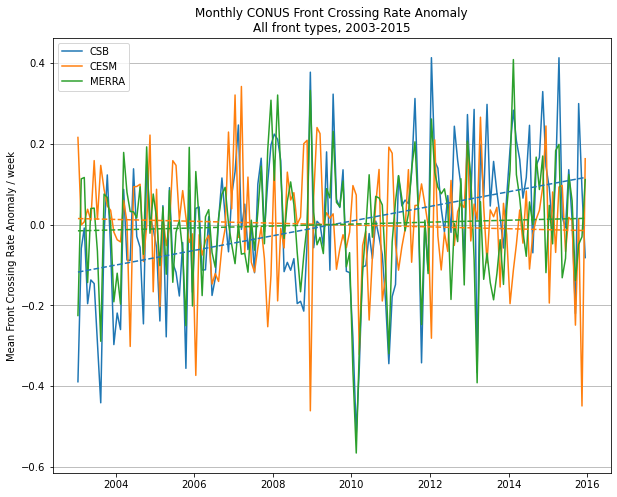

In [160]:
filepath1 = "/glade/work/kdagon/ML-extremes/data/CODSUS/MERRA2/"
ratesfile1 = "codsus_frontRates_2003-2015.nc"
gridtype1 = 'MERRA'
label1 = 'CSB'

filepath2 = "/glade/work/kdagon/FrontDetector/CESMOutputs/"
ratesfile2 = "cesm_fronts_2003-2015_frontRates_viaPolylines_customgrid.nc"
gridtype2 = 'MERRA'
label2 = 'CESM'

filepath3 = "/glade/work/kdagon/FrontDetector/MERRAOutputs/"
ratesfile3 = "merra_cesm_fronts_2003-2015_frontRates_viaPolylines_customgrid.nc"
gridtype3 = 'MERRA'
label3='MERRA
#label3 = 'MERRA-CESM'

#filepath4 = "/glade/work/kdagon/FrontDetector/MERRAOutputs/"
#ratesfile4 = "merra_fronts_2003-2015_frontRates_viaPolylines_customgrid.nc"
#gridtype4 = 'MERRA'
#label4 = 'MERRA'

timerange='2003-2015'

mrates_anom_CONUS_ts_mult(filepath1, ratesfile1, gridtype1, label1, filepath2, ratesfile2, gridtype2, label2, 
                     filepath3, ratesfile3, gridtype3, label3, 
                     #filepath4, ratesfile4, gridtype4, label4,
                     timerange)

# differences between MERRA and MERRA-CESM are subtle (based on slightly different input fields used to compare across CSB/CESM)
# as a result, use MERRA-CESM front rates as the MERRA data for a comparison plot

### Panel the above two plots

/glade/scratch/kdagon/ipykernel_191812/1711842813.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = mean2.indexes['months'].to_datetimeindex()
/glade/scratch/kdagon/ipykernel_191812/1711842813.py:32: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = mean4.indexes['months'].to_datetimeindex()


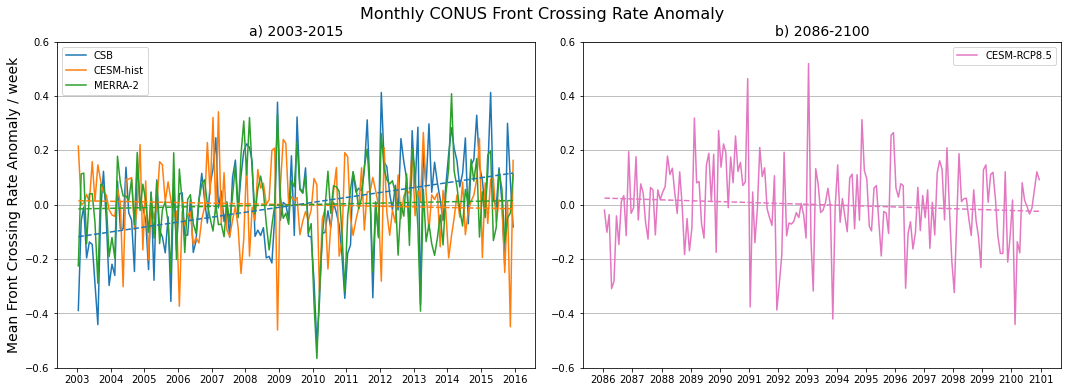

In [50]:
filepath1 = "/glade/work/kdagon/ML-extremes/data/CODSUS/MERRA2/"
ratesfile1 = "codsus_frontRates_2003-2015.nc"
gridtype1 = 'MERRA'
label1 = 'CSB'

filepath2 = "/glade/work/kdagon/FrontDetector/CESMOutputs/"
ratesfile2 = "cesm_fronts_2003-2015_frontRates_viaPolylines_customgrid.nc"
gridtype2 = 'MERRA'
label2 = 'CESM'

filepath3 = "/glade/work/kdagon/FrontDetector/MERRAOutputs/"
ratesfile3 = "merra_cesm_fronts_2003-2015_frontRates_viaPolylines_customgrid.nc"
gridtype3 = 'MERRA'
label3='MERRA'
timerange='2003-2015'

filepath4 = "/glade/work/kdagon/FrontDetector/CESMOutputs/"
ratesfile4 = "cesm_fronts_2086-2100_frontRates_viaPolylines_customgrid.nc"
gridtype4 = 'MERRA'
timerange4 = '2086-2100'

# call processing function
spatial1, mean1 = mrates_anom_CONUS(path=filepath1, file=ratesfile1, grid=gridtype1)
spatial2, mean2 = mrates_anom_CONUS(path=filepath2, file=ratesfile2, grid=gridtype2)
spatial3, mean3 = mrates_anom_CONUS(path=filepath3, file=ratesfile3, grid=gridtype3)
spatial4, mean4 = mrates_anom_CONUS(path=filepath4, file=ratesfile4, grid=gridtype4)
    
# standarize time indices - fix logic to check
datetimeindex = mean2.indexes['months'].to_datetimeindex()
mean2['months'] = datetimeindex

datetimeindex = mean4.indexes['months'].to_datetimeindex()
mean4['months'] = datetimeindex
    
# linear regression fits
reg1 = mean1.polyfit(dim='months', deg=1)
reg2 = mean2.polyfit(dim='months', deg=1)
reg3 = mean3.polyfit(dim='months', deg=1)
reg4 = mean4.polyfit(dim='months', deg=1)
fit1 = xr.polyval(mean1['months'], reg1.polyfit_coefficients)
fit2 = xr.polyval(mean2['months'], reg2.polyfit_coefficients)
fit3 = xr.polyval(mean3['months'], reg3.polyfit_coefficients)
fit4 = xr.polyval(mean4['months'], reg4.polyfit_coefficients)
    
# set up plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

# TO DO: label years at first month of each year, given data input?
#labels = np.arange(2000,2015)  # the labels

# first panel
ax[0].plot(mean1.months, (mean1*7)[:,4], label=label1, color='C0')
ax[0].plot(mean2.months, (mean2*7)[:,4], label='CESM-hist', color='C1')
ax[0].plot(mean3.months, (mean3*7)[:,4], label='MERRA-2', color='C2')
ax[0].plot(mean1.months, (fit1*7)[:,4], color='C0', linestyle='dashed')
ax[0].plot(mean2.months, (fit2*7)[:,4], color='C1', linestyle='dashed')
ax[0].plot(mean3.months, (fit3*7)[:,4], color='C2', linestyle='dashed')

date_form = DateFormatter("%Y")
ax[0].xaxis.set_major_formatter(date_form)
# Ensure a major tick for each year
ax[0].xaxis.set_major_locator(mdates.YearLocator())

#ax[0].margins(x=0.005)
ax[0].set_ylim(-0.6,0.6)

ax[0].set_ylabel('Mean Front Crossing Rate Anomaly / week', fontsize=14)
ax[0].set_title('a) '+timerange, fontsize=14)

ax[0].legend()
ax[0].grid(axis='y')
    
# second panel
ax[1].plot(mean4.months, (mean4*7)[:,4], label='CESM-RCP8.5', color='C6')
ax[1].plot(mean4.months, (fit4*7)[:,4], color='C6', linestyle='dashed')

ax[1].xaxis.set_major_formatter(date_form)
ax[1].xaxis.set_major_locator(mdates.YearLocator())
#ax[1].margins(x=0.005)
ax[1].set_ylim(-0.6,0.6)
ax[1].set_title('b) '+timerange4, fontsize=14)
ax[1].legend()
ax[1].grid(axis='y')

plt.subplots_adjust(wspace=0.1)
fig.suptitle('Monthly CONUS Front Crossing Rate Anomaly', y=0.96, fontsize=16);

#plt.savefig('../figures/toSCP/csb_cesm_merra_rcp85_mrates_anom_CONUS_mean_wk.png', bbox_inches='tight') 

## Significance tests

In [124]:
from scipy import stats

In [150]:
# start with CSB
filepath1 = "/glade/work/kdagon/ML-extremes/data/CODSUS/MERRA2/"
ratesfile1 = "codsus_frontRates_2003-2015.nc"
gridtype1 = 'MERRA'

spatial1, mean1 = mrates_anom_CONUS(path=filepath1, file=ratesfile1, grid=gridtype1)

testx = np.arange(0,156,1)
#len(testx)
#mean1[:,4]
#slope, intercept, r_value, p_value, std_err = stats.linregress(mean1.months, mean1[:,4])
slope, intercept, r_value, p_value, std_err = stats.linregress(testx, mean1[:,4])

In [147]:
# fronts/day / month
slope
# fronts/wk / month
#slope*7

0.00021594495416011713

In [146]:
# slope from above convert fronts/day / ns to fronts/day / month
8.21163187e-20 * 10**9*60*60*24*30

0.00021284549807040003

In [141]:
# fronts/day
intercept

-0.01681745669305806

In [148]:
# intercept from above, fronts/day
-1.02427116e-01
# I think intercepts won't be directly comparable because of substite month index used here...

-0.102427116

In [152]:
p_value

4.6819516750786133e-07

In [151]:
r_value

0.3904455261273096

In [153]:
# calc p-value for MERRA trend
filepath3 = "/glade/work/kdagon/FrontDetector/MERRAOutputs/"
ratesfile3 = "merra_cesm_fronts_2003-2015_frontRates_viaPolylines_customgrid.nc"
gridtype3 = 'MERRA'

spatial3, mean3 = mrates_anom_CONUS(path=filepath3, file=ratesfile3, grid=gridtype3)
slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(testx, mean3[:,4])
p_value3

0.42967964186682717

In [154]:
r_value3

0.06367772562700179

In [204]:
# calc p-value for CESM trend (hist)
filepath2 = "/glade/work/kdagon/FrontDetector/CESMOutputs/"
ratesfile2 = "cesm_fronts_2003-2015_frontRates_viaPolylines_customgrid.nc"
gridtype2 = 'MERRA'

spatial2, mean2 = mrates_anom_CONUS(path=filepath2, file=ratesfile2, grid=gridtype2)
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(testx, mean2[:,4])
p_value2

0.4226058024545435

In [205]:
slope2

-2.7365728713340087e-05

In [207]:
# calc p-value for CESM trend (RCP8.5)
filepath2 = "/glade/work/kdagon/FrontDetector/CESMOutputs/"
ratesfile2 = "cesm_fronts_2086-2100_frontRates_viaPolylines_customgrid.nc"
gridtype2 = 'MERRA'

# need a new monthly array (longer timeseries)
testx4 = np.arange(0,180,1)

spatial4, mean4 = mrates_anom_CONUS(path=filepath4, file=ratesfile4, grid=gridtype4)
slope4, intercept4, r_value4, p_value4, std_err4 = stats.linregress(testx4, mean4[:,4])
p_value4

0.20765418785865764

In [208]:
slope4

-3.881660759125099e-05

In [209]:
# correlation between CSB and MERRA
slope5, intercept5, r_value5, p_value5, std_err5 = stats.linregress(mean1[:,4], mean3[:,4])
r_value5

0.7187518549110086

In [210]:
p_value5

4.361614975048794e-26

In [211]:
# correlation between CSB and CESM
slope6, intercept6, r_value6, p_value6, std_err6 = stats.linregress(mean1[:,4], mean2[:,4])
r_value6

-0.10141911329696787

In [212]:
# correlation between MERRA and CESM
slope7, intercept7, r_value7, p_value7, std_err7 = stats.linregress(mean3[:,4], mean2[:,4])
r_value7

-0.2155257404953532

### Repeat the anomaly plots but separate for eastern / western CONUS

In [61]:
cesm_OH_full_srates_clim_CONUS.lon.sel(lon=slice(264,292))

<xarray.DataArray 'lon' (lon: 29)>
array([264., 265., 266., 267., 268., 269., 270., 271., 272., 273., 274., 275.,
       276., 277., 278., 279., 280., 281., 282., 283., 284., 285., 286., 287.,
       288., 289., 290., 291., 292.])
Coordinates:
  * lon      (lon) float64 264.0 265.0 266.0 267.0 ... 289.0 290.0 291.0 292.0
Attributes:
    long_name:      Longitude
    standard_name:  longitude
    units:          degrees_east
    axis:           X
    valid_min:      0.0
    valid_max:      360.0
    bounds:         lon_bnds

In [58]:
cesm_srates_clim_CONUS.lon.sel(lon=slice(-96,-68))

<xarray.DataArray 'lon' (lon: 29)>
array([-96., -95., -94., -93., -92., -91., -90., -89., -88., -87., -86., -85.,
       -84., -83., -82., -81., -80., -79., -78., -77., -76., -75., -74., -73.,
       -72., -71., -70., -69., -68.])
Coordinates:
  * lon      (lon) float64 -96.0 -95.0 -94.0 -93.0 ... -71.0 -70.0 -69.0 -68.0
Attributes:
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [62]:
# function for calculating monthly rate anomalies over eastern/western CONUS separately (spatial field, spatial mean)
def mrates_anom_CONUS_regions(path, file, grid):

    # read in files
    rates_fronts = xr.open_dataset(path+file)
    
    # process monthly rate anomaly
    mrates_anom = rates_fronts.monthly_rate_anomaly
    
    # check gridtype
    # define western/eastern CONUS (split down the middle longitude)
    if grid=='CESM':
        mrates_anom_CONUS_w = mrates_anom.sel(lat=slice(26,50), lon=slice(235,263)) # CESM grid lons
        mrates_anom_CONUS_e = mrates_anom.sel(lat=slice(26,50), lon=slice(264,292)) # CESM grid lons
    elif grid=='MERRA':
        mrates_anom_CONUS_w = mrates_anom.sel(lat=slice(26,50), lon=slice(-125, -97)) # MERRA2 grid lons for rates calculated via polylines
        mrates_anom_CONUS_e = mrates_anom.sel(lat=slice(26,50), lon=slice(-96, -68)) # MERRA2 grid lons for rates calculated via polylines
          
    # average over western CONUS
    weights = np.cos(np.deg2rad(mrates_anom_CONUS_w.lat))
    weights.name = "weights"
    mrates_anom_CONUS_w_weighted = mrates_anom_CONUS_w.weighted(weights)
    mrates_anom_CONUS_w_weighted_mean = mrates_anom_CONUS_w_weighted.mean(("lon","lat"))
    
    # average over eastern CONUS
    weights = np.cos(np.deg2rad(mrates_anom_CONUS_e.lat))
    weights.name = "weights"
    mrates_anom_CONUS_e_weighted = mrates_anom_CONUS_e.weighted(weights)
    mrates_anom_CONUS_e_weighted_mean = mrates_anom_CONUS_e_weighted.mean(("lon","lat"))
    
    return(mrates_anom_CONUS_w, mrates_anom_CONUS_w_weighted_mean, mrates_anom_CONUS_e, mrates_anom_CONUS_e_weighted_mean)

/glade/scratch/kdagon/ipykernel_191812/1265608351.py:29: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = mean2_w.indexes['months'].to_datetimeindex()
/glade/scratch/kdagon/ipykernel_191812/1265608351.py:31: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = mean2_e.indexes['months'].to_datetimeindex()
/glade/scratch/kdagon/ipykernel_191812/1265608351.py:34: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to sub

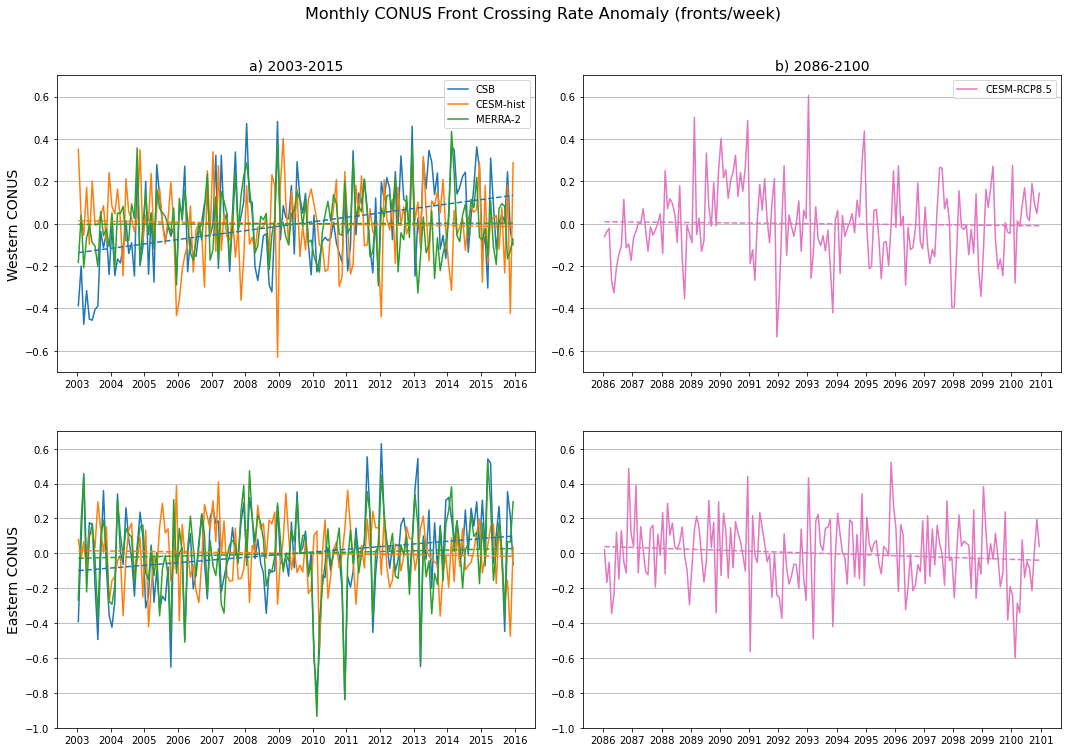

In [69]:
filepath1 = "/glade/work/kdagon/ML-extremes/data/CODSUS/MERRA2/"
ratesfile1 = "codsus_frontRates_2003-2015.nc"
gridtype1 = 'MERRA'
label1 = 'CSB'

filepath2 = "/glade/work/kdagon/FrontDetector/CESMOutputs/"
ratesfile2 = "cesm_fronts_2003-2015_frontRates_viaPolylines_customgrid.nc"
gridtype2 = 'MERRA'
label2 = 'CESM'

filepath3 = "/glade/work/kdagon/FrontDetector/MERRAOutputs/"
ratesfile3 = "merra_cesm_fronts_2003-2015_frontRates_viaPolylines_customgrid.nc"
gridtype3 = 'MERRA'
label3='MERRA'
timerange='2003-2015'

filepath4 = "/glade/work/kdagon/FrontDetector/CESMOutputs/"
ratesfile4 = "cesm_fronts_2086-2100_frontRates_viaPolylines_customgrid.nc"
gridtype4 = 'MERRA'
timerange4 = '2086-2100'

# call processing function
spatial1_w, mean1_w, spatial1_e, mean1_e = mrates_anom_CONUS_regions(path=filepath1, file=ratesfile1, grid=gridtype1)
spatial2_w, mean2_w, spatial2_e, mean2_e = mrates_anom_CONUS_regions(path=filepath2, file=ratesfile2, grid=gridtype2)
spatial3_w, mean3_w, spatial3_e, mean3_e = mrates_anom_CONUS_regions(path=filepath3, file=ratesfile3, grid=gridtype3)
spatial4_w, mean4_w, spatial4_e, mean4_e = mrates_anom_CONUS_regions(path=filepath4, file=ratesfile4, grid=gridtype4)
    
# standarize time indices - fix logic to check for the CESM output
datetimeindex = mean2_w.indexes['months'].to_datetimeindex()
mean2_w['months'] = datetimeindex
datetimeindex = mean2_e.indexes['months'].to_datetimeindex()
mean2_e['months'] = datetimeindex

datetimeindex = mean4_w.indexes['months'].to_datetimeindex()
mean4_w['months'] = datetimeindex
datetimeindex = mean4_e.indexes['months'].to_datetimeindex()
mean4_e['months'] = datetimeindex
    
# linear regression fits
reg1_w = mean1_w.polyfit(dim='months', deg=1)
reg2_w = mean2_w.polyfit(dim='months', deg=1)
reg3_w = mean3_w.polyfit(dim='months', deg=1)
reg4_w = mean4_w.polyfit(dim='months', deg=1)
fit1_w = xr.polyval(mean1_w['months'], reg1_w.polyfit_coefficients)
fit2_w = xr.polyval(mean2_w['months'], reg2_w.polyfit_coefficients)
fit3_w = xr.polyval(mean3_w['months'], reg3_w.polyfit_coefficients)
fit4_w = xr.polyval(mean4_w['months'], reg4_w.polyfit_coefficients)

reg1_e = mean1_e.polyfit(dim='months', deg=1)
reg2_e = mean2_e.polyfit(dim='months', deg=1)
reg3_e = mean3_e.polyfit(dim='months', deg=1)
reg4_e = mean4_e.polyfit(dim='months', deg=1)
fit1_e = xr.polyval(mean1_e['months'], reg1_e.polyfit_coefficients)
fit2_e = xr.polyval(mean2_e['months'], reg2_e.polyfit_coefficients)
fit3_e = xr.polyval(mean3_e['months'], reg3_e.polyfit_coefficients)
fit4_e = xr.polyval(mean4_e['months'], reg4_e.polyfit_coefficients)
    
# set up plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

# TO DO: label years at first month of each year, given data input?
#labels = np.arange(2000,2015)  # the labels

# first panel
ax[0,0].plot(mean1_w.months, (mean1_w*7)[:,4], label=label1, color='C0')
ax[0,0].plot(mean2_w.months, (mean2_w*7)[:,4], label='CESM-hist', color='C1')
ax[0,0].plot(mean3_w.months, (mean3_w*7)[:,4], label='MERRA-2', color='C2')
ax[0,0].plot(mean1_w.months, (fit1_w*7)[:,4], color='C0', linestyle='dashed')
ax[0,0].plot(mean2_w.months, (fit2_w*7)[:,4], color='C1', linestyle='dashed')
ax[0,0].plot(mean3_w.months, (fit3_w*7)[:,4], color='C2', linestyle='dashed')

date_form = DateFormatter("%Y")
ax[0,0].xaxis.set_major_formatter(date_form)
# Ensure a major tick for each year
ax[0,0].xaxis.set_major_locator(mdates.YearLocator())

#ax[0,0].margins(x=0.005)
ax[0,0].set_ylim(-0.7,0.7)

ax[0,0].set_ylabel('Western CONUS', fontsize=14)
ax[0,0].set_title('a) '+timerange, fontsize=14)

ax[0,0].legend()
ax[0,0].grid(axis='y')
    
# second panel
ax[0,1].plot(mean4_w.months, (mean4_w*7)[:,4], label='CESM-RCP8.5', color='C6')
ax[0,1].plot(mean4_w.months, (fit4_w*7)[:,4], color='C6', linestyle='dashed')

ax[0,1].xaxis.set_major_formatter(date_form)
ax[0,1].xaxis.set_major_locator(mdates.YearLocator())
#ax[0,1].margins(x=0.005)
ax[0,1].set_ylim(-0.7,0.7)
ax[0,1].set_title('b) '+timerange4, fontsize=14)
ax[0,1].legend()
ax[0,1].grid(axis='y')

# third panel
ax[1,0].plot(mean1_e.months, (mean1_e*7)[:,4], label=label1, color='C0')
ax[1,0].plot(mean2_e.months, (mean2_e*7)[:,4], label='CESM-hist', color='C1')
ax[1,0].plot(mean3_e.months, (mean3_e*7)[:,4], label='MERRA-2', color='C2')
ax[1,0].plot(mean1_e.months, (fit1_e*7)[:,4], color='C0', linestyle='dashed')
ax[1,0].plot(mean2_e.months, (fit2_e*7)[:,4], color='C1', linestyle='dashed')
ax[1,0].plot(mean3_e.months, (fit3_e*7)[:,4], color='C2', linestyle='dashed')

ax[1,0].xaxis.set_major_formatter(date_form)
ax[1,0].xaxis.set_major_locator(mdates.YearLocator())
#ax[1,0].margins(x=0.005)
ax[1,0].set_ylim(-1,0.7)
ax[1,0].set_ylabel('Eastern CONUS', fontsize=14)
#ax[1,0].set_title('a) '+timerange, fontsize=14)
#ax[1,0].legend()
ax[1,0].grid(axis='y')

# fourth panel
ax[1,1].plot(mean4_e.months, (mean4_e*7)[:,4], label='CESM-RCP8.5', color='C6')
ax[1,1].plot(mean4_e.months, (fit4_e*7)[:,4], color='C6', linestyle='dashed')

ax[1,1].xaxis.set_major_formatter(date_form)
ax[1,1].xaxis.set_major_locator(mdates.YearLocator())
#ax[1,1].margins(x=0.005)
ax[1,1].set_ylim(-1,0.7)
#ax[1,1].set_title('b) '+timerange4, fontsize=14)
#ax[1,1].legend()
ax[1,1].grid(axis='y')

plt.subplots_adjust(wspace=0.1)
fig.suptitle('Monthly CONUS Front Crossing Rate Anomaly (fronts/week)', y=0.96, fontsize=16);

#plt.savefig('../figures/toSCP/csb_cesm_merra_rcp85_mrates_anom_CONUS_regions.png', bbox_inches='tight') 